<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Denmark/VWSDE/VWSDE_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "VWSDKDKK"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-25 13:35:36,464 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-25 13:35:36,466 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for VWSDKDKK
2019-08-25 13:38:50,505 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-25 13:45:13,676 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-25 13:48:32,822 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-25 13:51:47,937 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-25 13:55:09,983 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-25 13:58:25,327 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-25 14:01:48,487 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-25 14:05:10,559 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  4.46798  4.47797  4.36997  4.38998  3.182474
2018-01-02 09:00:00  4.38998  4.39998  4.34897  4.39188  3.115560
2018-01-02 10:00:00  4.39297  4.41988  4.37797  4.40998  2.035282
2018-01-02 11:00:00  4.40997  4.42498  4.40397  4.40898  1.822899
2018-01-02 12:00:00  4.40897  4.44097  4.40097  4.41898  1.182626
...                      ...      ...      ...      ...       ...
2018-12-28 11:00:00  4.95098  4.95398  4.91697  4.91788  4.960000
2018-12-28 12:00:00  4.91897  4.92987  4.91197  4.92987  3.790000
2018-12-28 13:00:00  4.92888  4.94087  4.92098  4.93097  3.620000
2018-12-28 14:00:00  4.93297  4.94498  4.92187  4.93898  4.640000
2018-12-28 15:00:00  4.93887  4.93998  4.90298  4.91987  6.160000

[1974 rows x 5 columns]

Open         High          Low        Close       Volume
count  1974.000000  1974.000000  1974.000000  1974.000000  1974.000000
mean      4.299118     4.317412     4.281563     4.299776     5.646954
std       0.288331     0.289700     0.288229     0.289128     2.476539
min       3.783880     3.821270     3.765980     3.815880     0.030000
25%       4.100970     4.117970     4.084203     4.100980     3.970000
50%       4.249975     4.267930     4.231925     4.248980     5.230000
75%       4.392980     4.410723     4.374620     4.392978     6.840000
max       5.273980     5.317880     5.237870     5.273970    26.500000

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
2018-01-10 10:00:00  4.24898  4.25397  4.22997  4.24098  2.520922   10          2         10             31    10             0               0                 0      1        1     2        2             1           2  4.270570  4.291591 -4.453236  4.261913  4.304764  4.278626    4.313975    4.317475  4.444067  4.325724  4.230636  4.330674  4.293918  4.325724  4.239973  4.359190                4.462230                 4.325724                4.189217                4.530484                 4.325724                4.120964                4.598737                 4.325724                4.052711                4.666990                 4.325724                3.984457  4.304764  4.256792  4.361540                4.441271                 4.304764                4.168258                4.509524                 4.304764                4.100004                4.577778                 4.304764                4.031751                4.646031                 4.304764                3.963498   
2018-01-10 11:00:00  4.24097  4.27298  4.23897  4.25098  3.408910   10          2         10             31    11             0               0                 0      1        1     2        2             1           2  4.269590  4.291041 -4.430110  4.250187  4.292812  4.272221    4.313975    4.312475  4.426299  4.307725  4.226037  4.302224  4.277309  4.307725  4.245980  4.353911                4.440894                 4.307725                4.174556                4.507479                 4.307725                4.107971                4.574064                 4.307725                4.041386                4.640648                 4.307725                3.974802  4.292812  4.249379  4.354365                4.425982                 4.292812                4.159643                4.492566                 4.292812                4.093058                4.559151                 4.292812                4.026474                4.625736                 4.292812                3.959889   
2018-01-10 12:00:00  4.2

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000    1924.000000  1924.000000   1924.000000     1924.000000       1924.000000  1924.000000  1924.000000  1924.000000  1924.000000   1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000  1924.000000             1924.000000              1924.000000             1924.000000             1924.000000              1924.000000             1924.000000             1924.000000              1924.000000             1924.000000             1924.000000              1924.000000             1924.000000  1924.000000  1924.000000  1924.000000             1924.000000              1924.000000             1924.000000             1924.000000              1924.000000             1924.000000             1924.000000   
mean      4.297972     4.316301     4.280645     4.298828     5.698784    15.881497     2.010395   186.538462      30.417360    10.880457      0.032744        0.028586          0.004158     6.637214     2.549376    27.218295     2.010395      1.984927    27.218295     4.299127     4.297618    -0.196999     4.298772     4.297713     4.299081     4.297658     4.296640     4.295066     4.297693     4.298762     4.297679     4.298051     4.297693     4.298619     4.295586                4.350879                 4.297693                4.244508                4.377471                 4.297693                4.217915                4.404064                 4.297693                4.191322                4.430657                 4.297693                4.164729     4.297713     4.298561     4.295917                4.350898                 4.297713                4.244527                4.377491                 4.297713                4.217935                4.404084   
std       0.291741     0.293120     0.291686     0.292582     2.469846     8.594553     1.404952   101.852366       0.859882     2.336100      0.178013        0.166684          0.064365     3.352476     1.105065    14.547005     1.404952      1.406575    14.547005     0.288621     0.280769     4.306010     0.293547     0.288600     0.292090     0.289144     0.289003     0.291700     0.289571     0.293075     0.289970     0.290277     0.289571     0.291651     0.283380                0.293053                 0.289571                0.290559                0.296429                 0.289571                0.292723                0.300851                 0.289571                0.295973                0.306272                 0.289571                0.300273     0.288600     0.291556     0.284328                0.292209                 0.288600                0.289477                0.295651                 0.288600                0.291592                0.300140   
min       3.783880     3.821270     3.765980     3.815880     0.030000     1.000000     0.000000    10.000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-10 10:00:00  0.312127  0.289120  0.315234  0.291546  0.094104   10          2         10             31    10             0               0                 0      1        1     2        2             1           2  0.307620  0.320812  0.081989  0.306426  0.336024  0.309024    0.339235    0.337357  0.436940  0.347221  0.286322  0.352450  0.327609  0.347221  0.293407  0.369444                0.405755                 0.347221                0.306429                0.425626                 0.347221                0.318217                0.443749                 0.347221                0.328626                0.460645                 0.347221                0.337786  0.336024  0.306389  0.371351                0.388949                 0.336024                0.272425                0.408950                 0.336024                0.285684                0.427559                 0.336024                0.298607                0.444652                 0.336024   
2018-01-10 11:00:00  0.306751  0.301822  0.321349  0.298404  0.127651   10          2         10             31    11             0               0                 0      1        1     2        2             1           2  0.306910  0.320391  0.084182  0.298390  0.327428  0.304429    0.339235    0.333838  0.425491  0.334443  0.283188  0.332406  0.315897  0.334443  0.297568  0.365510                0.391149                 0.334443                0.296504                0.410435                 0.334443                0.310020                0.428026                 0.334443                0.321938                0.444427                 0.334443                0.332426  0.327428  0.301221  0.366034                0.378531                 0.327428                0.266371                0.397813                 0.327428                0.281138                0.415752                 0.327428                0.295381                0.432227                 0.327428   
2018-01-10 12:00:00  0.312798  0.292467  0.319311  0.300462  0.070604   10          2         10         

52

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpktmx0l5q
  JVM stdout: /tmp/tmpktmx0l5q/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpktmx0l5q/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 6 days
H2O cluster name:           H2O_from_python_unknownUser_6nasu2
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_142321_mod...  0.592048   1.249837              0.431155  0.654446  0.428300
1  DeepLearning_grid_1_AutoML_20190825_142321_mod...  0.588562   1.089993              0.494118  0.620042  0.384452
2  DeepLearning_grid_1_AutoML_20190825_142321_mod...  0.570261  12.804919              0.486983  0.735106  0.540381
3  DeepLearning_grid_1_AutoML_20190825_142321_mod...  0.532734   0.709982              0.500000  0.508250  0.258318
4  DeepLearning_grid_1_AutoML_20190825_142321_mod...  0.527342   1.180500              0.419771  0.632592  0.400173
5  DeepLearning_grid_1_AutoML_20190825_142321_mod...  0.515142   0.693125              0.481100  0.499989  0.249989
6  DeepLearning_grid_1_AutoML_20190825_142321_mod...  0.500000   0.693862              0.500000  0.500357  0.250357
7  DeepLearning_grid_1_AutoML_20190825_142321_mod...  0.500000   0.689489              0.500000  0.498168  0.248171
8              DeepLearning_1_AutoML_20190825_142321  0.500000   0.697371              0.500000  0.502107  0.252111
9  DeepLearning_grid_1_AutoML_20190825_142321_mod...  0.488235   0.705087              0.500000  0.505919  0.255954

variable  relative_importance  scaled_importance  percentage
0                 HT_TRENDMODE             1.000000           1.000000    0.002168
1                       SAREXT             0.993441           0.993441    0.002154
2                 CDLTASUKIGAP             0.905520           0.905520    0.001963
3                          BOP             0.879953           0.879953    0.001908
4                         hour             0.876933           0.876933    0.001901
...                        ...                  ...                ...         ...
1033                    SMA_24             0.358661           0.358661    0.000778
1034  BBANDS_middleband_20_0_2             0.353562           0.353562    0.000767
1035                  TYPPRICE             0.348075           0.348075    0.000755
1036   BBANDS_middleband_8_8_5             0.346385           0.346385    0.000751
1037          CDLCOUNTERATTACK             0.321065           0.321065    0.000696

[1038 rows x 4 columns]

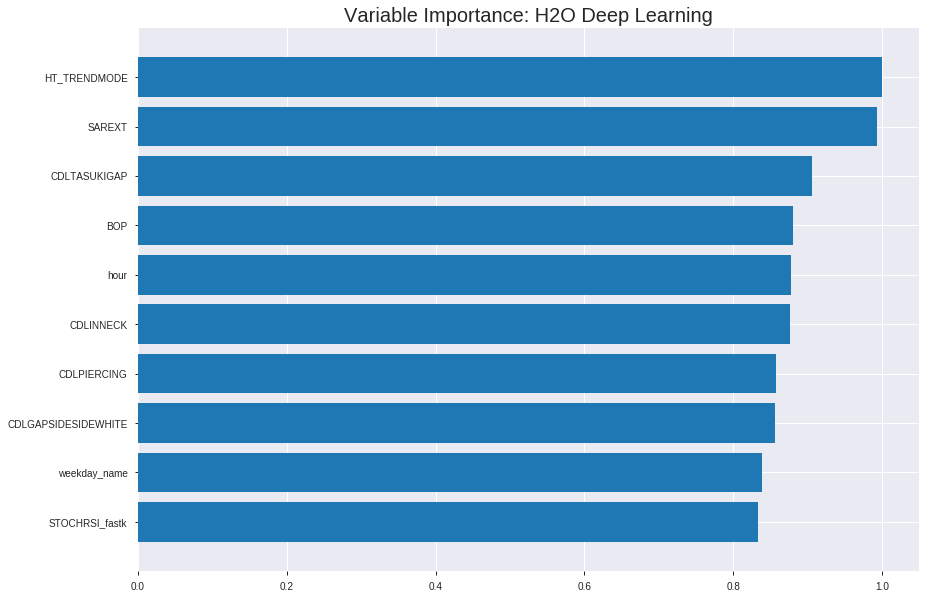

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_142321_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2667746046272726
RMSE: 0.5165022794018169
LogLoss: 0.744844125129967
Mean Per-Class Error: 0.4487553126897389
AUC: 0.5640050781034388
pr_auc: 0.5519513121704094
Gini: 0.1280101562068776
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2746811195874673: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      12   659   0.9821   (659.0/671.0)
1      2    673   0.003    (2.0/675.0)
Total  14   1332  0.4911   (661.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.274681     0.670653  389
max f2                       0.255428     0.835603  393
max f0point5                 0.400207     0.575911  323
max accuracy                 0.431822     0.552006  298
max precision                0.955099     1         0
max recall                   0.255428     1         393
max specificity              0.955099     1         0
max absolute_mcc             0.400207     0.127247  323
max min_per_class_accuracy   0.538232     0.533532  220
max mean_per_class_accuracy  0.431822     0.551245  298

Gains/Lift Table: Avg response rate: 50.15 %, avg score: 57.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.924327           1.13947   1.13947            0.571429         0.937541  0.571429                    0.937541            0.0118519       0.0118519                  13.9471   13.9471
    2        0.0200594                   0.914424           1.38051   1.25553            0.692308         0.919002  0.62963                     0.928615            0.0133333       0.0251852                  38.0513   25.5528
    3        0.0304606                   0.909786           1.2819    1.26453            0.642857         0.912195  0.634146                    0.923008            0.0133333       0.0385185                  28.1905   26.4535
    4        0.0401189                   0.900937           1.38051   1.29246            0.692308         0.904234  0.648148                    0.918488            0.0133333       0.0518519                  38.0513   29.2455
    5        0.0505201                   0.896115           1.2819    1.29028            0.642857         0.898546  0.647059                    0.914382            0.0133333       0.0651852                  28.1905   29.0283
    6        0.100297                    0.865941           0.952394  1.12259            0.477612         0.881552  0.562963                    0.898089            0.0474074       0.112593                   -4.76064  12.259
    7        0.150074                    0.791317           1.19049   1.14511            0.597015         0.827626  0.574257                    0.874718            0.0592593       0.171852                   19.0492   14.5112
    8        0.200594                    0.730109           1.23163   1.1669             0.617647         0.758836  0.585185                    0.845533            0.0622222       0.234074                   23.1634   16.6903
    9        0.300149                    0.660151           1.13097   1.15498            0.567164         0.693962  0.579208                    0.795259            0.112593        0.346667                   13.0967   15.4983
    10       0.400446                    0.605719           0.886255  1.08768            0.444444         0.633356  0.545455                    0.754708            0.0888889       0.435556                   -11.3745  8.76768
    11       0.5                         0.53877            0.982156  1.06667            0.492537         0.569411  0.534918                    0.717814            0.0977778       0.533333                   -1.78441  6.66667
    12       0.600297                    0.493259           1.04874   1.06367            0.525926         0.514028  0.533416                    0.683766            0.105185        0.638519                   4.87353   6.36707
    13       0.699851                    0.450836           1.04168   1.06054            0.522388         0.471339  0.531847                    0.653548            0.103704        0.742222                   4.16805   6.05426
    14       0.800149                    0.411474           1.03396   1.05721            0.518519         0.432243  0.530176                    0.625808            0.103704        0.845926                   3.39643   5.7211
    15       0.899703                    0.354843           0.788701  1.0275             0.395522         0.387752  0.515277                    0.599466            0.0785185       0.924444                   -21.1299  2.74998
    16       1                           0.192056           0.753317  1                  0.377778         0.314122  0.501486                    0.570847           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2821152978891752
RMSE: 0.5311452700431165
LogLoss: 0.7737348893310991
Mean Per-Class Error: 0.46382551610015466
AUC: 0.5191655589615604
pr_auc: 0.5174398448086679
Gini: 0.03833111792312072
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12336106682281828: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    184  0.9534   (184.0/193.0)
1      1    190  0.0052   (1.0/191.0)
Total  10   374  0.4818   (185.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.123361     0.672566  373
max f2                       0.123361     0.834798  373
max f0point5                 0.167079     0.567686  352
max accuracy                 0.522206     0.536458  170
max precision                0.92284      1         0
max recall                   0.0965068    1         380
max specificity              0.92284      1         0
max absolute_mcc             0.123361     0.129964  373
max min_per_class_accuracy   0.50714      0.507772  191
max mean_per_class_accuracy  0.522206     0.536174  170

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 49.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.904666           1.00524   1.00524            0.5              0.915752  0.5                         0.915752            0.0104712       0.0104712                  0.52356   0.52356
    2        0.0208333                   0.870462           1.50785   1.25654            0.75             0.891306  0.625                       0.903529            0.0157068       0.026178                   50.7853   25.6545
    3        0.03125                     0.85163            1.50785   1.34031            0.75             0.860164  0.666667                    0.889074            0.0157068       0.0418848                  50.7853   34.0314
    4        0.0416667                   0.832385           1.50785   1.3822             0.75             0.838401  0.6875                      0.876406            0.0157068       0.0575916                  50.7853   38.2199
    5        0.0520833                   0.821437           1.00524   1.30681            0.5              0.825279  0.65                        0.86618             0.0104712       0.0680628                  0.52356   30.6806
    6        0.101562                    0.759527           0.846514  1.08256            0.421053         0.785535  0.538462                    0.826892            0.0418848       0.109948                   -15.3486  8.25614
    7        0.151042                    0.711699           0.846514  1.00524            0.421053         0.73697   0.5                         0.797434            0.0418848       0.151832                   -15.3486  0.52356
    8        0.200521                    0.665806           0.952328  0.992181           0.473684         0.684206  0.493506                    0.769495            0.0471204       0.198953                   -4.76715  -0.781941
    9        0.299479                    0.594818           1.16396   1.04894            0.578947         0.629714  0.521739                    0.723307            0.115183        0.314136                   16.3957   4.89415
    10       0.401042                    0.55041            1.08256   1.05746            0.538462         0.56805   0.525974                    0.683988            0.109948        0.424084                   8.25614   5.74556
    11       0.5                         0.50708            0.846514  1.01571            0.421053         0.522777  0.505208                    0.652082            0.0837696       0.507853                   -15.3486  1.57068
    12       0.598958                    0.478774           1.05814   1.02272            0.526316         0.494227  0.508696                    0.626002            0.104712        0.612565                   5.81427   2.2718
    13       0.700521                    0.422232           0.773258  0.986551           0.384615         0.452911  0.490706                    0.600907            0.078534        0.691099                   -22.6742  -1.34491
    14       0.799479                    0.325503           1.16396   1.00851            0.578947         0.376529  0.501629                    0.573134            0.115183        0.806283                   16.3957   0.850999
    15       0.898438                    0.180659           1.21686   1.03146            0.605263         0.253916  0.513043                    0.537973            0.120419        0.926702                   21.6864   3.14591
    16       1                           0.0811611          0.721708  1                  0.358974         0.139699  0.497396                    0.497524      


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 14:24:26  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 14:24:26  59.032 sec        494 obs/sec       0.321694  1             433        0.682575         9.41374             -0.863651      0.527218        0.39466            1.21378          0.498514                         0.660375           7.39411               -0.744426        0.556412          0.432571             1.09662            0.502604
    2019-08-25 14:24:34  1 min  6.286 sec  521 obs/sec       2.91902   9             3929       0.548865         0.940206            -0.20502       0.567104        0.548933           1.56677          0.494799                         0.580603           1.06605               -0.348434        0.496216          0.496526             1.00524            0.494792
    2019-08-25 14:24:40  1 min 12.648 sec  520 obs/sec       5.12927   16            6904       0.560247         0.913488            -0.255518      0.552835        0.546029           1.42434          0.485884                         0.582415           1.27074               -0.356867        0.53357           0.53129              1.50785            0.5
    2019-08-25 14:24:47  1 min 19.105 sec  521 obs/sec       7.40639   23            9969       0.583215         1.06188             -0.360571      0.492499        0.479462           0.569735         0.494799                         0.57968            1.38781               -0.344154        0.474595          0.469634             0                  0.5
    2019-08-25 14:24:53  1 min 25.397 sec  527 obs/sec       9.72957   30            13096      0.560779         0.946264            -0.257905      0.544798        0.533636           0.854603         0.485884                         0.54718            1.20413               -0.197656        0.555299          0.537121             1.50785            0.492188
    2019-08-25 14:24:59  1 min 31.243 sec  535 obs/sec       11.9577   37            16095      0.556099         0.881847            -0.236995      0.52113         0.521999           1.42434          0.480684                         0.573154           0.985868              -0.314058        0.490085          0.484961             0                  0.502604
    2019-08-25 14:25:05  1 min 37.512 sec  545 obs/sec       14.4755   45            19484      0.531333         0.780407            -0.12927       0.530156        0.527715           0.854603         0.498514                         0.548755           0.850526              -0.20456         0.495836          0.481606             1.00524            0.494792
    2019-08-25 14:25:11  1 min 43.911 sec  552 obs/sec       17.0505   53            22950      0.547531         0.830579            -0.199172      0.544112        0.559154           1.85164          0.494056                         0.579648           0.999533              -0.344005        0.473998          0.479804             1.00524            0.5
    2019-08-25 14:25:18  1 min 49.972 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
HT_TRENDMODE              1.0                    1.0                  0.0021680995336711265
SAREXT                    0.993440568447113      0.993440568447113    0.002153878033180165
CDLTASUKIGAP              0.9055195450782776     0.9055195450782776   0.0019632565034143046
BOP                       0.879952609539032      0.879952609539032    0.0019078248423942663
hour                      0.8769332766532898     0.8769332766532898   0.0019012786281726907
---                       ---                    ---                  ---
SMA_24                    0.3586609959602356     0.3586609959602356   0.0007776127380874087
BBANDS_middleband_20_0_2  0.35356223583221436    0.35356223583221436  0.0007665581186315449
TYPPRICE                  0.34807467460632324    0.34807467460632324  0.0007546605396966986
BBANDS_middleband_8_8_5   0.3463853597640991     0.3463853597640991   0.0007509979369750488
CDLCOUNTERATTACK          0.32106515765190125    0.32106515765190125  0.0006961012185831339


See the whole table with table.as_data_frame()


('accuracy', 0.6113989637305699)

('F1', 0.7272727272727272)

('auc', 0.5920479302832244)

('logloss', 1.2498373779202048)

('mean_per_class_error', 0.4162309368191721)

('rmse', 0.6544460184987493)

('mse', 0.42829959112886523)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


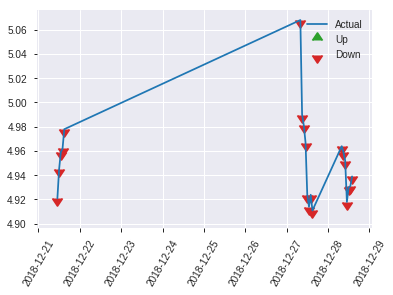


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.42829959112886523
RMSE: 0.6544460184987493
LogLoss: 1.2498373779202048
Mean Per-Class Error: 0.4162309368191721
AUC: 0.5920479302832244
pr_auc: 0.6369891369629734
Gini: 0.1840958605664489
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.060806709002384496: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      18   67   0.7882   (67.0/85.0)
1      8    100  0.0741   (8.0/108.0)
Total  26   167  0.3886   (75.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0608067    0.727273  166
max f2                       0.0394584    0.864     192
max f0point5                 0.0608067    0.64433   166
max accuracy                 0.0608067    0.611399  166
max precision                0.277059     0.9       9
max recall                   0.0394584    1         192
max specificity              0.328477     0.988235  0
max absolute_mcc             0.0608067    0.200208  166
max min_per_class_accuracy   0.105182     0.555556  95
max mean_per_class_accuracy  0.0857678    0.583769  117

Gains/Lift Table: Avg response rate: 55.96 %, avg score: 12.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103627                   0.31208            0.893519  0.893519           0.5              0.328141   0.5                         0.328141            0.00925926      0.00925926                 -10.6481   -10.6481
    2        0.0207254                   0.295211           1.78704   1.34028            1                0.30894    0.75                        0.31854             0.0185185       0.0277778                  78.7037    34.0278
    3        0.0310881                   0.288749           1.78704   1.4892             1                0.292431   0.833333                    0.309837            0.0185185       0.0462963                  78.7037    48.9198
    4        0.0414508                   0.284255           1.78704   1.56366            1                0.287458   0.875                       0.304242            0.0185185       0.0648148                  78.7037    56.3657
    5        0.0518135                   0.269278           1.78704   1.60833            1                0.279971   0.9                         0.299388            0.0185185       0.0833333                  78.7037    60.8333
    6        0.103627                    0.242955           1.07222   1.34028            0.6              0.252107   0.75                        0.275748            0.0555556       0.138889                   7.22222    34.0278
    7        0.150259                    0.206897           0.992798  1.23244            0.555556         0.224373   0.689655                    0.259804            0.0462963       0.185185                   -0.720165  23.2439
    8        0.202073                    0.185661           1.25093   1.23718            0.7              0.198969   0.692308                    0.244205            0.0648148       0.25                       25.0926    23.7179
    9        0.300518                    0.156544           0.940546  1.14001            0.526316         0.172302   0.637931                    0.220651            0.0925926       0.342593                   -5.94542   14.0006
    10       0.398964                    0.119006           1.0346    1.114              0.578947         0.132886   0.623377                    0.198994            0.101852        0.444444                   3.46004    11.3997
    11       0.502591                    0.104452           1.07222   1.10538            0.6              0.110722   0.618557                    0.180794            0.111111        0.555556                   7.22222    10.5384
    12       0.601036                    0.086412           1.12865   1.1092             0.631579         0.096248   0.62069                     0.166946            0.111111        0.666667                   12.8655    10.9195
    13       0.699482                    0.0779681          0.846491  1.07222            0.473684         0.0820797  0.6                         0.155002            0.0833333       0.75                       -15.3509   7.22222
    14       0.797927                    0.0682282          0.940546  1.05598            0.526316         0.0731349  0.590909                    0.144901            0.0925926       0.842593                   -5.94542   5.59764
    15       0.896373                    0.0544092          0.940546  1.0433             0.526316         0.0614306  0.583815                    0.135734            0.0925926       0.935185                   -5.94542   4.32991
    16       1                           0.0394584          0.625463  1                  0.35             0.0483321  0.559585 

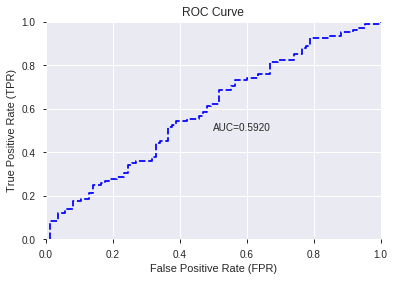

This function is available for GLM models only


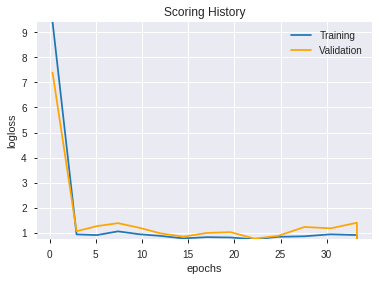

--2019-08-25 14:42:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  16.8MB/s    in 23s     

2019-08-25 14:42:25 (15.3 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_142321_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_142321_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_9982',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_144238_model_2  0.665468  0.840763              0.460948  0.532809  0.283885
1  DeepLearning_grid_1_AutoML_20190825_144238_model_3  0.604793  0.957134              0.494118  0.569894  0.324779
2  DeepLearning_grid_1_AutoML_20190825_144238_model_6  0.563834  0.726653              0.500000  0.514411  0.264619
3  DeepLearning_grid_1_AutoML_20190825_144238_model_1  0.560948  1.841427              0.494118  0.636607  0.405269
4  DeepLearning_grid_1_AutoML_20190825_144238_model_5  0.556536  0.709402              0.500000  0.507512  0.257569
5  DeepLearning_grid_1_AutoML_20190825_144238_model_7  0.554248  0.926861              0.456318  0.589081  0.347017
6               DeepLearning_1_AutoML_20190825_144238  0.539325  0.767008              0.472712  0.522663  0.273176
7  DeepLearning_grid_1_AutoML_20190825_144238_model_4  0.523203  1.461594              0.481100  0.649850  0.422306
8  DeepLearning_grid_1_AutoML_20190825_144238_model_8  0.516122  0.703548              0.500000  0.505150  0.255176
9  DeepLearning_grid_1_AutoML_20190825_144238_model_9  0.497821  0.693377              0.488235  0.500114  0.250114

variable  relative_importance  scaled_importance  percentage
0        CDL3LINESTRIKE             1.000000           1.000000    0.034545
1             CDLINNECK             0.971912           0.971912    0.033575
2   CDLGAPSIDESIDEWHITE             0.842578           0.842578    0.029107
3    CDLEVENINGDOJISTAR             0.779409           0.779409    0.026925
4     CDLSTALLEDPATTERN             0.741136           0.741136    0.025603
5             CDL2CROWS             0.705813           0.705813    0.024383
6     CDL3WHITESOLDIERS             0.705629           0.705629    0.024376
7     CDLDARKCLOUDCOVER             0.702927           0.702927    0.024283
8       CDLLADDERBOTTOM             0.697562           0.697562    0.024097
9          CDLTHRUSTING             0.687215           0.687215    0.023740
10                  day             0.679921           0.679921    0.023488
11       CDLEVENINGSTAR             0.678705           0.678705    0.023446
12         HT_TRENDMODE             0.678469           0.678469    0.023438
13          CDLPIERCING             0.664742           0.664742    0.022964
14         CDLTASUKIGAP             0.654327           0.654327    0.022604
15            CDLONNECK             0.643629           0.643629    0.022234
16         weekday_name             0.629046           0.629046    0.021731
17                  OBV             0.621249           0.621249    0.021461
18   CDLMORNINGDOJISTAR             0.607916           0.607916    0.021001
19                 hour             0.587971           0.587971    0.020312
20        days_in_month             0.572555           0.572555    0.019779
21                ADOSC             0.572452           0.572452    0.019776
22              BETA_12             0.567025           0.567025    0.019588
23         aroondown_30             0.536056           0.536056    0.018518
24       STOCHRSI_fastk             0.532231           0.532231    0.018386
25          HT_DCPERIOD             0.530572           0.530572    0.018329
26                 DX_8             0.529504           0.529504    0.018292
27           aroonup_30             0.525973           0.525973    0.018170
28           aroonup_20             0.525889           0.525889    0.018167
29          aroondown_8             0.517112           0.517112    0.017864
30               SAREXT             0.513356           0.513356    0.017734
31         aroondown_20             0.512014           0.512014    0.017688
32            aroonup_8             0.503141           0.503141    0.017381
33                  BOP             0.501426           0.501426    0.017322
34         CDLSHORTLINE             0.492610           0.492610    0.017017
35    CDLLONGLEGGEDDOJI             0.492091           0.492091    0.016999
36            dayofweek             0.490714           0.490714    0.016952
37         aroondown_12             0.476800           0.476800    0.016471
38              weekday             0.467896           0.467896    0.016164
39         aroondown_24             0.458824           0.458824    0.015850
40                 CEIL             0.454142           0.454142    0.015688
41          CDLBELTHOLD             0.453849           0.453849    0.015678
42             CORREL_8             0.452736           0.452736    0.015640
43         aroondown_14             0.449173           0.449173    0.015517
44            CORREL_12             0.446449           0.446449    0.015423
45         STOCHF_fastk             0.432719           0.432719    0.014948
46         STOCHF_fastd             0.432692           0.432692    0.014947
47      CDLADVANCEBLOCK             0.415992           0.415992    0.014371
48    CDLINVERTEDHAMMER             0.406672           0.406672    0.014049
49                FLOOR             0.404673           0.404673    0.013980

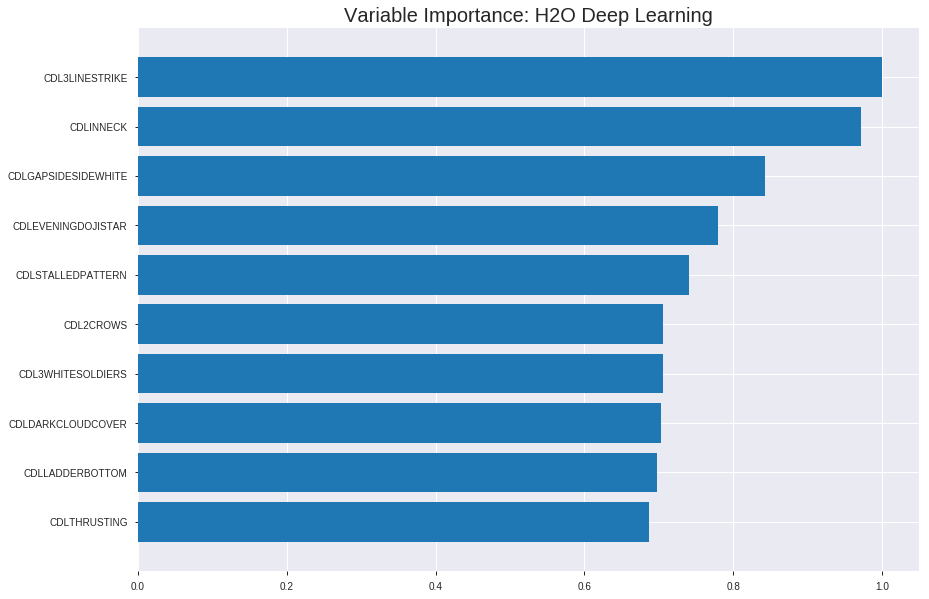

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_144238_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2513407923569487
RMSE: 0.5013389994374552
LogLoss: 0.7286446890373401
Mean Per-Class Error: 0.3830402384500745
AUC: 0.6402516973008776
pr_auc: 0.6198637982667868
Gini: 0.2805033946017552
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25003192286912784: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      156  515   0.7675   (515.0/671.0)
1      64   611   0.0948   (64.0/675.0)
Total  220  1126  0.4302   (579.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.250032     0.678512  319
max f2                       0.00363478   0.834985  398
max f0point5                 0.380195     0.619715  257
max accuracy                 0.380195     0.617385  257
max precision                0.999056     1         0
max recall                   4.90412e-05  1         399
max specificity              0.999056     1         0
max absolute_mcc             0.380195     0.244174  257
max min_per_class_accuracy   0.503959     0.604444  200
max mean_per_class_accuracy  0.380195     0.61696   257

Gains/Lift Table: Avg response rate: 50.15 %, avg score: 50.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.985743           1.70921   1.70921            0.857143         0.993251  0.857143                    0.993251            0.0177778       0.0177778                  70.9206   70.9206
    2        0.0200594                   0.97466            1.84068   1.77251            0.923077         0.979289  0.888889                    0.986529            0.0177778       0.0355556                  84.0684   77.251
    3        0.0304606                   0.96002            1.42434   1.65362            0.714286         0.967311  0.829268                    0.979966            0.0148148       0.0503704                  42.4339   65.3622
    4        0.0401189                   0.946525           1.38051   1.58787            0.692308         0.952808  0.796296                    0.973428            0.0133333       0.0637037                  38.0513   58.7874
    5        0.0505201                   0.930576           1.2819    1.52488            0.642857         0.93927   0.764706                    0.966396            0.0133333       0.077037                   28.1905   52.488
    6        0.100297                    0.855502           1.19049   1.35892            0.597015         0.901759  0.681481                    0.934317            0.0592593       0.136296                   19.0492   35.8925
    7        0.150074                    0.793556           1.01192   1.24383            0.507463         0.823785  0.623762                    0.897655            0.0503704       0.186667                   1.19182   24.3828
    8        0.200594                    0.73873            1.26096   1.24814            0.632353         0.764788  0.625926                    0.864192            0.0637037       0.25037                    26.0959   24.8143
    9        0.300149                    0.65181            1.16073   1.21915            0.58209          0.691626  0.611386                    0.806955            0.115556        0.365926                   16.073    21.9149
    10       0.400446                    0.580133           1.32938   1.24676            0.666667         0.61401   0.625232                    0.758629            0.133333        0.499259                   32.9383   24.6759
    11       0.5                         0.501705           1.07144   1.21185            0.537313         0.541002  0.607727                    0.715298            0.106667        0.605926                   7.14428   21.1852
    12       0.600297                    0.414051           1.03396   1.18213            0.518519         0.458623  0.592822                    0.672413            0.103704        0.70963                    3.39643   18.2131
    13       0.699851                    0.335645           0.877988  1.13887            0.440299         0.374765  0.571125                    0.630072            0.0874074       0.797037                   -12.2012  13.8866
    14       0.800149                    0.270817           0.738546  1.08869            0.37037          0.302482  0.545961                    0.589009            0.0740741       0.871111                   -26.1454  8.86867
    15       0.899703                    0.194803           0.744057  1.05055            0.373134         0.237754  0.526837                    0.550142            0.0740741       0.945185                   -25.5943  5.05527
    16       1                           4.81554e-09        0.546524  1                  0.274074         0.12348   0.501486                    0.507349           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3228685622254471
RMSE: 0.5682152428661581
LogLoss: 0.9372668267821803
Mean Per-Class Error: 0.46567018419553485
AUC: 0.49434392208990047
pr_auc: 0.5292772778372953
Gini: -0.011312155820199066
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.0562319815088774e-06: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    192  0.9948   (192.0/193.0)
1      0    191  0        (0.0/191.0)
Total  1    383  0.5      (192.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       3.05623e-06  0.665505  382
max f2                       3.05623e-06  0.832607  382
max f0point5                 0.212022     0.557994  350
max accuracy                 0.906493     0.536458  34
max precision                0.995482     1         0
max recall                   3.05623e-06  1         382
max specificity              0.995482     1         0
max absolute_mcc             0.939551     0.140386  16
max min_per_class_accuracy   0.613927     0.507853  190
max mean_per_class_accuracy  0.906493     0.53433   34

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 57.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.970184           2.01047   2.01047            1                0.984888  1                           0.984888            0.0209424       0.0209424                  101.047   101.047
    2        0.0208333                   0.962783           1.00524   1.50785            0.5              0.965836  0.75                        0.975362            0.0104712       0.0314136                  0.52356   50.7853
    3        0.03125                     0.952866           1.50785   1.50785            0.75             0.957528  0.75                        0.969417            0.0157068       0.0471204                  50.7853   50.7853
    4        0.0416667                   0.94132            2.01047   1.63351            1                0.947657  0.8125                      0.963977            0.0209424       0.0680628                  101.047   63.3508
    5        0.0520833                   0.933461           1.00524   1.50785            0.5              0.93693   0.75                        0.958568            0.0104712       0.078534                   0.52356   50.7853
    6        0.101562                    0.903196           0.952328  1.23721            0.473684         0.915745  0.615385                    0.937706            0.0471204       0.125654                   -4.76715  23.7213
    7        0.151042                    0.862228           0.846514  1.10923            0.421053         0.882234  0.551724                    0.919534            0.0418848       0.167539                   -15.3486  10.9225
    8        0.200521                    0.823212           0.846514  1.0444             0.421053         0.840057  0.519481                    0.899923            0.0418848       0.209424                   -15.3486  4.44006
    9        0.299479                    0.768792           0.899421  0.996494           0.447368         0.79541   0.495652                    0.865388            0.0890052       0.298429                   -10.0579  -0.350558
    10       0.401042                    0.689031           1.03101   1.00524            0.512821         0.724831  0.5                         0.829792            0.104712        0.403141                   3.10109   0.52356
    11       0.5                         0.610201           1.05814   1.01571            0.526316         0.648814  0.505208                    0.793974            0.104712        0.507853                   5.81427   1.57068
    12       0.598958                    0.522714           0.7407    0.970271           0.368421         0.559637  0.482609                    0.755257            0.0732984       0.581152                   -25.93    -2.97291
    13       0.700521                    0.43671            0.92791   0.964129           0.461538         0.474587  0.479554                    0.714565            0.0942408       0.675393                   -7.20902  -3.58707
    14       0.799479                    0.324623           1.05814   0.975766           0.526316         0.374614  0.485342                    0.672487            0.104712        0.780105                   5.81427   -2.42338
    15       0.898438                    0.227441           1.21686   1.00232            0.605263         0.276275  0.498551                    0.628846            0.120419        0.900524                   21.6864   0.232188
    16       1                           2.73019e-07        0.97946   1                  0.487179         0.133623  0.497396                    0.57855    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 14:43:15  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 14:43:17  37.914 sec        7121 obs/sec      10        1             13460      0.501339         0.728645            -0.00537205    0.640252        0.619864           1.70921          0.430163                         0.568215           0.937267              -0.291509        0.494344          0.529277             2.01047            0.5
    2019-08-25 14:43:22  43.015 sec        9698 obs/sec      50        5             67300      0.486708         0.727638            0.0524514      0.704014        0.663962           1.85164          0.354383                         0.606247           1.23312               -0.470181        0.502984          0.518069             1.50785            0.492188
    2019-08-25 14:43:28  48.450 sec        10928 obs/sec     100       10            134600     0.433434         0.583772            0.248532       0.795795        0.752072           1.99407          0.281575                         0.596554           1.32463               -0.423545        0.520888          0.539263             1.50785            0.497396
    2019-08-25 14:43:33  54.245 sec        11929 obs/sec     160       16            215360     0.397492         0.509007            0.367994       0.850357        0.799603           1.85164          0.225111                         0.6032             1.40231               -0.455441        0.520766          0.528255             1.50785            0.5
    2019-08-25 14:43:39  59.772 sec        12588 obs/sec     220       22            296120     0.348824         0.402223            0.513282       0.906535        0.863438           1.85164          0.163447                         0.595845           1.39609               -0.420161        0.531197          0.544653             1.50785            0.497396
    2019-08-25 14:43:44  1 min  5.047 sec  13113 obs/sec     280       28            376880     0.335435         0.372756            0.549929       0.918393        0.877049           1.99407          0.149331                         0.612546           1.53046               -0.500893        0.518162          0.520429             1.50785            0.5
    2019-08-25 14:43:44  1 min  5.115 sec  13110 obs/sec     280       28            376880     0.501339         0.728645            -0.00537205    0.640252        0.619864           1.70921          0.430163                         0.568215           0.937267              -0.291509        0.494344          0.529277             2.01047            0.5

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
CDL3LINESTRIKE       1.0                    1.0                  0.03454530414792586
CDLINNECK            0.9719123244285583     0.9719123244285583   0.03357500685250214
CDLGAPSIDESIDEWHITE  0.8425779938697815     0.8425779938697815   0.029107113066580814
CDLEVENINGDOJISTAR   0.7794091105461121     0.7794091105461121   0.02692492477947981
CDLSTALLEDPATTERN    0.741135835647583      0.741135835647583    0.025602762857372948
---                  ---                    ---                  ---
STOCHF_fastk         0.43271875381469727    0.43271875381469727  0.014948400961040172
STOCHF_fastd         0.43269219994544983    0.43269219994544983  0.014947483649550715
CDLADVANCEBLOCK      0.4159921109676361     0.4159921109676361   0.014370573996514714
CDLINVERTEDHAMMER    0.406671941280365      0.406671941280365    0.014048605899957654
FLOOR                0.40467336773872375    0.40467336773872375  0.013979564569099661


See the whole table with table.as_data_frame()


('accuracy', 0.6632124352331606)

('F1', 0.7266435986159169)

('auc', 0.6654684095860567)

('logloss', 0.8407628948813378)

('mean_per_class_error', 0.3334967320261438)

('rmse', 0.5328085057753862)

('mse', 0.2838849038265997)

deeplearning prediction progress: |███████████████████████████████████████| 100%


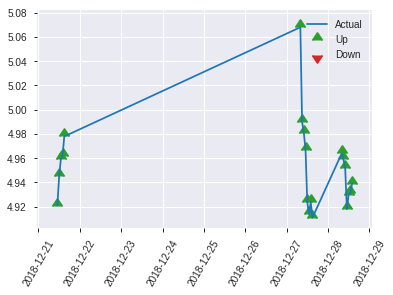


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2838849038265997
RMSE: 0.5328085057753862
LogLoss: 0.8407628948813378
Mean Per-Class Error: 0.3334967320261438
AUC: 0.6654684095860567
pr_auc: 0.7075022709415729
Gini: 0.3309368191721134
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07227803781364563: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      9    76   0.8941   (76.0/85.0)
1      3    105  0.0278   (3.0/108.0)
Total  12   181  0.4093   (79.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.072278     0.726644  180
max f2                       0.00241045   0.865385  191
max f0point5                 0.315444     0.706967  94
max accuracy                 0.315444     0.663212  94
max precision                0.623765     0.9       19
max recall                   0.00241045   1         191
max specificity              0.978872     0.988235  0
max absolute_mcc             0.355717     0.331476  80
max min_per_class_accuracy   0.300439     0.648148  98
max mean_per_class_accuracy  0.315444     0.666503  94

Gains/Lift Table: Avg response rate: 55.96 %, avg score: 33.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.796257           0.893519  0.893519           0.5              0.911528   0.5                         0.911528            0.00925926      0.00925926                 -10.6481  -10.6481
    2        0.0207254                   0.77904            0.893519  0.893519           0.5              0.788762   0.5                         0.850145            0.00925926      0.0185185                  -10.6481  -10.6481
    3        0.0310881                   0.742211           1.78704   1.19136            1                0.77507    0.666667                    0.82512             0.0185185       0.037037                   78.7037   19.1358
    4        0.0414508                   0.720779           1.78704   1.34028            1                0.72752    0.75                        0.80072             0.0185185       0.0555556                  78.7037   34.0278
    5        0.0518135                   0.679689           1.78704   1.42963            1                0.700842   0.8                         0.780745            0.0185185       0.0740741                  78.7037   42.963
    6        0.103627                    0.619344           1.78704   1.60833            1                0.64774    0.9                         0.714242            0.0925926       0.166667                   78.7037   60.8333
    7        0.150259                    0.551251           1.38992   1.54055            0.777778         0.576869   0.862069                    0.671609            0.0648148       0.231481                   38.9918   54.0549
    8        0.202073                    0.513373           0.893519  1.37464            0.5              0.534993   0.769231                    0.636579            0.0462963       0.277778                   -10.6481  37.4644
    9        0.300518                    0.422076           1.31676   1.35568            0.736842         0.468107   0.758621                    0.58139             0.12963         0.407407                   31.6764   35.5683
    10       0.398964                    0.372127           1.31676   1.34608            0.736842         0.392358   0.753247                    0.534746            0.12963         0.537037                   31.6764   34.608
    11       0.502591                    0.30967            0.98287   1.27119            0.55             0.33626    0.71134                     0.493821            0.101852        0.638889                   -1.71296  27.1191
    12       0.601036                    0.259805           0.564327  1.15541            0.315789         0.284014   0.646552                    0.459456            0.0555556       0.694444                   -43.5673  15.5412
    13       0.699482                    0.20848            0.658382  1.08546            0.368421         0.23441    0.607407                    0.427783            0.0648148       0.759259                   -34.1618  8.54595
    14       0.797927                    0.128421           0.752437  1.04437            0.421053         0.172701   0.584416                    0.396312            0.0740741       0.833333                   -24.7563  4.43723
    15       0.896373                    0.0879257          1.0346    1.0433             0.578947         0.106449   0.583815                    0.364477            0.101852        0.935185                   3.46004   4.32991
    16       1                           3.73305e-07        0.625463  1                  0.35             0.0534441  0.559585                   

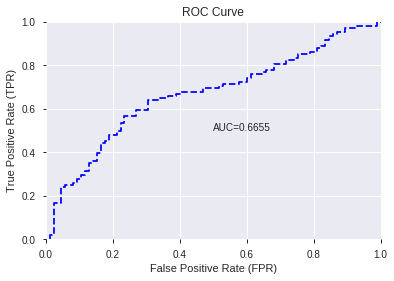

This function is available for GLM models only


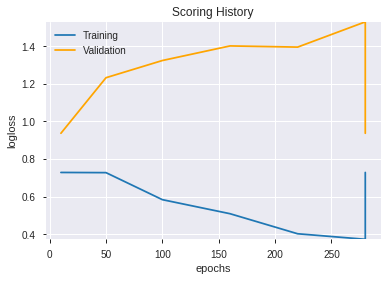

--2019-08-25 14:48:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.88.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.88.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_144238_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_144238_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_9982',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDL3LINESTRIKE',
 'CDLINNECK',
 'CDLGAPSIDESIDEWHITE',
 'CDLEVENINGDOJISTAR',
 'CDLSTALLEDPATTERN',
 'CDL2CROWS',
 'CDL3WHITESOLDIERS',
 'CDLDARKCLOUDCOVER',
 'CDLLADDERBOTTOM',
 'CDLTHRUSTING',
 'day',
 'CDLEVENINGSTAR',
 'HT_TRENDMODE',
 'CDLPIERCING',
 'CDLTASUKIGAP',
 'CDLONNECK',
 'weekday_name',
 'OBV',
 'CDLMORNINGDOJISTAR',
 'hour',
 'days_in_month',
 'ADOSC',
 'BETA_12',
 'aroondown_30',
 'STOCHRSI_fastk',
 'HT_DCPERIOD',
 'DX_8',
 'aroonup_30',
 'aroonup_20',
 'aroondown_8',
 'SAREXT',
 'aroondown_20',
 'aroonup_8',
 'BOP',
 'CDLSHORTLINE',
 'CDLLONGLEGGEDDOJI',
 'dayofweek',
 'aroondown_12',
 'weekday',
 'aroondown_24',
 'CEIL',
 'CDLBELTHOLD',
 'CORREL_8',
 'aroondown_14',
 'CORREL_12',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'CDLADVANCEBLOCK',
 'CDLINVERTEDHAMMER',
 'FLOOR']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_144841_model_1  0.54281  0.700456              0.482353  0.503652  0.253665

variable  relative_importance  scaled_importance  percentage
0                   OBV             0.052888           1.000000    0.054101
1     CDLINVERTEDHAMMER             0.050169           0.948590    0.051320
2       CDLADVANCEBLOCK             0.040047           0.757199    0.040965
3                SAREXT             0.034846           0.658869    0.035645
4        CDL3LINESTRIKE             0.034348           0.649453    0.035136
5             CDLONNECK             0.034107           0.644886    0.034889
6           CDLBELTHOLD             0.034034           0.643503    0.034814
7          HT_TRENDMODE             0.032737           0.618982    0.033487
8                 ADOSC             0.031273           0.591298    0.031990
9           CDLPIERCING             0.030901           0.584281    0.031610
10   CDLEVENINGDOJISTAR             0.030101           0.569149    0.030791
11         aroondown_20             0.029460           0.557021    0.030135
12            CDLINNECK             0.029397           0.555839    0.030071
13             CORREL_8             0.029133           0.550840    0.029801
14         CDLTASUKIGAP             0.025823           0.488264    0.026415
15          HT_DCPERIOD             0.025692           0.485777    0.026281
16    CDL3WHITESOLDIERS             0.024846           0.469786    0.025416
17    CDLSTALLEDPATTERN             0.024628           0.465664    0.025193
18                FLOOR             0.022115           0.418147    0.022622
19                 CEIL             0.022111           0.418063    0.022618
20                 DX_8             0.021779           0.411799    0.022279
21            CDL2CROWS             0.021496           0.406446    0.021989
22         aroondown_14             0.020764           0.392611    0.021241
23      CDLLADDERBOTTOM             0.019793           0.374248    0.020247
24         STOCHF_fastd             0.019252           0.364015    0.019694
25              BETA_12             0.018411           0.348104    0.018833
26           aroonup_20             0.017851           0.337520    0.018260
27            CORREL_12             0.017457           0.330084    0.017858
28         CDLSHORTLINE             0.016372           0.309564    0.016748
29         aroondown_24             0.015636           0.295641    0.015994
30       CDLEVENINGSTAR             0.014539           0.274897    0.014872
31           aroonup_30             0.014265           0.269722    0.014592
32  CDLGAPSIDESIDEWHITE             0.013898           0.262775    0.014216
33         CDLTHRUSTING             0.011938           0.225724    0.012212
34         weekday_name             0.011285           0.213378    0.011544
35       STOCHRSI_fastk             0.011252           0.212761    0.011511
36        days_in_month             0.010778           0.203788    0.011025
37                  BOP             0.010611           0.200630    0.010854
38         aroondown_12             0.010514           0.198790    0.010755
39                  day             0.009220           0.174334    0.009432
40            aroonup_8             0.006804           0.128654    0.006960
41          aroondown_8             0.005971           0.112895    0.006108
42   CDLMORNINGDOJISTAR             0.005039           0.095268    0.005154
43         aroondown_30             0.004390           0.083015    0.004491
44         STOCHF_fastk             0.004027           0.076142    0.004119
45                 hour             0.002398           0.045333    0.002453
46    CDLDARKCLOUDCOVER             0.001486           0.028100    0.001520
47    CDLLONGLEGGEDDOJI             0.001139           0.021542    0.001165
48            dayofweek             0.000281           0.005311    0.000287
49              weekday             0.000280           0.005295    0.000286

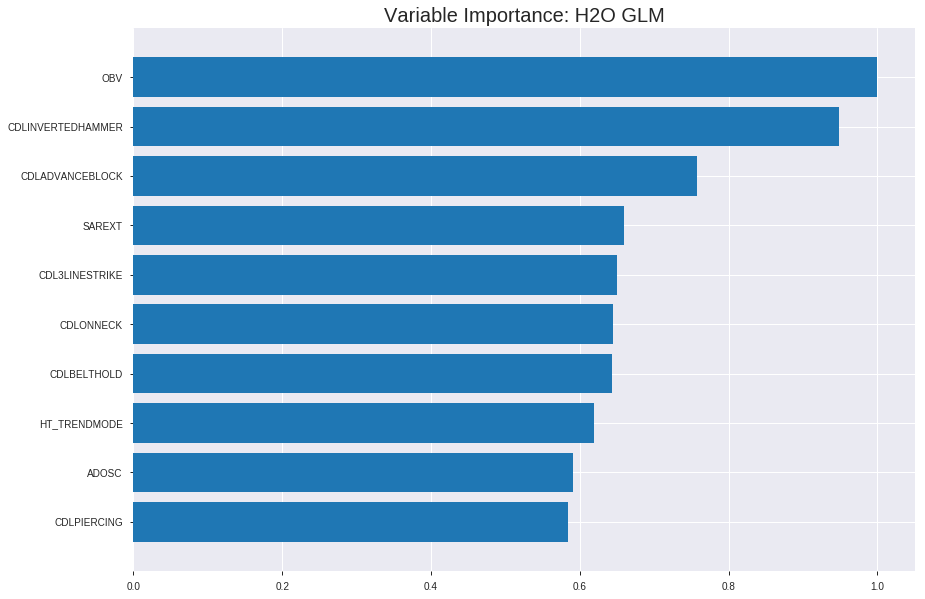

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_144841_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.243799776907225
RMSE: 0.4937608499134222
LogLoss: 0.6804325849993281
Null degrees of freedom: 1345
Residual degrees of freedom: 1295
Null deviance: 1865.9403229770678
Residual deviance: 1831.724518818191
AIC: 1933.724518818191
AUC: 0.5940795937517249
pr_auc: 0.6000139936071259
Gini: 0.18815918750344984
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4267417860315205: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      16   655   0.9762   (655.0/671.0)
1      2    673   0.003    (2.0/675.0)
Total  18   1328  0.4881   (657.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426742     0.671992  383
max f2                       0.419938     0.836431  388
max f0point5                 0.484125     0.58248   264
max accuracy                 0.497344     0.573551  222
max precision                0.760162     1         0
max recall                   0.419938     1         388
max specificity              0.760162     1         0
max absolute_mcc             0.573076     0.151166  40
max min_per_class_accuracy   0.498458     0.564829  217
max mean_per_class_accuracy  0.497344     0.573477  222

Gains/Lift Table: Avg response rate: 50.15 %, avg score: 50.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.630251           1.85164   1.85164            0.928571         0.681504  0.928571                    0.681504            0.0192593       0.0192593                  85.164    85.164
    2        0.0200594                   0.590191           1.68729   1.77251            0.846154         0.605223  0.888889                    0.644776            0.0162963       0.0355556                  68.7293   77.251
    3        0.0304606                   0.578606           1.56677   1.70226            0.785714         0.583843  0.853659                    0.62397             0.0162963       0.0518519                  56.6772   70.2258
    4        0.0401189                   0.569437           1.5339    1.66173            0.769231         0.574341  0.833333                    0.612022            0.0148148       0.0666667                  53.3903   66.1728
    5        0.0505201                   0.565454           1.13947   1.5542             0.571429         0.567135  0.779412                    0.602781            0.0118519       0.0785185                  13.9471   55.4205
    6        0.100297                    0.548831           1.10121   1.32938            0.552239         0.555751  0.666667                    0.57944             0.0548148       0.133333                   10.1205   32.9383
    7        0.150074                    0.536242           1.19049   1.28331            0.597015         0.541477  0.643564                    0.566848            0.0592593       0.192593                   19.0492   28.3315
    8        0.200594                    0.52745            0.850414  1.17429            0.426471         0.531779  0.588889                    0.558016            0.042963        0.235556                   -14.9586  17.4288
    9        0.300149                    0.515998           1.19049   1.17966            0.597015         0.521109  0.591584                    0.545775            0.118519        0.354074                   19.0492   17.9663
    10       0.400446                    0.506344           1.07828   1.15427            0.540741         0.511025  0.57885                     0.537071            0.108148        0.462222                   7.82771   15.4269
    11       0.5                         0.498402           1.04168   1.13185            0.522388         0.502058  0.567608                    0.5301              0.103704        0.565926                   4.16805   13.1852
    12       0.600297                    0.490779           1.00442   1.11056            0.503704         0.495138  0.556931                    0.524258            0.100741        0.666667                   0.44225   11.0561
    13       0.699851                    0.483248           0.967275  1.09018            0.485075         0.487191  0.546709                    0.518985            0.0962963       0.762963                   -3.27253  9.01785
    14       0.800149                    0.473364           0.856713  1.06091            0.42963          0.478649  0.532033                    0.513929            0.0859259       0.848889                   -14.3287  6.09141
    15       0.899703                    0.460363           0.803582  1.03244            0.402985         0.467713  0.517754                    0.508815            0.08            0.928889                   -19.6418  3.24397
    16       1                           0.247324           0.709004  1                  0.355556         0.435738  0.501486                    0.501486           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24767756849020447
RMSE: 0.4976721496027324
LogLoss: 0.6883092357625098
Null degrees of freedom: 383
Residual degrees of freedom: 333
Null deviance: 532.352313052814
Residual deviance: 528.6214930656075
AIC: 630.6214930656075
AUC: 0.5481376990478257
pr_auc: 0.5589797003603764
Gini: 0.09627539809565144
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4492981494561504: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    187  0.9689   (187.0/193.0)
1      2    189  0.0105   (2.0/191.0)
Total  8    376  0.4922   (189.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449298     0.666667  375
max f2                       0.282203     0.831882  383
max f0point5                 0.449298     0.557522  375
max accuracy                 0.523095     0.570312  125
max precision                0.821482     1         0
max recall                   0.282203     1         383
max specificity              0.821482     1         0
max absolute_mcc             0.523095     0.147846  125
max min_per_class_accuracy   0.512708     0.528497  191
max mean_per_class_accuracy  0.523095     0.569419  125

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 51.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.641582           1.50785   1.50785            0.75             0.725415  0.75                        0.725415            0.0157068       0.0157068                  50.7853   50.7853
    2        0.0208333                   0.598192           2.01047   1.75916            1                0.620455  0.875                       0.672935            0.0209424       0.0366492                  101.047   75.9162
    3        0.03125                     0.576864           1.00524   1.50785            0.5              0.586464  0.75                        0.644111            0.0104712       0.0471204                  0.52356   50.7853
    4        0.0416667                   0.569237           1.00524   1.3822             0.5              0.572328  0.6875                      0.626166            0.0104712       0.0575916                  0.52356   38.2199
    5        0.0520833                   0.560222           1.00524   1.30681            0.5              0.563137  0.65                        0.61356             0.0104712       0.0680628                  0.52356   30.6806
    6        0.101562                    0.546261           1.37559   1.34031            0.684211         0.553263  0.666667                    0.584185            0.0680628       0.136126                   37.5586   34.0314
    7        0.151042                    0.539969           0.7407    1.14389            0.368421         0.543006  0.568966                    0.570695            0.0366492       0.172775                   -25.93    14.3889
    8        0.200521                    0.534529           1.16396   1.14884            0.578947         0.536563  0.571429                    0.562273            0.0575916       0.230366                   16.3957   14.8841
    9        0.299479                    0.525233           1.26977   1.1888             0.631579         0.529953  0.591304                    0.551593            0.125654        0.356021                   26.9771   18.88
    10       0.401042                    0.519423           0.773258  1.08357            0.384615         0.52201   0.538961                    0.544101            0.078534        0.434555                   -22.6742  8.35656
    11       0.5                         0.512702           0.952328  1.05759            0.473684         0.515803  0.526042                    0.538501            0.0942408       0.528796                   -4.76715  5.75916
    12       0.598958                    0.506189           0.793607  1.01398            0.394737         0.509542  0.504348                    0.533716            0.078534        0.60733                    -20.6393  1.39768
    13       0.700521                    0.498886           1.18566   1.03887            0.589744         0.502788  0.516729                    0.529232            0.120419        0.727749                   18.5663   3.8868
    14       0.799479                    0.487853           0.7407    1.00196            0.368421         0.493142  0.498371                    0.524765            0.0732984       0.801047                   -25.93    0.196122
    15       0.898438                    0.474168           1.11105   1.01398            0.552632         0.48185   0.504348                    0.520038            0.109948        0.910995                   11.105    1.39768
    16       1                           0.282203           0.876359  1                  0.435897         0.441927  0.497396                    0.512105           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 14:48:41  0.000 sec   2            3.7       50            1.38121           1.38374
    2019-08-25 14:48:41  0.048 sec   4            2.3       51            1.37871           1.38247
    2019-08-25 14:48:41  0.064 sec   6            1.4       51            1.37534           1.38082
    2019-08-25 14:48:41  0.087 sec   8            0.88      51            1.3711            1.379
    2019-08-25 14:48:41  0.112 sec   10           0.55      51            1.36616           1.3774
    2019-08-25 14:48:41  0.141 sec   12           0.34      51            1.36087           1.37662
    2019-08-25 14:48:42  0.167 sec   14           0.21      51            1.35567           1.37727
    2019-08-25 14:48:42  0.191 sec   16           0.13      51            1.35098           1.37971
    2019-08-25 14:48:42  0.214 sec   18           0.082     51            1.34709           1.38392
    2019-08-25 14:48:42  0.233 sec   20           0.051     51            1.34413           1.38955
    2019-08-25 14:48:42  0.249 sec   22           0.031     51            1.34204           1.3961

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5751295336787565)

('F1', 0.7248322147651006)

('auc', 0.5428104575163398)

('logloss', 0.7004556908782082)

('mean_per_class_error', 0.4495098039215686)

('rmse', 0.5036518073129053)

('mse', 0.25366514300955584)

glm prediction progress: |████████████████████████████████████████████████| 100%


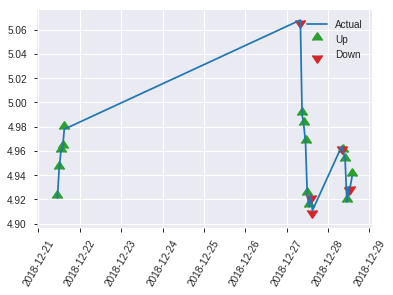


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25366514300955584
RMSE: 0.5036518073129053
LogLoss: 0.7004556908782082
Null degrees of freedom: 192
Residual degrees of freedom: 142
Null deviance: 267.41981442535183
Residual deviance: 270.3758966789884
AIC: 372.3758966789884
AUC: 0.5428104575163398
pr_auc: 0.5818229731413332
Gini: 0.08562091503267966
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.371280443766569: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      3    82   0.9647   (82.0/85.0)
1      0    108  0        (0.0/108.0)
Total  3    190  0.4249   (82.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37128      0.724832  189
max f2                       0.37128      0.868167  189
max f0point5                 0.37128      0.62212   189
max accuracy                 0.37128      0.57513   189
max precision                0.515376     0.677419  30
max recall                   0.37128      1         189
max specificity              0.629506     0.988235  0
max absolute_mcc             0.37128      0.14164   189
max min_per_class_accuracy   0.480116     0.537037  96
max mean_per_class_accuracy  0.473614     0.55049   103

Gains/Lift Table: Avg response rate: 55.96 %, avg score: 47.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.598479           0.893519  0.893519           0.5              0.622004  0.5                         0.622004            0.00925926      0.00925926                 -10.6481  -10.6481
    2        0.0207254                   0.568597           0         0.446759           0                0.588232  0.25                        0.605118            0               0.00925926                 -100      -55.3241
    3        0.0310881                   0.549115           1.78704   0.893519           1                0.559042  0.5                         0.589759            0.0185185       0.0277778                  78.7037   -10.6481
    4        0.0414508                   0.542803           0         0.670139           0                0.545904  0.375                       0.578795            0               0.0277778                  -100      -32.9861
    5        0.0518135                   0.537807           1.78704   0.893519           1                0.541308  0.5                         0.571298            0.0185185       0.0462963                  78.7037   -10.6481
    6        0.103627                    0.519731           1.25093   1.07222            0.7              0.526523  0.6                         0.548911            0.0648148       0.111111                   25.0926   7.22222
    7        0.150259                    0.515677           1.38992   1.17082            0.777778         0.517285  0.655172                    0.539096            0.0648148       0.175926                   38.9918   17.0817
    8        0.202073                    0.507651           1.25093   1.19136            0.7              0.510742  0.666667                    0.531826            0.0648148       0.240741                   25.0926   19.1358
    9        0.300518                    0.49464            0.940546  1.1092             0.526316         0.498935  0.62069                     0.521051            0.0925926       0.333333                   -5.94542  10.9195
    10       0.398964                    0.488172           0.940546  1.06758            0.526316         0.491197  0.597403                    0.513684            0.0925926       0.425926                   -5.94542  6.75806
    11       0.502591                    0.480116           1.07222   1.06854            0.6              0.483851  0.597938                    0.507533            0.111111        0.537037                   7.22222   6.85376
    12       0.601036                    0.467256           0.846491  1.03217            0.473684         0.47241   0.577586                    0.50178             0.0833333       0.62037                    -15.3509  3.21679
    13       0.699482                    0.45039            0.846491  1.00604            0.473684         0.460589  0.562963                    0.495983            0.0833333       0.703704                   -15.3509  0.603567
    14       0.797927                    0.429822           1.0346    1.00956            0.578947         0.439318  0.564935                    0.488992            0.101852        0.805556                   3.46004   0.955988
    15       0.896373                    0.410539           1.0346    1.01231            0.578947         0.420171  0.566474                    0.481433            0.101852        0.907407                   3.46004   1.231
    16       1                           0.235846           0.893519  1                  0.5              0.381185  0.559585                    0.471045    

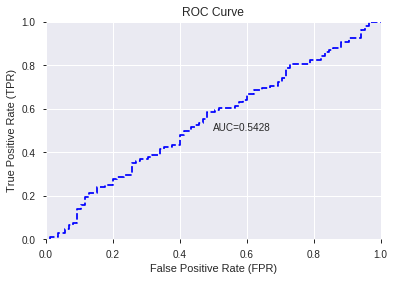

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


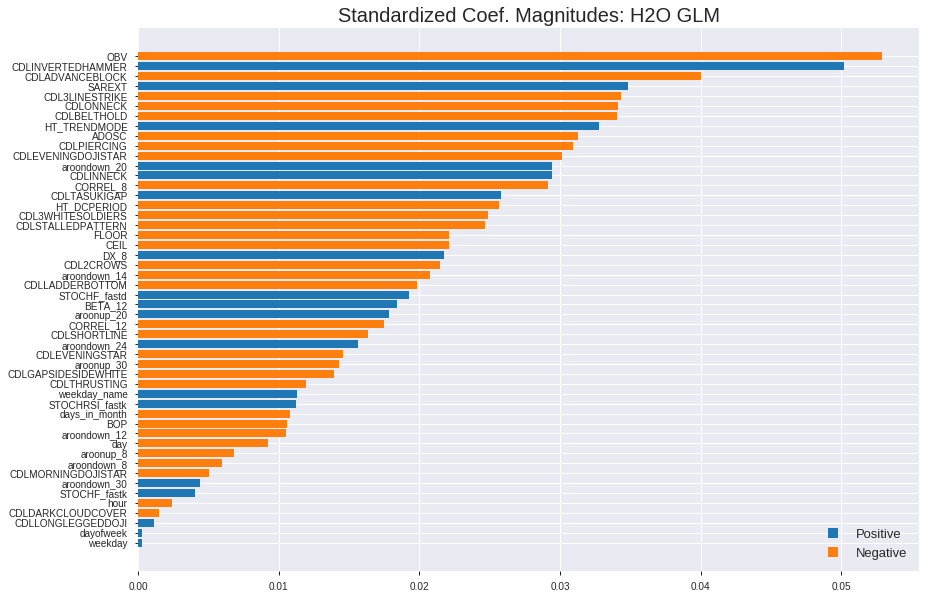

'log_likelihood'
--2019-08-25 14:48:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.144.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.144.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_144841_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_144841_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_9982',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['OBV',
 'CDLINVERTEDHAMMER',
 'CDLADVANCEBLOCK',
 'SAREXT',
 'CDL3LINESTRIKE',
 'CDLONNECK',
 'CDLBELTHOLD',
 'HT_TRENDMODE',
 'ADOSC',
 'CDLPIERCING',
 'CDLEVENINGDOJISTAR',
 'aroondown_20',
 'CDLINNECK',
 'CORREL_8',
 'CDLTASUKIGAP',
 'HT_DCPERIOD',
 'CDL3WHITESOLDIERS',
 'CDLSTALLEDPATTERN',
 'FLOOR',
 'CEIL',
 'DX_8',
 'CDL2CROWS',
 'aroondown_14',
 'CDLLADDERBOTTOM',
 'STOCHF_fastd',
 'BETA_12',
 'aroonup_20',
 'CORREL_12',
 'CDLSHORTLINE',
 'aroondown_24',
 'CDLEVENINGSTAR',
 'aroonup_30',
 'CDLGAPSIDESIDEWHITE',
 'CDLTHRUSTING',
 'weekday_name',
 'STOCHRSI_fastk',
 'days_in_month',
 'BOP',
 'aroondown_12',
 'day',
 'aroonup_8',
 'aroondown_8',
 'CDLMORNINGDOJISTAR',
 'aroondown_30',
 'STOCHF_fastk',
 'hour',
 'CDLDARKCLOUDCOVER',
 'CDLLONGLEGGEDDOJI',
 'dayofweek',
 'weekday']

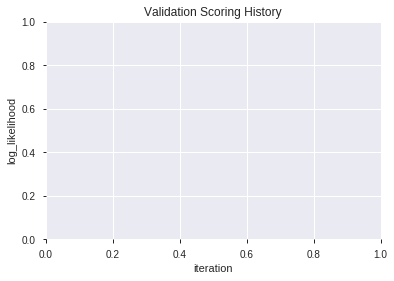

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_144856_model_1  0.611874  0.703049              0.500000  0.503808  0.253822
1  XGBoost_grid_1_AutoML_20190825_144856_model_7  0.593900  0.714786              0.494118  0.509494  0.259584
2  XGBoost_grid_1_AutoML_20190825_144856_model_4  0.585839  0.695951              0.400871  0.501432  0.251434
3  XGBoost_grid_1_AutoML_20190825_144856_model_3  0.575708  0.720404              0.500000  0.511730  0.261868
4               XGBoost_3_AutoML_20190825_144856  0.572440  0.712325              0.500000  0.508372  0.258442
5               XGBoost_2_AutoML_20190825_144856  0.564706  0.708305              0.464706  0.507295  0.257348
6  XGBoost_grid_1_AutoML_20190825_144856_model_2  0.562636  0.696195              0.465577  0.501455  0.251457
7               XGBoost_1_AutoML_20190825_144856  0.553486  0.717278              0.500000  0.510998  0.261119
8  XGBoost_grid_1_AutoML_20190825_144856_model_6  0.550763  0.721988              0.444172  0.513268  0.263444
9  XGBoost_grid_1_AutoML_20190825_144856_model_5  0.548257  0.727976              0.500000  0.515116  0.265344

variable  relative_importance  scaled_importance  percentage
0                 OBV           345.741669           1.000000    0.092751
1        STOCHF_fastd           310.178772           0.897140    0.083211
2              SAREXT           270.627930           0.782746    0.072601
3                DX_8           247.804672           0.716734    0.066478
4                 BOP           240.480850           0.695551    0.064513
5         HT_DCPERIOD           196.244766           0.567605    0.052646
6           CORREL_12           195.877625           0.566543    0.052548
7             BETA_12           192.796753           0.557632    0.051721
8               ADOSC           172.198029           0.498054    0.046195
9      STOCHRSI_fastk           166.814728           0.482484    0.044751
10       aroondown_30           166.343903           0.481122    0.044625
11         aroonup_30           153.773880           0.444765    0.041252
12           CORREL_8           130.882019           0.378554    0.035111
13       STOCHF_fastk           120.975151           0.349900    0.032454
14       aroondown_20           108.171646           0.312868    0.029019
15          aroonup_8            78.225044           0.226253    0.020985
16       aroondown_24            75.039757           0.217040    0.020131
17                day            68.121864           0.197031    0.018275
18       aroondown_14            65.332779           0.188964    0.017527
19       HT_TRENDMODE            64.302742           0.185985    0.017250
20         aroonup_20            58.524937           0.169274    0.015700
21               hour            58.009869           0.167784    0.015562
22          dayofweek            51.351627           0.148526    0.013776
23        aroondown_8            44.898014           0.129860    0.012045
24       aroondown_12            41.350723           0.119600    0.011093
25        CDLBELTHOLD            35.012695           0.101268    0.009393
26       weekday_name            23.602100           0.068265    0.006332
27      days_in_month            18.684387           0.054041    0.005012
28            weekday            14.218983           0.041126    0.003814
29       CDLSHORTLINE             8.428884           0.024379    0.002261
30  CDLLONGLEGGEDDOJI             3.609065           0.010439    0.000968

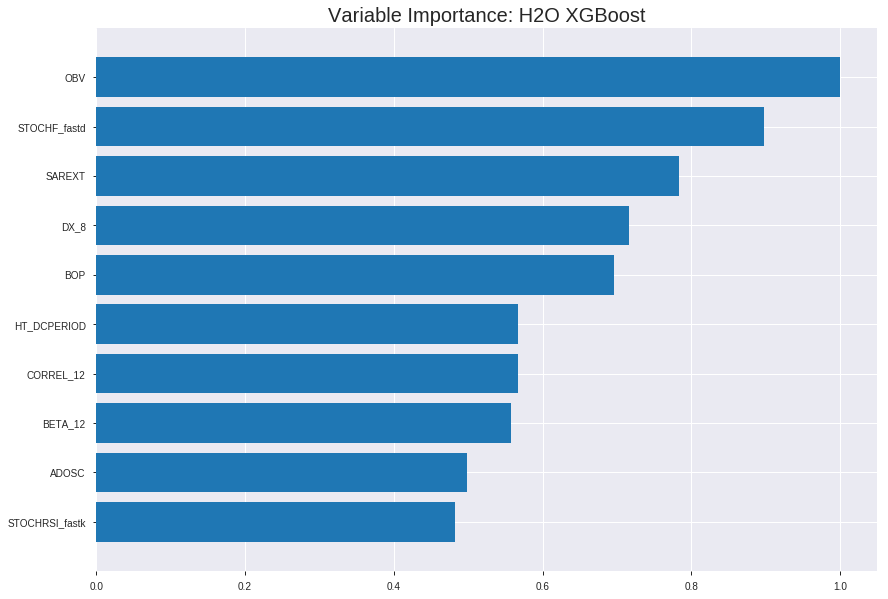

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_144856_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18454764725934278
RMSE: 0.42959009213358584
LogLoss: 0.5583970023273342
Mean Per-Class Error: 0.1425843130761164
AUC: 0.923539217309709
pr_auc: 0.9215228136656322
Gini: 0.847078434619418
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5134549617767334: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      589  82   0.1222   (82.0/671.0)
1      110  565  0.163    (110.0/675.0)
Total  699  647  0.1426   (192.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.513455     0.854766  189
max f2                       0.455373     0.902623  244
max f0point5                 0.533877     0.871512  168
max accuracy                 0.513455     0.857355  189
max precision                0.785686     1         0
max recall                   0.32734      1         355
max specificity              0.785686     1         0
max absolute_mcc             0.513455     0.715362  189
max min_per_class_accuracy   0.509409     0.851852  194
max mean_per_class_accuracy  0.513455     0.857416  189

Gains/Lift Table: Avg response rate: 50.15 %, avg score: 50.14 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.725405           1.99407    1.99407            1                0.746766  1                           0.746766            0.0207407       0.0207407                  99.4074   99.4074
    2        0.0200594                   0.705617           1.99407    1.99407            1                0.715952  1                           0.73193             0.0192593       0.04                       99.4074   99.4074
    3        0.0304606                   0.696757           1.99407    1.99407            1                0.702112  1                           0.721748            0.0207407       0.0607407                  99.4074   99.4074
    4        0.0401189                   0.682205           1.99407    1.99407            1                0.688543  1                           0.713754            0.0192593       0.08                       99.4074   99.4074
    5        0.0505201                   0.673628           1.99407    1.99407            1                0.678292  1                           0.706453            0.0207407       0.100741                   99.4074   99.4074
    6        0.100297                    0.639578           1.96431    1.9793             0.985075         0.656866  0.992593                    0.681843            0.0977778       0.198519                   96.4312   97.9303
    7        0.150074                    0.617574           1.84526    1.93484            0.925373         0.628143  0.970297                    0.664032            0.0918519       0.29037                    84.5263   93.4844
    8        0.200594                    0.596717           1.93542    1.93499            0.970588         0.607025  0.97037                     0.649675            0.0977778       0.388148                   93.5425   93.499
    9        0.300149                    0.564568           1.75598    1.87561            0.880597         0.579948  0.940594                    0.626547            0.174815        0.562963                   75.5976   87.5614
    10       0.400446                    0.539575           1.6248     1.81279            0.814815         0.551663  0.909091                    0.607792            0.162963        0.725926                   62.4801   81.2795
    11       0.5                         0.509129           1.25002    1.70074            0.626866         0.52366   0.852897                    0.59104             0.124444        0.85037                    25.0017   70.0741
    12       0.600297                    0.475869           0.709004   1.53504            0.355556         0.493853  0.769802                    0.574802            0.0711111       0.921481                   -29.0996  53.5042
    13       0.699851                    0.441905           0.476197   1.38442            0.238806         0.458482  0.694268                    0.558256            0.0474074       0.968889                   -52.3803  38.4421
    14       0.800149                    0.402383           0.206793   1.23681            0.103704         0.423287  0.620241                    0.541338            0.0207407       0.98963                    -79.3207  23.6807
    15       0.899703                    0.348402           0.0595246  1.10654            0.0298507        0.376295  0.554913                    0.523075            0.00592593      0.995556                   -94.0475  10.6538
    16       1                           0.18756            0.0443128  1                  0.0222222        0.307426  0.501486                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25349176121020944
RMSE: 0.5034796532236525
LogLoss: 0.7007982968110261
Mean Per-Class Error: 0.45443941079130834
AUC: 0.5415999782980224
pr_auc: 0.5259132563539415
Gini: 0.08319995659604484
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3399016559123993: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   180  0.9326   (180.0/193.0)
1      2    189  0.0105   (2.0/191.0)
Total  15   369  0.474    (182.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.339902     0.675     368
max f2                       0.320818     0.834798  373
max f0point5                 0.339902     0.566887  368
max accuracy                 0.6067       0.546875  94
max precision                0.669586     0.636364  21
max recall                   0.296795     1         380
max specificity              0.807673     0.994819  0
max absolute_mcc             0.339902     0.146806  368
max min_per_class_accuracy   0.543313     0.523316  191
max mean_per_class_accuracy  0.6067       0.545561  94

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 53.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.736429           1.00524   1.00524            0.5              0.769923  0.5                         0.769923            0.0104712       0.0104712                  0.52356   0.52356
    2        0.0208333                   0.710019           0.502618  0.753927           0.25             0.725265  0.375                       0.747594            0.0052356       0.0157068                  -49.7382  -24.6073
    3        0.03125                     0.69709            1.50785   1.00524            0.75             0.704034  0.5                         0.733074            0.0157068       0.0314136                  50.7853   0.52356
    4        0.0416667                   0.684908           1.50785   1.13089            0.75             0.689998  0.5625                      0.722305            0.0157068       0.0471204                  50.7853   13.089
    5        0.0520833                   0.674744           1.50785   1.20628            0.75             0.679409  0.6                         0.713726            0.0157068       0.0628272                  50.7853   20.6283
    6        0.101562                    0.64797            0.846514  1.03101            0.421053         0.659559  0.512821                    0.687337            0.0418848       0.104712                   -15.3486  3.10109
    7        0.151042                    0.629928           1.16396   1.07456            0.578947         0.637458  0.534483                    0.670997            0.0575916       0.162304                   16.3957   7.45622
    8        0.200521                    0.616234           1.37559   1.14884            0.684211         0.624437  0.571429                    0.659508            0.0680628       0.230366                   37.5586   14.8841
    9        0.299479                    0.594588           1.05814   1.11887            0.526316         0.605477  0.556522                    0.641654            0.104712        0.335079                   5.81427   11.8871
    10       0.401042                    0.566991           0.92791   1.07051            0.461538         0.580687  0.532468                    0.626215            0.0942408       0.429319                   -7.20902  7.05106
    11       0.5                         0.54311            0.952328  1.04712            0.473684         0.553868  0.520833                    0.611896            0.0942408       0.52356                    -4.76715  4.71204
    12       0.598958                    0.511752           1.11105   1.05768            0.552632         0.527225  0.526087                    0.597907            0.109948        0.633508                   11.105    5.76827
    13       0.700521                    0.489842           0.97946   1.04634            0.487179         0.500013  0.520446                    0.583714            0.0994764       0.732984                   -2.05397  4.63419
    14       0.799479                    0.447647           0.846514  1.02161            0.421053         0.470339  0.508143                    0.569681            0.0837696       0.816754                   -15.3486  2.16075
    15       0.898438                    0.405558           0.793607  0.996494           0.394737         0.431869  0.495652                    0.554501            0.078534        0.895288                   -20.6393  -0.350558
    16       1                           0.249103           1.03101   1                  0.512821         0.350829  0.497396                    0.533816       


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 14:49:02  0.024 sec   0                  0.5              0.693147            0.5             0                  1                0.498514                         0.5                0.693147              0.5               0                    1                  0.502604
    2019-08-25 14:49:02  0.142 sec   5                  0.490546         0.674369            0.714232        0.713843           1.80416          0.397474                         0.500068           0.69328               0.525432          0.535401             1.00524            0.502604
    2019-08-25 14:49:02  0.202 sec   10                 0.482336         0.65826             0.771186        0.768029           1.99407          0.311293                         0.499833           0.692797              0.539986          0.540877             1.00524            0.492188
    2019-08-25 14:49:02  0.283 sec   15                 0.475123         0.644229            0.807506        0.803717           1.99407          0.274146                         0.499126           0.691389              0.556032          0.545922             1.00524            0.489583
    2019-08-25 14:49:02  0.353 sec   20                 0.467263         0.629039            0.832434        0.827606           1.99407          0.244428                         0.498461           0.690063              0.565391          0.562914             0.502618           0.489583
    2019-08-25 14:49:02  0.432 sec   25                 0.459033         0.613324            0.863295        0.860623           1.99407          0.235513                         0.498786           0.69076               0.563478          0.555849             0.502618           0.486979
    2019-08-25 14:49:02  0.500 sec   30                 0.4531           0.602061            0.87722         0.87294            1.99407          0.203566                         0.500192           0.693663              0.553292          0.544663             0.502618           0.486979
    2019-08-25 14:49:02  0.579 sec   35                 0.44713          0.590857            0.893469        0.890872           1.99407          0.192422                         0.50035            0.694031              0.552695          0.543146             0.502618           0.476562
    2019-08-25 14:49:02  0.658 sec   40                 0.440875         0.579228            0.906417        0.903267           1.99407          0.180535                         0.501565           0.696658              0.547025          0.534596             0.502618           0.473958
    2019-08-25 14:49:03  0.745 sec   45                 0.434743         0.567793            0.913028        0.909564           1.99407          0.161218                         0.503206           0.70017               0.540569          0.52549              0.502618           0.476562
    2019-08-25 14:49:03  0.822 sec   50                 0.42959          0.558397            0.923539        0.921523           1.99407          0.142645                         0.50348            0.700798              0.5416            0.525913             1.00524            0.473958

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
OBV                345.7416687011719      1.0                   0.09275117233104135
STOCHF_fastd       310.17877197265625     0.897140264110737     0.08321081124165092
SAREXT             270.6279296875         0.7827460621224875    0.07260061489936685
DX_8               247.80467224121094     0.7167336039422865    0.06647788201469935
BOP                240.48085021972656     0.6955506726253949    0.06451314030164974
---                ---                    ---                   ---
weekday_name       23.602100372314453     0.06826513119167593   0.006331670947360281
days_in_month      18.68438720703125      0.05404146765769318   0.005012409479741098
weekday            14.218982696533203     0.04112603132260236   0.0038144876184944966
CDLSHORTLINE       8.42888355255127       0.024379137129220144  0.0022611935491543868
CDLLONGLEGGEDDOJI  3.609064817428589      0.010438616875387217  0.0009681939527067562


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6269430051813472)

('F1', 0.717607973421927)

('auc', 0.6118736383442266)

('logloss', 0.7030487838754524)

('mean_per_class_error', 0.3709150326797386)

('rmse', 0.5038078343701194)

('mse', 0.2538223339727097)

xgboost prediction progress: |████████████████████████████████████████████| 100%


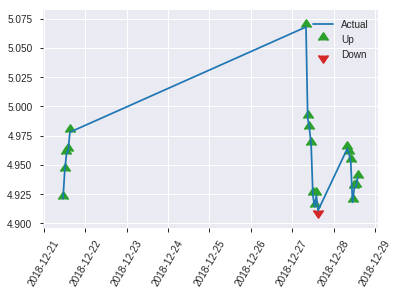


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2538223339727097
RMSE: 0.5038078343701194
LogLoss: 0.7030487838754524
Mean Per-Class Error: 0.3709150326797386
AUC: 0.6118736383442266
pr_auc: 0.6334605097435584
Gini: 0.22374727668845318
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20924228429794312: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      0    85   1        (85.0/85.0)
1      0    108  0        (0.0/108.0)
Total  0    193  0.4404   (85.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.209242     0.717608  192
max f2                       0.209242     0.864     192
max f0point5                 0.451495     0.670732  95
max accuracy                 0.451495     0.626943  95
max precision                0.732928     1         0
max recall                   0.209242     1         192
max specificity              0.732928     1         0
max absolute_mcc             0.451495     0.256334  95
max min_per_class_accuracy   0.446035     0.623529  99
max mean_per_class_accuracy  0.451495     0.629085  95

Gains/Lift Table: Avg response rate: 55.96 %, avg score: 44.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.707122           1.78704   1.78704            1                0.725533  1                           0.725533            0.0185185       0.0185185                  78.7037   78.7037
    2        0.0207254                   0.695277           0         0.893519           0                0.702918  0.5                         0.714226            0               0.0185185                  -100      -10.6481
    3        0.0310881                   0.685541           1.78704   1.19136            1                0.690969  0.666667                    0.706473            0.0185185       0.037037                   78.7037   19.1358
    4        0.0414508                   0.679091           1.78704   1.34028            1                0.684578  0.75                        0.701               0.0185185       0.0555556                  78.7037   34.0278
    5        0.0518135                   0.668385           0         1.07222            0                0.675538  0.6                         0.695907            0               0.0555556                  -100      7.22222
    6        0.103627                    0.606924           1.07222   1.07222            0.6              0.626831  0.6                         0.661369            0.0555556       0.111111                   7.22222   7.22222
    7        0.150259                    0.564374           1.38992   1.17082            0.777778         0.582573  0.655172                    0.636915            0.0648148       0.175926                   38.9918   17.0817
    8        0.202073                    0.540728           1.25093   1.19136            0.7              0.554515  0.666667                    0.615787            0.0648148       0.240741                   25.0926   19.1358
    9        0.300518                    0.498089           1.0346    1.14001            0.578947         0.516471  0.637931                    0.583252            0.101852        0.342593                   3.46004   14.0006
    10       0.398964                    0.465552           1.41082   1.20683            0.789474         0.4834    0.675325                    0.558614            0.138889        0.481481                   41.0819   20.683
    11       0.502591                    0.451247           1.25093   1.21592            0.7              0.458371  0.680412                    0.537945            0.12963         0.611111                   25.0926   21.5922
    12       0.601036                    0.42916            0.846491  1.15541            0.473684         0.438394  0.646552                    0.521639            0.0833333       0.694444                   -15.3509  15.5412
    13       0.699482                    0.377063           0.846491  1.11193            0.473684         0.400417  0.622222                    0.504578            0.0833333       0.777778                   -15.3509  11.1934
    14       0.797927                    0.341919           0.658382  1.05598            0.368421         0.359953  0.590909                    0.486735            0.0648148       0.842593                   -34.1618  5.59764
    15       0.896373                    0.294716           0.470273  0.991651           0.263158         0.322103  0.554913                    0.468654            0.0462963       0.888889                   -52.9727  -0.834939
    16       1                           0.209242           1.07222   1                  0.6              0.25503   0.559585                    0.446517       

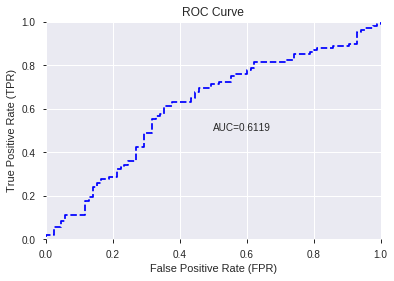

This function is available for GLM models only


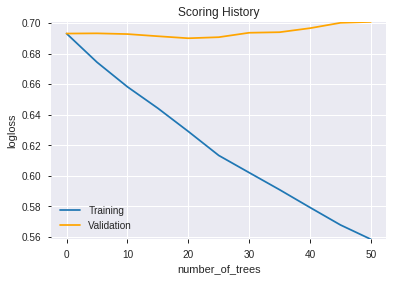

--2019-08-25 14:49:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.21.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.21.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.co

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_144856_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_144856_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_9982',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['OBV',
 'STOCHF_fastd',
 'SAREXT',
 'DX_8',
 'BOP',
 'HT_DCPERIOD',
 'CORREL_12',
 'BETA_12',
 'ADOSC',
 'STOCHRSI_fastk',
 'aroondown_30',
 'aroonup_30',
 'CORREL_8',
 'STOCHF_fastk',
 'aroondown_20',
 'aroonup_8',
 'aroondown_24',
 'day',
 'aroondown_14',
 'HT_TRENDMODE',
 'aroonup_20',
 'hour',
 'dayofweek',
 'aroondown_8',
 'aroondown_12',
 'CDLBELTHOLD',
 'weekday_name',
 'days_in_month',
 'weekday',
 'CDLSHORTLINE',
 'CDLLONGLEGGEDDOJI']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse      mse
0  GLM_grid_1_AutoML_20190825_144926_model_1  0.582462  0.759596              0.472712  0.53114  0.28211

variable  relative_importance  scaled_importance    percentage
0          CDLXSIDEGAP3METHODS         8.372129e-03           1.000000  1.305836e-02
1            CDLINVERTEDHAMMER         7.370318e-03           0.880340  1.149580e-02
2                CDLHANGINGMAN         5.996997e-03           0.716305  9.353769e-03
3              CDLADVANCEBLOCK         5.907946e-03           0.705668  9.214873e-03
4                          OBV         5.457818e-03           0.651903  8.512789e-03
...                        ...                  ...                ...           ...
1033   BBANDS_middleband_8_5_2         1.174823e-06           0.000140  1.832422e-06
1034  BBANDS_middleband_20_1_4         9.340098e-07           0.000112  1.456815e-06
1035                   MA_20_6         6.660836e-07           0.000080  1.038919e-06
1036  BBANDS_middleband_20_6_3         3.133592e-07           0.000037  4.887595e-07
1037    LINEARREG_INTERCEPT_20         1.163271e-07           0.000014  1.814403e-07

[1038 rows x 4 columns]

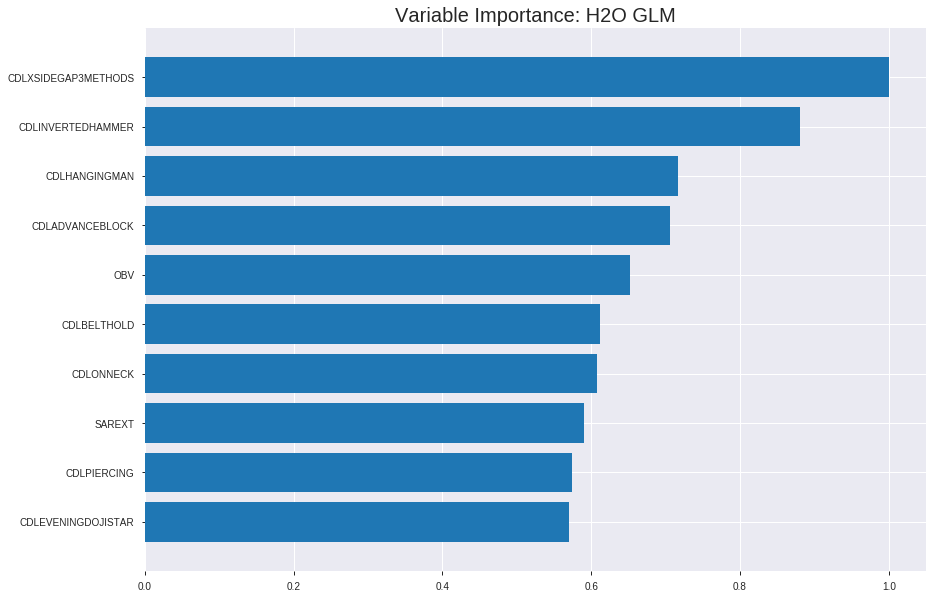

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_144926_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24661529128689116
RMSE: 0.4966037568191477
LogLoss: 0.6863508854406474
Null degrees of freedom: 1345
Residual degrees of freedom: 307
Null deviance: 1865.9403229770678
Residual deviance: 1847.6565836062227
AIC: 3925.6565836062227
AUC: 0.5755676988463874
pr_auc: 0.5723139847209038
Gini: 0.15113539769277473
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4418848324337508: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      20   651   0.9702   (651.0/671.0)
1      4    671   0.0059   (4.0/675.0)
Total  24   1322  0.4866   (655.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.441885     0.672008  382
max f2                       0.431273     0.835189  394
max f0point5                 0.470385     0.576349  303
max accuracy                 0.516916     0.554235  148
max precision                0.577288     0.875     5
max recall                   0.431273     1         394
max specificity              0.590676     0.99851   0
max absolute_mcc             0.470385     0.127724  303
max min_per_class_accuracy   0.501084     0.546945  202
max mean_per_class_accuracy  0.516916     0.554756  148

Gains/Lift Table: Avg response rate: 50.15 %, avg score: 50.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104012                   0.57118            1.56677   1.56677            0.785714         0.578622  0.785714                    0.578622            0.0162963       0.0162963                  56.6772    56.6772
    2        0.0200594                   0.566472           1.68729   1.6248             0.846154         0.569435  0.814815                    0.574198            0.0162963       0.0325926                  68.7293    62.4801
    3        0.0304606                   0.56268            0.997037  1.41044            0.5              0.564358  0.707317                    0.570838            0.0103704       0.042963                   -0.296296  41.0443
    4        0.0401189                   0.559752           1.68729   1.47709            0.846154         0.56108   0.740741                    0.568489            0.0162963       0.0592593                  68.7293    47.7092
    5        0.0505201                   0.55724            1.13947   1.40758            0.571429         0.558209  0.705882                    0.566373            0.0118519       0.0711111                  13.9471    40.7582
    6        0.100297                    0.549862           1.10121   1.25553            0.552239         0.5537    0.62963                     0.560083            0.0548148       0.125926                   10.1205    25.5528
    7        0.150074                    0.539496           0.892869  1.13524            0.447761         0.544453  0.569307                    0.554899            0.0444444       0.17037                    -10.7131   13.524
    8        0.200594                    0.529315           1.17298   1.14475            0.588235         0.534299  0.574074                    0.549711            0.0592593       0.22963                    17.2985    14.4746
    9        0.300149                    0.518624           1.16073   1.15005            0.58209          0.523796  0.576733                    0.541115            0.115556        0.345185                   16.073     15.0048
    10       0.400446                    0.509628           1.00442   1.11357            0.503704         0.514158  0.558442                    0.534363            0.100741        0.445926                   0.44225    11.3574
    11       0.5                         0.501282           1.01192   1.09333            0.507463         0.505517  0.548291                    0.52862             0.100741        0.546667                   1.19182    9.33333
    12       0.600297                    0.491389           0.989652  1.07601            0.496296         0.496642  0.539604                    0.523277            0.0992593       0.645926                   -1.03484   7.60103
    13       0.699851                    0.480571           0.982156  1.06266            0.492537         0.486081  0.532909                    0.517986            0.0977778       0.743704                   -1.78441   6.26594
    14       0.800149                    0.47057            1.01919   1.05721            0.511111         0.475228  0.530176                    0.512626            0.102222        0.845926                   1.91934    5.7211
    15       0.899703                    0.459729           0.848226  1.03409            0.425373         0.465704  0.51858                     0.507434            0.0844444       0.93037                    -15.1774   3.40863
    16       1                           0.414065           0.694233  1                  0.348148         0.448128  0.501486                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24879933577964897
RMSE: 0.49879789071291086
LogLoss: 0.6906723210615926
Null degrees of freedom: 383
Residual degrees of freedom: -655
Null deviance: 532.352313052814
Residual deviance: 530.436342575303
AIC: 2608.436342575303
AUC: 0.530369204893796
pr_auc: 0.5408829910774335
Gini: 0.06073840978759204
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40672079802778266: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    185  0.9585   (185.0/193.0)
1      1    190  0.0052   (1.0/191.0)
Total  9    375  0.4844   (186.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.406721     0.671378  374
max f2                       0.379461     0.83479   379
max f0point5                 0.418099     0.564663  363
max accuracy                 0.525414     0.544271  45
max precision                0.536874     0.791667  23
max recall                   0.379461     1         379
max specificity              0.613013     0.994819  0
max absolute_mcc             0.536874     0.151963  23
max min_per_class_accuracy   0.497265     0.507772  191
max mean_per_class_accuracy  0.525414     0.542292  45

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 48.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.55337            1.50785   1.50785            0.75             0.57101   0.75                        0.57101             0.0157068       0.0157068                  50.7853   50.7853
    2        0.0208333                   0.54921            1.00524   1.25654            0.5              0.551816  0.625                       0.561413            0.0104712       0.026178                   0.52356   25.6545
    3        0.03125                     0.545069           1.50785   1.34031            0.75             0.546612  0.666667                    0.556479            0.0157068       0.0418848                  50.7853   34.0314
    4        0.0416667                   0.542114           1.50785   1.3822             0.75             0.543513  0.6875                      0.553238            0.0157068       0.0575916                  50.7853   38.2199
    5        0.0520833                   0.540577           2.01047   1.50785            1                0.540908  0.75                        0.550772            0.0209424       0.078534                   101.047   50.7853
    6        0.101562                    0.528245           1.26977   1.39186            0.631579         0.532648  0.692308                    0.541943            0.0628272       0.141361                   26.9771   39.1865
    7        0.151042                    0.522293           0.7407    1.17855            0.368421         0.524933  0.586207                    0.536371            0.0366492       0.17801                    -25.93    17.8552
    8        0.200521                    0.518872           0.846514  1.09662            0.421053         0.520529  0.545455                    0.532462            0.0418848       0.219895                   -15.3486  9.66207
    9        0.299479                    0.510644           0.846514  1.01398            0.421053         0.514112  0.504348                    0.526398            0.0837696       0.303665                   -15.3486  1.39768
    10       0.401042                    0.504402           1.13411   1.0444             0.564103         0.507431  0.519481                    0.521595            0.115183        0.418848                   13.4112   4.44006
    11       0.5                         0.49725            0.899421  1.01571            0.447368         0.500859  0.505208                    0.517491            0.0890052       0.507853                   -10.0579  1.57068
    12       0.598958                    0.488324           1.05814   1.02272            0.526316         0.493131  0.508696                    0.513466            0.104712        0.612565                   5.81427   2.2718
    13       0.700521                    0.474626           1.03101   1.02392            0.512821         0.482557  0.509294                    0.508985            0.104712        0.717277                   3.10109   2.39203
    14       0.799479                    0.45082            1.00524   1.02161            0.5              0.465425  0.508143                    0.503593            0.0994764       0.816754                   0.52356   2.16075
    15       0.898438                    0.424327           1.05814   1.02563            0.526316         0.434456  0.510145                    0.495978            0.104712        0.921466                   5.81427   2.56317
    16       1                           0.309612           0.773258  1                  0.384615         0.407961  0.497396                    0.487039          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 14:49:29  0.000 sec   2            3.7       1039          1.3727            1.38134
    2019-08-25 14:49:30  1.337 sec   4            2.7       1039          1.36977           1.38141
    2019-08-25 14:49:32  2.686 sec   6            2         1039          1.36616           1.38204
    2019-08-25 14:49:33  4.047 sec   8            1.4       1039          1.36179           1.38371
    2019-08-25 14:49:34  5.384 sec   10           1         1039          1.35662           1.38694
    2019-08-25 14:49:36  6.744 sec   12           0.75      1039          1.35066           1.39245

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5854922279792746)

('F1', 0.7216494845360824)

('auc', 0.5824618736383442)

('logloss', 0.7595958798420537)

('mean_per_class_error', 0.418082788671024)

('rmse', 0.5311404655042601)

('mse', 0.28211019409608207)

glm prediction progress: |████████████████████████████████████████████████| 100%


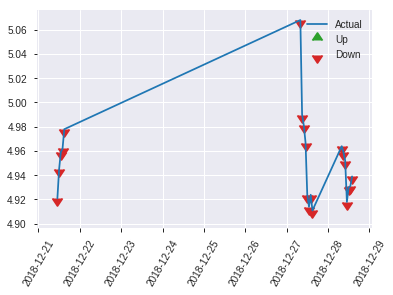


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.28211019409608207
RMSE: 0.5311404655042601
LogLoss: 0.7595958798420537
Null degrees of freedom: 192
Residual degrees of freedom: -846
Null deviance: 267.41981442535183
Residual deviance: 293.20400961903266
AIC: 2371.2040096190326
AUC: 0.5824618736383442
pr_auc: 0.6346571751262792
Gini: 0.16492374727668846
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31962022993843014: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      7    78   0.9176   (78.0/85.0)
1      3    105  0.0278   (3.0/108.0)
Total  10   183  0.4197   (81.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.31962      0.721649  182
max f2                       0.311849     0.865385  191
max f0point5                 0.358309     0.629371  115
max accuracy                 0.358309     0.585492  115
max precision                0.424754     1         0
max recall                   0.311849     1         191
max specificity              0.424754     1         0
max absolute_mcc             0.373723     0.168432  64
max min_per_class_accuracy   0.364135     0.564815  96
max mean_per_class_accuracy  0.370593     0.581917  78

Gains/Lift Table: Avg response rate: 55.96 %, avg score: 36.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.421472           1.78704   1.78704            1                0.423161  1                           0.423161            0.0185185       0.0185185                  78.7037   78.7037
    2        0.0207254                   0.418227           0.893519  1.34028            0.5              0.420615  0.75                        0.421888            0.00925926      0.0277778                  -10.6481  34.0278
    3        0.0310881                   0.415119           0.893519  1.19136            0.5              0.416809  0.666667                    0.420195            0.00925926      0.037037                   -10.6481  19.1358
    4        0.0414508                   0.4132             1.78704   1.34028            1                0.414843  0.75                        0.418857            0.0185185       0.0555556                  78.7037   34.0278
    5        0.0518135                   0.411247           0.893519  1.25093            0.5              0.412318  0.7                         0.417549            0.00925926      0.0648148                  -10.6481  25.0926
    6        0.103627                    0.393134           1.25093   1.25093            0.7              0.402546  0.7                         0.410048            0.0648148       0.12963                    25.0926   25.0926
    7        0.150259                    0.38627            1.38992   1.29406            0.777778         0.389679  0.724138                    0.403726            0.0648148       0.194444                   38.9918   29.4061
    8        0.202073                    0.381965           0.714815  1.14554            0.4              0.383443  0.641026                    0.398525            0.037037        0.231481                   -28.5185  14.5537
    9        0.300518                    0.374885           1.22271   1.17082            0.684211         0.378341  0.655172                    0.391913            0.12037         0.351852                   22.271    17.0817
    10       0.398964                    0.370743           1.12865   1.16041            0.631579         0.372915  0.649351                    0.387226            0.111111        0.462963                   12.8655   16.0414
    11       0.502591                    0.364135           0.98287   1.12381            0.55             0.367502  0.628866                    0.383159            0.101852        0.564815                   -1.71296  12.3807
    12       0.601036                    0.35819            1.0346    1.1092             0.578947         0.360816  0.62069                     0.379499            0.101852        0.666667                   3.46004   10.9195
    13       0.699482                    0.352476           0.564327  1.03251            0.315789         0.354805  0.577778                    0.376024            0.0555556       0.722222                   -43.5673  3.25103
    14       0.797927                    0.344966           1.0346    1.03277            0.578947         0.349207  0.577922                    0.372715            0.101852        0.824074                   3.46004   3.27682
    15       0.896373                    0.323377           0.752437  1.00198            0.421053         0.33464   0.560694                    0.368534            0.0740741       0.898148                   -24.7563  0.19803
    16       1                           0.308928           0.98287   1                  0.55             0.318319  0.559585                    0.36333          

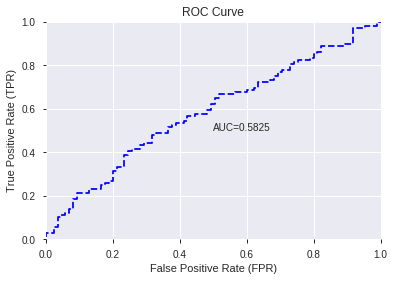

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


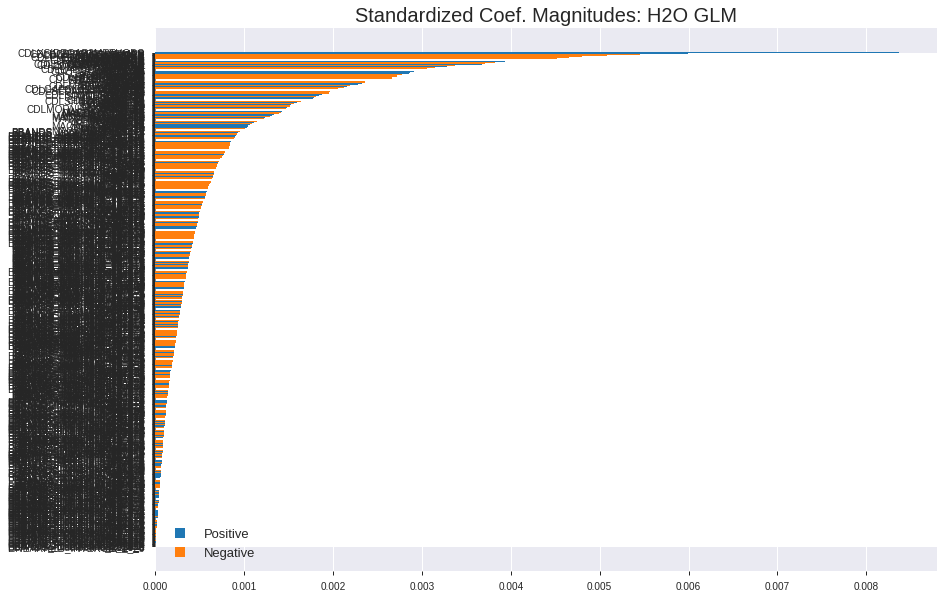

'log_likelihood'
--2019-08-25 14:49:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.147.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.147.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_144926_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_144926_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_9982',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

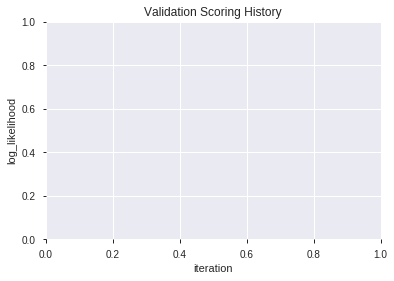

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190825_145008  0.619172  0.737771              0.458824  0.521023  0.271465
1  XGBoost_grid_1_AutoML_20190825_145008_model_2  0.594227  0.713476              0.451688  0.509952  0.260051
2               XGBoost_1_AutoML_20190825_145008  0.584858  0.780111              0.488235  0.538844  0.290353
3  XGBoost_grid_1_AutoML_20190825_145008_model_6  0.569281  0.806567              0.481100  0.549717  0.302189
4               XGBoost_3_AutoML_20190825_145008  0.567102  0.730599              0.488235  0.517393  0.267696
5  XGBoost_grid_1_AutoML_20190825_145008_model_4  0.563834  0.742618              0.494118  0.523478  0.274029
6  XGBoost_grid_1_AutoML_20190825_145008_model_1  0.545643  0.749716              0.500000  0.524934  0.275556
7  XGBoost_grid_1_AutoML_20190825_145008_model_7  0.542484  0.802007              0.500000  0.547412  0.299660
8  XGBoost_grid_1_AutoML_20190825_145008_model_3  0.501416  0.821058              0.494118  0.554495  0.307465
9  XGBoost_grid_1_AutoML_20190825_145008_model_5  0.457190  0.763062              0.475218  0.532554  0.283613

variable  relative_importance  scaled_importance  percentage
0             STOCHRSI_fastd           148.529785           1.000000    0.030161
1                        OBV           140.101013           0.943252    0.028449
2                        BOP           126.425560           0.851180    0.025672
3                      ADX_8            87.304451           0.587791    0.017728
4                      MFI_8            68.931259           0.464090    0.013997
..                       ...                  ...                ...         ...
306                   SMA_30             2.883541           0.019414    0.000586
307                 WILLR_30             2.825700           0.019024    0.000574
308  BBANDS_upperband_30_7_5             2.686815           0.018089    0.000546
309  BBANDS_upperband_14_3_5             1.922774           0.012945    0.000390
310  BBANDS_upperband_12_7_2             0.814415           0.005483    0.000165

[311 rows x 4 columns]

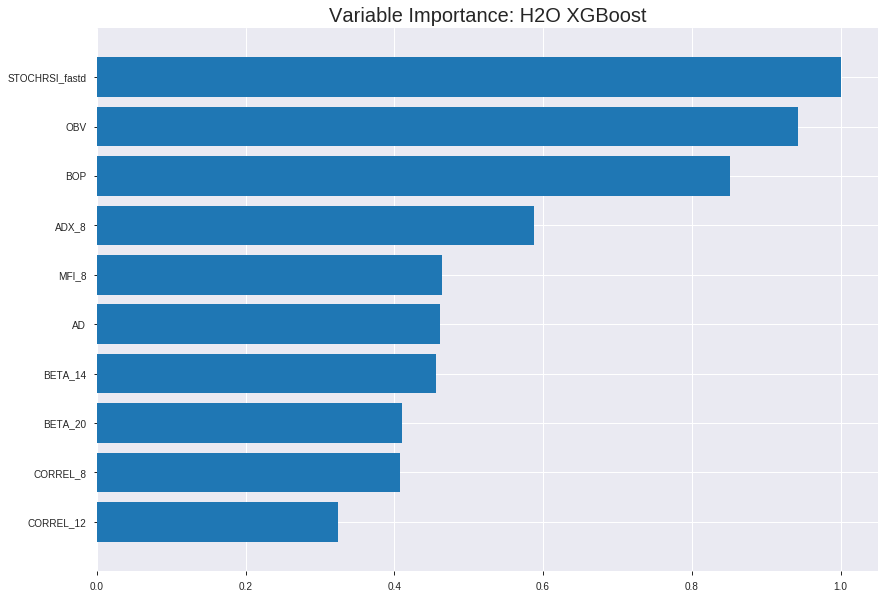

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190825_145008


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16947820859762056
RMSE: 0.41167731124950346
LogLoss: 0.5260980846880687
Mean Per-Class Error: 0.13435226582767568
AUC: 0.9374267262791853
pr_auc: 0.9363252583686728
Gini: 0.8748534525583707
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4899964431921641: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      565  106  0.158    (106.0/671.0)
1      80   595  0.1185   (80.0/675.0)
Total  645  701  0.1382   (186.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489996     0.864826  210
max f2                       0.43775      0.913019  255
max f0point5                 0.51691      0.882726  190
max accuracy                 0.51691      0.865527  190
max precision                0.79762      1         0
max recall                   0.315423     1         353
max specificity              0.79762      1         0
max absolute_mcc             0.51691      0.733571  190
max min_per_class_accuracy   0.500592     0.862222  202
max mean_per_class_accuracy  0.51691      0.865648  190

Gains/Lift Table: Avg response rate: 50.15 %, avg score: 50.33 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.749425           1.99407    1.99407            1                0.767012  1                           0.767012            0.0207407       0.0207407                  99.4074   99.4074
    2        0.0200594                   0.73876            1.99407    1.99407            1                0.745302  1                           0.756559            0.0192593       0.04                       99.4074   99.4074
    3        0.0304606                   0.728717           1.99407    1.99407            1                0.732954  1                           0.748499            0.0207407       0.0607407                  99.4074   99.4074
    4        0.0401189                   0.71998            1.99407    1.99407            1                0.723992  1                           0.742599            0.0192593       0.08                       99.4074   99.4074
    5        0.0505201                   0.710148           1.99407    1.99407            1                0.715548  1                           0.73703             0.0207407       0.100741                   99.4074   99.4074
    6        0.100297                    0.678057           1.99407    1.99407            1                0.69501   1                           0.716176            0.0992593       0.2                        99.4074   99.4074
    7        0.150074                    0.653903           1.96431    1.9842             0.985075         0.666928  0.99505                     0.699841            0.0977778       0.297778                   96.4312   98.4202
    8        0.200594                    0.628236           1.87678    1.95715            0.941176         0.641637  0.981481                    0.685182            0.0948148       0.392593                   87.6776   95.7147
    9        0.300149                    0.591377           1.77086    1.89536            0.88806          0.609326  0.950495                    0.660022            0.176296        0.568889                   77.0857   89.5358
    10       0.400446                    0.545247           1.66911    1.83869            0.837037         0.568904  0.922078                    0.6372              0.167407        0.736296                   66.9114   83.8692
    11       0.5                         0.499649           1.2649     1.72444            0.634328         0.521994  0.864785                    0.614262            0.125926        0.862222                   26.4898   72.4444
    12       0.600297                    0.459039           0.723775   1.55725            0.362963         0.478275  0.780941                    0.591541            0.0725926       0.934815                   -27.6225  55.7253
    13       0.699851                    0.418214           0.446434   1.39924            0.223881         0.43882   0.701699                    0.569817            0.0444444       0.979259                   -55.3566  39.9239
    14       0.800149                    0.375995           0.147709   1.24236            0.0740741        0.398068  0.623027                    0.548288            0.0148148       0.994074                   -85.2291  24.2362
    15       0.899703                    0.331456           0.0446434  1.10983            0.0223881        0.355749  0.556565                    0.526983            0.00444444      0.998519                   -95.5357  10.9831
    16       1                           0.19955            0.0147709  1                  0.00740741       0.290419  0.501486                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26126193025036165
RMSE: 0.5111378779256744
LogLoss: 0.7167630892098117
Mean Per-Class Error: 0.4744459213845862
AUC: 0.49030192876325857
pr_auc: 0.48883809372910175
Gini: -0.01939614247348287
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2890899181365967: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    192  0.9948   (192.0/193.0)
1      0    191  0        (0.0/191.0)
Total  1    383  0.5      (192.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.28909      0.665505   382
max f2                       0.28909      0.832607   382
max f0point5                 0.373771     0.562224   347
max accuracy                 0.380619     0.523438   341
max precision                0.723319     0.6        4
max recall                   0.28909      1          382
max specificity              0.789927     0.994819   0
max absolute_mcc             0.373771     0.0876687  347
max min_per_class_accuracy   0.513003     0.486911   191
max mean_per_class_accuracy  0.373771     0.525554   347

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 51.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.724284           1.00524   1.00524            0.5              0.762362  0.5                         0.762362            0.0104712       0.0104712                  0.52356   0.52356
    2        0.0208333                   0.697246           1.00524   1.00524            0.5              0.712151  0.5                         0.737256            0.0104712       0.0209424                  0.52356   0.52356
    3        0.03125                     0.691387           1.50785   1.17277            0.75             0.6952    0.583333                    0.723237            0.0157068       0.0366492                  50.7853   17.2775
    4        0.0416667                   0.678413           0.502618  1.00524            0.25             0.684861  0.5                         0.713643            0.0052356       0.0418848                  -49.7382  0.52356
    5        0.0520833                   0.66978            1.00524   1.00524            0.5              0.673769  0.5                         0.705669            0.0104712       0.052356                   0.52356   0.52356
    6        0.101562                    0.640372           0.846514  0.92791            0.421053         0.657694  0.461538                    0.682296            0.0418848       0.0942408                  -15.3486  -7.20902
    7        0.151042                    0.621811           1.05814   0.970572           0.526316         0.631078  0.482759                    0.665518            0.052356        0.146597                   5.81427   -2.94277
    8        0.200521                    0.604611           0.846514  0.939961           0.421053         0.614177  0.467532                    0.652849            0.0418848       0.188482                   -15.3486  -6.00394
    9        0.299479                    0.56857            1.05814   0.979012           0.526316         0.58484   0.486957                    0.630377            0.104712        0.293194                   5.81427   -2.09879
    10       0.401042                    0.539982           0.97946   0.979126           0.487179         0.553956  0.487013                    0.611024            0.0994764       0.39267                    -2.05397  -2.08744
    11       0.5                         0.512891           0.952328  0.973822           0.473684         0.524676  0.484375                    0.593934            0.0942408       0.486911                   -4.76715  -2.6178
    12       0.598958                    0.485307           0.899421  0.96153            0.447368         0.500895  0.478261                    0.578562            0.0890052       0.575916                   -10.0579  -3.84703
    13       0.700521                    0.456572           1.18566   0.994025           0.589744         0.471609  0.494424                    0.563056            0.120419        0.696335                   18.5663   -0.59752
    14       0.799479                    0.416164           1.05814   1.00196            0.526316         0.437347  0.498371                    0.547496            0.104712        0.801047                   5.81427   0.196122
    15       0.898438                    0.375433           1.21686   1.02563            0.605263         0.397005  0.510145                    0.53092             0.120419        0.921466                   21.6864   2.56317
    16       1                           0.272541           0.773258  1                  0.384615         0.342984  0.497396                    0.511833 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 14:50:12  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.498514                         0.5                0.693147              0.5               0                    1                  0.502604
    2019-08-25 14:50:13  0.543 sec   5                  0.48704          0.667498            0.776381        0.775733           1.90738          0.284547                         0.500676           0.694502              0.496704          0.484672             0.502618           0.494792
    2019-08-25 14:50:13  0.913 sec   10                 0.477175         0.648284            0.81876         0.819827           1.99407          0.260773                         0.50224            0.697672              0.491156          0.479731             0                  0.484375
    2019-08-25 14:50:14  1.294 sec   15                 0.466961         0.62862             0.848081        0.850737           1.99407          0.238484                         0.504166           0.701621              0.485066          0.489826             1.50785            0.502604
    2019-08-25 14:50:14  1.681 sec   20                 0.457988         0.611551            0.868899        0.870471           1.99407          0.216196                         0.505596           0.704611              0.48565           0.495606             2.01047            0.502604
    2019-08-25 14:50:14  2.140 sec   25                 0.449855         0.596177            0.880603        0.881692           1.99407          0.213224                         0.506859           0.70724               0.485934          0.49732              1.50785            0.502604
    2019-08-25 14:50:15  2.505 sec   30                 0.441729         0.580904            0.894           0.89619            1.99407          0.190193                         0.506994           0.707515              0.48702           0.491228             1.00524            0.497396
    2019-08-25 14:50:15  2.897 sec   35                 0.43367          0.565999            0.906245        0.907294           1.99407          0.175334                         0.507518           0.708759              0.496161          0.492669             1.00524            0.492188
    2019-08-25 14:50:16  3.362 sec   40                 0.425671         0.551308            0.917315        0.917898           1.99407          0.167905                         0.508885           0.711722              0.491902          0.489276             1.00524            0.479167
    2019-08-25 14:50:16  3.750 sec   45                 0.418126         0.537683            0.928249        0.927268           1.99407          0.142645                         0.50913            0.712383              0.496758          0.492331             1.00524            0.484375
    2019-08-25 14:50:16  4.102 sec   50                 0.411677         0.526098            0.937427        0.936325           1.99407          0.138187                         0.511138           0.716763              0.490302          0.488838             1.00524            0.5

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
STOCHRSI_fastd           148.52978515625        1.0                   0.030160769202576435
OBV                      140.10101318359375     0.9432519749234851    0.02844920511554165
BOP                      126.4255599975586      0.8511798483015494    0.025672238954507053
ADX_8                    87.30445098876953      0.5877908656295922    0.017728224637636746
MFI_8                    68.93125915527344      0.464090479110027     0.013997325829550645
---                      ---                    ---                   ---
SMA_30                   2.8835408687591553     0.0194138897173098    0.0005855378470880527
WILLR_30                 2.825699806213379      0.01902446572073612   0.0005737925198054492
BBANDS_upperband_30_7_5  2.6868152618408203     0.01808940381226803   0.0005455903333940224
BBANDS_upperband_14_3_5  1.922774314880371      0.012945378685208868  0.000390442578764537
BBANDS_upperband_12_7_2  0.8144149780273438     0.005483176166791041  0.00016537681086365236


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6113989637305699)

('F1', 0.7346938775510204)

('auc', 0.6191721132897603)

('logloss', 0.7377712035595405)

('mean_per_class_error', 0.40168845315904134)

('rmse', 0.5210234134219789)

('mse', 0.27146539733389036)

xgboost prediction progress: |████████████████████████████████████████████| 100%


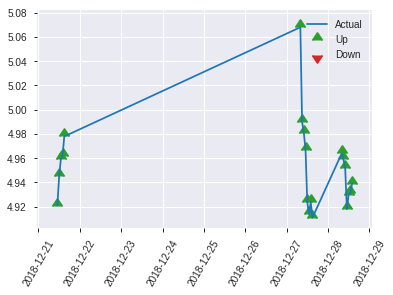


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.27146539733389036
RMSE: 0.5210234134219789
LogLoss: 0.7377712035595405
Mean Per-Class Error: 0.40168845315904134
AUC: 0.6191721132897603
pr_auc: 0.6634358230732175
Gini: 0.2383442265795206
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2749679982662201: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      7    78   0.9176   (78.0/85.0)
1      0    108  0        (0.0/108.0)
Total  7    186  0.4041   (78.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.274968     0.734694  185
max f2                       0.274968     0.873786  185
max f0point5                 0.346236     0.648734  130
max accuracy                 0.346236     0.611399  130
max precision                0.54111      1         0
max recall                   0.274968     1         185
max specificity              0.54111      1         0
max absolute_mcc             0.274968     0.218673  185
max min_per_class_accuracy   0.369452     0.588235  98
max mean_per_class_accuracy  0.392106     0.598312  77

Gains/Lift Table: Avg response rate: 55.96 %, avg score: 37.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.514604           1.78704   1.78704            1                0.534558  1                           0.534558            0.0185185       0.0185185                  78.7037   78.7037
    2        0.0207254                   0.511659           1.78704   1.78704            1                0.513268  1                           0.523913            0.0185185       0.037037                   78.7037   78.7037
    3        0.0310881                   0.499738           0.893519  1.4892             0.5              0.507061  0.833333                    0.518295            0.00925926      0.0462963                  -10.6481  48.9198
    4        0.0414508                   0.487326           0.893519  1.34028            0.5              0.49707   0.75                        0.512989            0.00925926      0.0555556                  -10.6481  34.0278
    5        0.0518135                   0.476587           0.893519  1.25093            0.5              0.48287   0.7                         0.506965            0.00925926      0.0648148                  -10.6481  25.0926
    6        0.103627                    0.448081           1.42963   1.34028            0.8              0.45942   0.75                        0.483193            0.0740741       0.138889                   42.963    34.0278
    7        0.150259                    0.436916           1.38992   1.35568            0.777778         0.441087  0.758621                    0.470125            0.0648148       0.203704                   38.9918   35.5683
    8        0.202073                    0.423983           1.07222   1.283              0.6              0.430732  0.717949                    0.460025            0.0555556       0.259259                   7.22222   28.3001
    9        0.300518                    0.409332           1.0346    1.20163            0.578947         0.416301  0.672414                    0.445701            0.101852        0.361111                   3.46004   20.1628
    10       0.398964                    0.392141           1.22271   1.20683            0.684211         0.401127  0.675325                    0.434702            0.12037         0.481481                   22.271    20.683
    11       0.502591                    0.371049           0.893519  1.14223            0.5              0.381681  0.639175                    0.42377             0.0925926       0.574074                   -10.6481  14.223
    12       0.601036                    0.358974           1.0346    1.1246             0.578947         0.364221  0.62931                     0.414016            0.101852        0.675926                   3.46004   12.4601
    13       0.699482                    0.342725           0.846491  1.08546            0.473684         0.349922  0.607407                    0.404996            0.0833333       0.759259                   -15.3509  8.54595
    14       0.797927                    0.324323           0.846491  1.05598            0.473684         0.333777  0.590909                    0.396209            0.0833333       0.842593                   -15.3509  5.59764
    15       0.896373                    0.296976           0.846491  1.03297            0.473684         0.310524  0.578035                    0.386798            0.0833333       0.925926                   -15.3509  3.29694
    16       1                           0.258035           0.714815  1                  0.4              0.280731  0.559585                    0.375807           

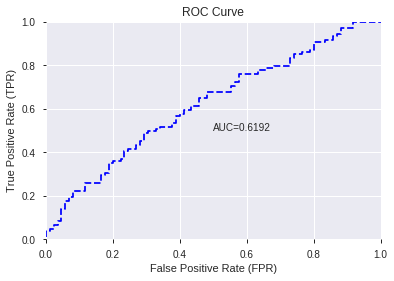

This function is available for GLM models only


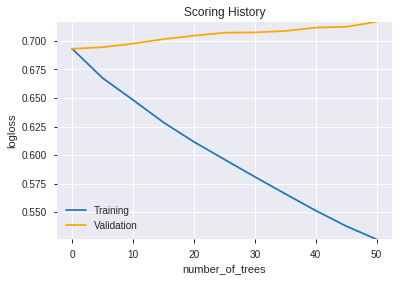

--2019-08-25 14:50:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


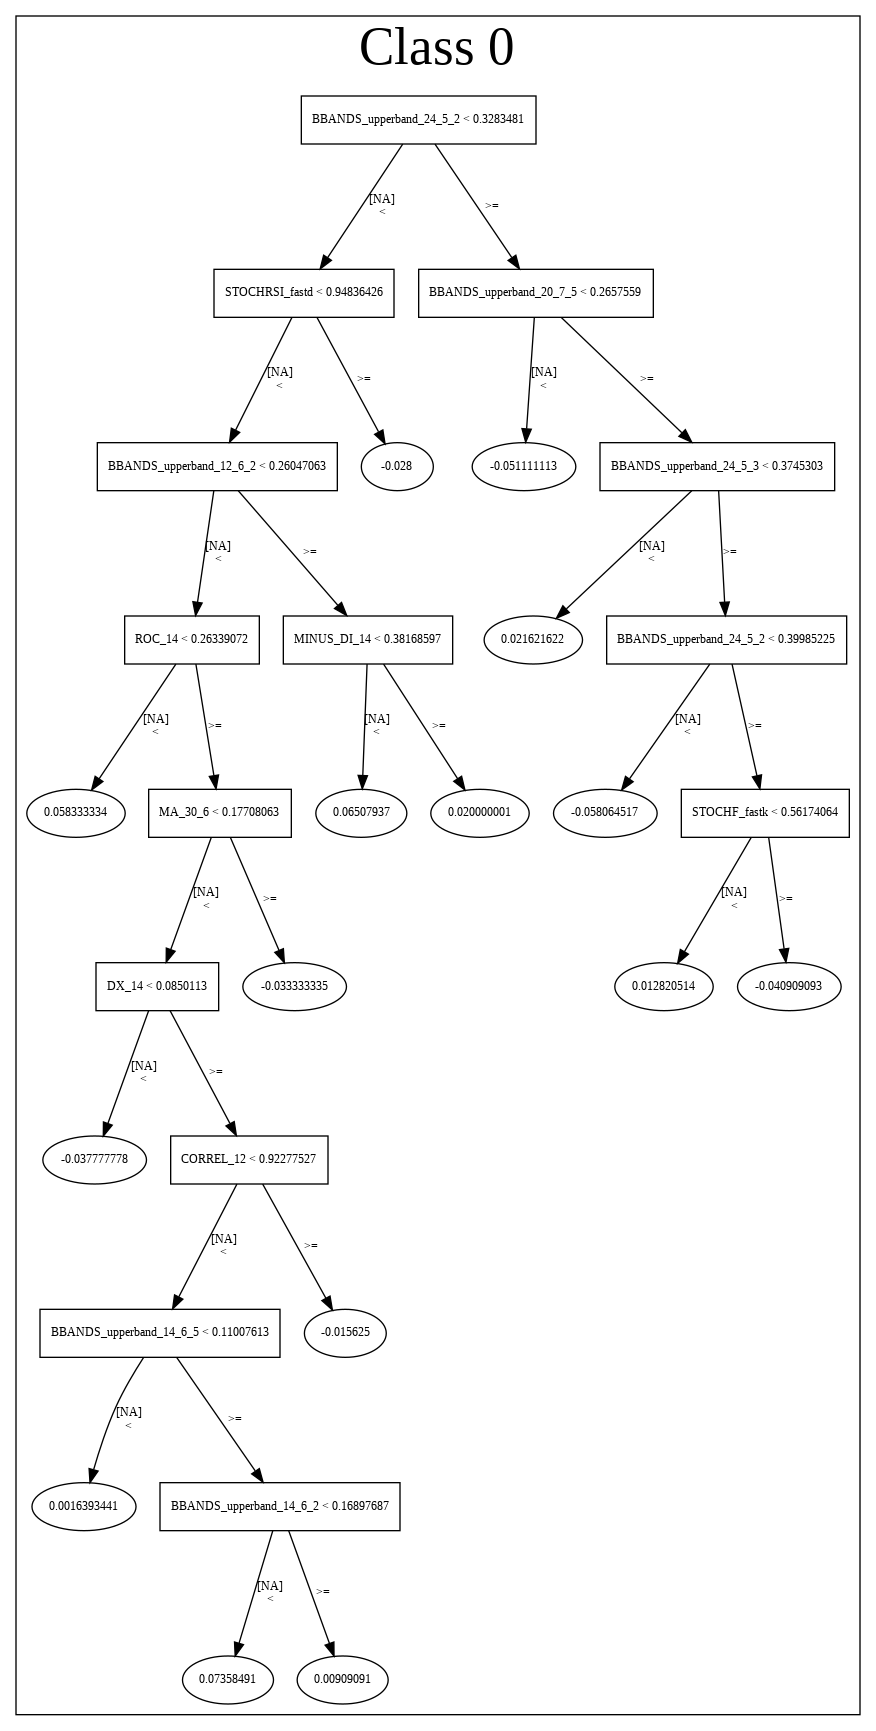

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190825_145008',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190825_145008',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_9982',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_9982',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_145103_model_2  0.657516  0.852094              0.463453  0.540927  0.292602
1  DeepLearning_grid_1_AutoML_20190825_145103_model_1  0.596405  2.198911              0.500000  0.652150  0.425299
2  DeepLearning_grid_1_AutoML_20190825_145103_model_3  0.585294  0.939305              0.494118  0.532122  0.283154
3               DeepLearning_1_AutoML_20190825_145103  0.575054  0.845600              0.481100  0.545496  0.297566
4  DeepLearning_grid_1_AutoML_20190825_145103_model_5  0.563181  0.741981              0.494118  0.519272  0.269644
5  DeepLearning_grid_1_AutoML_20190825_145103_model_6  0.552614  0.729110              0.500000  0.516150  0.266411
6  DeepLearning_grid_1_AutoML_20190825_145103_model_7  0.548693  1.653609              0.500000  0.665583  0.443001
7  DeepLearning_grid_1_AutoML_20190825_145103_model_9  0.532462  0.729176              0.479847  0.517090  0.267382
8  DeepLearning_grid_1_AutoML_20190825_145103_model_4  0.516776  1.258552              0.482353  0.628706  0.395271
9  DeepLearning_grid_1_AutoML_20190825_145103_model_8  0.513780  0.706877              0.500000  0.506787  0.256833

variable  relative_importance  scaled_importance  percentage
0        CDL3LINESTRIKE             1.000000           1.000000    0.033466
1             CDLINNECK             0.851995           0.851995    0.028513
2                   day             0.788660           0.788660    0.026394
3           CDLPIERCING             0.770140           0.770140    0.025774
4     CDLSTALLEDPATTERN             0.742564           0.742564    0.024851
5   CDLGAPSIDESIDEWHITE             0.739420           0.739420    0.024746
6     CDL3WHITESOLDIERS             0.736349           0.736349    0.024643
7          HT_TRENDMODE             0.728074           0.728074    0.024366
8             CDL2CROWS             0.722398           0.722398    0.024176
9    CDLEVENINGDOJISTAR             0.695086           0.695086    0.023262
10      CDLLADDERBOTTOM             0.679749           0.679749    0.022749
11    CDLDARKCLOUDCOVER             0.678530           0.678530    0.022708
12                 hour             0.632996           0.632996    0.021184
13        days_in_month             0.630338           0.630338    0.021095
14         CDLTASUKIGAP             0.614376           0.614376    0.020561
15                ADOSC             0.602820           0.602820    0.020174
16                  OBV             0.600209           0.600209    0.020087
17              BETA_12             0.598730           0.598730    0.020037
18         weekday_name             0.596520           0.596520    0.019963
19         CDLTHRUSTING             0.595469           0.595469    0.019928
20              weekday             0.582964           0.582964    0.019510
21                  BOP             0.582542           0.582542    0.019496
22                 DX_8             0.576988           0.576988    0.019310
23   CDLMORNINGDOJISTAR             0.574214           0.574214    0.019217
24         aroondown_30             0.570569           0.570569    0.019095
25            aroonup_8             0.570413           0.570413    0.019090
26       CDLEVENINGSTAR             0.569343           0.569343    0.019054
27       STOCHRSI_fastk             0.568790           0.568790    0.019035
28            CDLONNECK             0.558079           0.558079    0.018677
29    CDLLONGLEGGEDDOJI             0.555505           0.555505    0.018591
30         aroondown_20             0.549778           0.549778    0.018399
31           aroonup_20             0.549506           0.549506    0.018390
32         STOCHF_fastk             0.548742           0.548742    0.018364
33           aroonup_30             0.541579           0.541579    0.018125
34            dayofweek             0.539220           0.539220    0.018046
35               SAREXT             0.538937           0.538937    0.018036
36         CDLSHORTLINE             0.534352           0.534352    0.017883
37          aroondown_8             0.532435           0.532435    0.017819
38          HT_DCPERIOD             0.530904           0.530904    0.017767
39         aroondown_24             0.519806           0.519806    0.017396
40         aroondown_14             0.517206           0.517206    0.017309
41                 CEIL             0.510801           0.510801    0.017095
42            CORREL_12             0.507284           0.507284    0.016977
43         aroondown_12             0.494681           0.494681    0.016555
44             CORREL_8             0.488878           0.488878    0.016361
45         STOCHF_fastd             0.487917           0.487917    0.016329
46                FLOOR             0.480546           0.480546    0.016082
47    CDLINVERTEDHAMMER             0.460518           0.460518    0.015412
48          CDLBELTHOLD             0.425904           0.425904    0.014253
49      CDLADVANCEBLOCK             0.407995           0.407995    0.013654

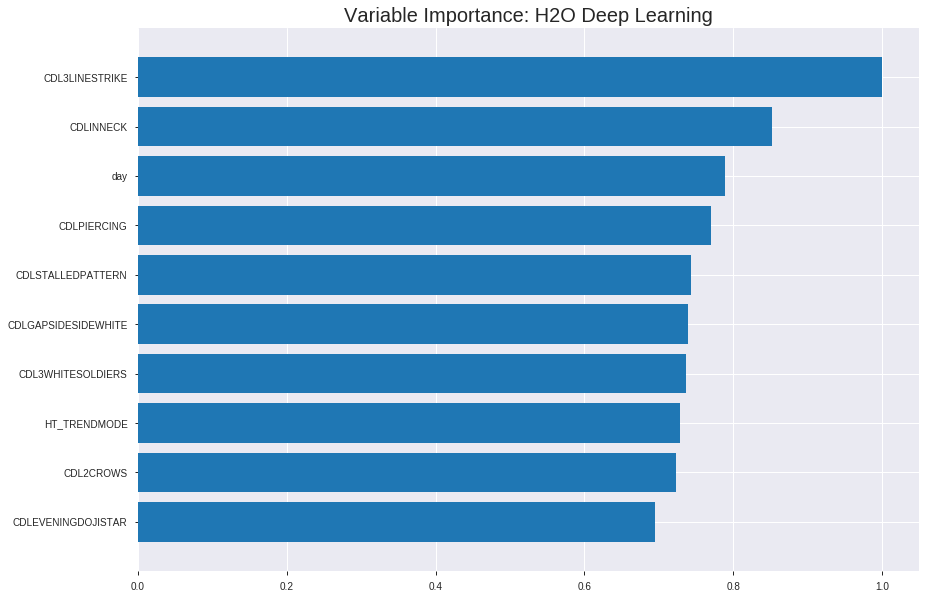

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_145103_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24999156718471596
RMSE: 0.4999915671136024
LogLoss: 0.732970291487022
Mean Per-Class Error: 0.37006347629298453
AUC: 0.6460716454159077
pr_auc: 0.6176357200429892
Gini: 0.29214329083181534
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2030121690173269: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      147  524   0.7809   (524.0/671.0)
1      55   620   0.0815   (55.0/675.0)
Total  202  1144  0.4302   (579.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.203012     0.681693  333
max f2                       0.00628588   0.834366  398
max f0point5                 0.433493     0.630874  224
max accuracy                 0.433493     0.630015  224
max precision                0.998995     1         0
max recall                   4.67392e-05  1         399
max specificity              0.998995     1         0
max absolute_mcc             0.433493     0.260244  224
max min_per_class_accuracy   0.451948     0.627422  215
max mean_per_class_accuracy  0.433493     0.629937  224

Gains/Lift Table: Avg response rate: 50.15 %, avg score: 46.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.976968           1.56677   1.56677            0.785714         0.991133   0.785714                    0.991133            0.0162963       0.0162963                  56.6772   56.6772
    2        0.0200594                   0.947871           1.84068   1.69866            0.923077         0.959627   0.851852                    0.975964            0.0177778       0.0340741                  84.0684   69.8656
    3        0.0304606                   0.922589           1.42434   1.60499            0.714286         0.932433   0.804878                    0.9611              0.0148148       0.0488889                  42.4339   60.4986
    4        0.0401189                   0.904437           0.920342  1.44016            0.461538         0.9145     0.722222                    0.949881            0.00888889      0.0577778                  -7.96581  44.0165
    5        0.0505201                   0.89072            1.42434   1.43691            0.714286         0.897227   0.720588                    0.939041            0.0148148       0.0725926                  42.4339   43.6906
    6        0.100297                    0.811836           1.19049   1.31461            0.597015         0.851921   0.659259                    0.895803            0.0592593       0.131852                   19.0492   31.4612
    7        0.150074                    0.757497           1.10121   1.24383            0.552239         0.786751   0.623762                    0.859632            0.0548148       0.186667                   10.1205   24.3828
    8        0.200594                    0.70687            1.26096   1.24814            0.632353         0.731307   0.625926                    0.827313            0.0637037       0.25037                    26.0959   24.8143
    9        0.300149                    0.60612            1.30954   1.26851            0.656716         0.655462   0.636139                    0.770313            0.13037         0.380741                   30.9541   26.8508
    10       0.400446                    0.519371           1.3737    1.29485            0.688889         0.559648   0.649351                    0.717549            0.137778        0.518519                   37.3695   29.4853
    11       0.5                         0.451948           1.08632   1.25333            0.544776         0.486192   0.628529                    0.671484            0.108148        0.626667                   8.63239   25.3333
    12       0.600297                    0.373133           0.812401  1.17966            0.407407         0.414263   0.591584                    0.628508            0.0814815       0.708148                   -18.7599  17.9663
    13       0.699851                    0.309106           0.863107  1.13463            0.432836         0.341867   0.569002                    0.587733            0.0859259       0.794074                   -13.6893  13.4632
    14       0.800149                    0.238558           0.827171  1.09609            0.414815         0.278021   0.549675                    0.548911            0.082963        0.877037                   -17.2829  9.60927
    15       0.899703                    0.161342           0.669652  1.04891            0.335821         0.199557   0.526012                    0.510254            0.0666667       0.943704                   -33.0348  4.8906
    16       1                           2.60521e-12        0.561295  1                  0.281481         0.0962294  0.501486                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.30943588965789537
RMSE: 0.556269619571207
LogLoss: 0.9414236631779991
Mean Per-Class Error: 0.4785421696552098
AUC: 0.5021837614952662
pr_auc: 0.5221855524691625
Gini: 0.004367522990532446
Confusion Matrix (Act/Pred) for max f1 @ threshold = 8.397184870012019e-07: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    190  0.9845   (190.0/193.0)
1      1    190  0.0052   (1.0/191.0)
Total  4    380  0.4974   (191.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       8.39718e-07  0.665499  379
max f2                       4.147e-11    0.831882  383
max f0point5                 8.39718e-07  0.555231  379
max accuracy                 0.834811     0.523438  45
max precision                0.996955     1         0
max recall                   4.147e-11    1         383
max specificity              0.996955     1         0
max absolute_mcc             0.96261      0.136975  6
max min_per_class_accuracy   0.570045     0.486911  191
max mean_per_class_accuracy  0.834811     0.521458  45

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 54.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.967659           2.01047   2.01047            1                0.984259  1                           0.984259            0.0209424       0.0209424                  101.047   101.047
    2        0.0208333                   0.952195           1.50785   1.75916            0.75             0.963074  0.875                       0.973667            0.0157068       0.0366492                  50.7853   75.9162
    3        0.03125                     0.941537           0.502618  1.34031            0.25             0.946118  0.666667                    0.964484            0.0052356       0.0418848                  -49.7382  34.0314
    4        0.0416667                   0.930075           1.50785   1.3822             0.75             0.935196  0.6875                      0.957162            0.0157068       0.0575916                  50.7853   38.2199
    5        0.0520833                   0.913012           0.502618  1.20628            0.25             0.922377  0.6                         0.950205            0.0052356       0.0628272                  -49.7382  20.6283
    6        0.101562                    0.855823           1.05814   1.13411            0.526316         0.878203  0.564103                    0.915127            0.052356        0.115183                   5.81427   13.4112
    7        0.151042                    0.802475           0.952328  1.07456            0.473684         0.830045  0.534483                    0.887255            0.0471204       0.162304                   -4.76715  7.45622
    8        0.200521                    0.775139           1.16396   1.09662            0.578947         0.788254  0.545455                    0.862827            0.0575916       0.219895                   16.3957   9.66207
    9        0.299479                    0.692994           0.7407    0.979012           0.368421         0.73291   0.486957                    0.819897            0.0732984       0.293194                   -25.93    -2.09879
    10       0.401042                    0.634616           1.13411   1.01829            0.564103         0.668381  0.506494                    0.781526            0.115183        0.408377                   13.4112   1.82906
    11       0.5                         0.567346           0.793607  0.973822           0.394737         0.603517  0.484375                    0.746295            0.078534        0.486911                   -20.6393  -2.6178
    12       0.598958                    0.485028           0.899421  0.96153            0.447368         0.527921  0.478261                    0.710216            0.0890052       0.575916                   -10.0579  -3.84703
    13       0.700521                    0.399502           1.23721   1.0015             0.615385         0.440998  0.498141                    0.671184            0.125654        0.701571                   23.7213   0.149867
    14       0.799479                    0.294403           1.05814   1.00851            0.526316         0.354003  0.501629                    0.631924            0.104712        0.806283                   5.81427   0.850999
    15       0.898438                    0.206002           0.952328  1.00232            0.473684         0.248767  0.498551                    0.589721            0.0942408       0.900524                   -4.76715  0.232188
    16       1                           4.147e-11          0.97946   1                  0.487179         0.117148  0.497396                    0.541726    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 14:51:39  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 14:51:41  36.384 sec        7136 obs/sec      10        1             13460      0.499992         0.73297             2.49001e-05    0.646072        0.617636           1.56677          0.430163                         0.55627            0.941424              -0.237777        0.502184          0.522186             2.01047            0.497396
    2019-08-25 14:51:46  41.681 sec        9433 obs/sec      50        5             67300      0.490289         0.745034            0.0384565      0.697999        0.655888           1.85164          0.362556                         0.620558           1.29079               -0.540411        0.480224          0.508434             1.50785            0.494792
    2019-08-25 14:51:52  46.981 sec        10865 obs/sec     100       10            134600     0.439138         0.595001            0.228625       0.791473        0.765663           1.85164          0.291976                         0.616017           1.42942               -0.51795         0.501221          0.51894              1.50785            0.489583
    2019-08-25 14:51:57  52.785 sec        11867 obs/sec     160       16            215360     0.377285         0.455127            0.430621       0.87429         0.845145           1.85164          0.194651                         0.601825           1.36789               -0.448811        0.510254          0.530695             1.50785            0.5
    2019-08-25 14:52:03  58.264 sec        12557 obs/sec     220       22            296120     0.355342         0.417626            0.494924       0.899117        0.850159           1.99407          0.179049                         0.613001           1.4835                -0.503121        0.499742          0.514586             1.50785            0.497396
    2019-08-25 14:52:08  1 min  3.481 sec  13107 obs/sec     280       28            376880     0.320062         0.350188            0.590238       0.932605        0.884126           1.99407          0.140416                         0.598054           1.39592               -0.430711        0.520929          0.522954             1.50785            0.473958
    2019-08-25 14:52:08  1 min  3.539 sec  13105 obs/sec     280       28            376880     0.499992         0.73297             2.49001e-05    0.646072        0.617636           1.56677          0.430163                         0.55627            0.941424              -0.237777        0.502184          0.522186             2.01047            0.497396

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDL3LINESTRIKE     1.0                    1.0                  0.03346628321559402
CDLINNECK          0.851995050907135      0.851995050907135    0.028513107671942626
day                0.7886600494384766     0.7886600494384766   0.026393520575332438
CDLPIERCING        0.7701398730278015     0.7701398730278015   0.025773719106370024
CDLSTALLEDPATTERN  0.7425640225410461     0.7425640225410461   0.02485085788406939
---                ---                    ---                  ---
STOCHF_fastd       0.48791739344596863    0.48791739344596863  0.016328781674877203
FLOOR              0.480546236038208      0.480546236038208    0.016082096433442362
CDLINVERTEDHAMMER  0.4605180025100708     0.4605180025100708   0.015411825897881667
CDLBELTHOLD        0.42590442299842834    0.42590442299842834  0.014253438042839559
CDLADVANCEBLOCK    0.40799519419670105    0.40799519419670105  0.01365408271958808


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6321243523316062)

('F1', 0.7303754266211604)

('auc', 0.657516339869281)

('logloss', 0.8520943763118053)

('mean_per_class_error', 0.3681372549019608)

('rmse', 0.540926576827514)

('mse', 0.29260156151833244)

deeplearning prediction progress: |███████████████████████████████████████| 100%


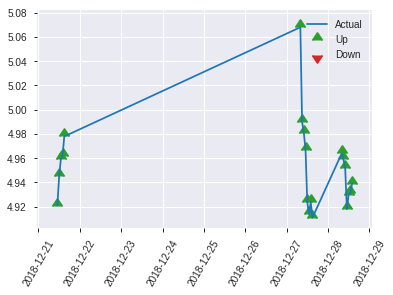


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.29260156151833244
RMSE: 0.540926576827514
LogLoss: 0.8520943763118053
Mean Per-Class Error: 0.3681372549019608
AUC: 0.657516339869281
pr_auc: 0.6896292148198067
Gini: 0.3150326797385621
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05570825607664375: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      7    78   0.9176   (78.0/85.0)
1      1    107  0.0093   (1.0/108.0)
Total  8    185  0.4093   (79.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0557083    0.730375  184
max f2                       0.0557083    0.867099  184
max f0point5                 0.26303      0.672348  104
max accuracy                 0.26303      0.632124  104
max precision                0.510961     0.833333  35
max recall                   0.00327792   1         190
max specificity              0.992936     0.988235  0
max absolute_mcc             0.423136     0.288615  52
max min_per_class_accuracy   0.282813     0.601852  95
max mean_per_class_accuracy  0.413333     0.631863  57

Gains/Lift Table: Avg response rate: 55.96 %, avg score: 31.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.817558           0.893519  0.893519           0.5              0.945933   0.5                         0.945933            0.00925926      0.00925926                 -10.6481  -10.6481
    2        0.0207254                   0.763842           0.893519  0.893519           0.5              0.79643    0.5                         0.871182            0.00925926      0.0185185                  -10.6481  -10.6481
    3        0.0310881                   0.73504            1.78704   1.19136            1                0.756104   0.666667                    0.832823            0.0185185       0.037037                   78.7037   19.1358
    4        0.0414508                   0.715719           1.78704   1.34028            1                0.72339    0.75                        0.805465            0.0185185       0.0555556                  78.7037   34.0278
    5        0.0518135                   0.676418           1.78704   1.42963            1                0.699729   0.8                         0.784317            0.0185185       0.0740741                  78.7037   42.963
    6        0.103627                    0.604787           1.42963   1.42963            0.8              0.639084   0.8                         0.711701            0.0740741       0.148148                   42.963    42.963
    7        0.150259                    0.540676           1.38992   1.41731            0.777778         0.566097   0.793103                    0.666513            0.0648148       0.212963                   38.9918   41.7305
    8        0.202073                    0.489633           1.42963   1.42047            0.8              0.517322   0.794872                    0.628259            0.0740741       0.287037                   42.963    42.0465
    9        0.300518                    0.411701           1.31676   1.38649            0.736842         0.443824   0.775862                    0.567841            0.12963         0.416667                   31.6764   38.6494
    10       0.398964                    0.326452           0.752437  1.23004            0.421053         0.373686   0.688312                    0.519932            0.0740741       0.490741                   -24.7563  23.0038
    11       0.502591                    0.282689           1.07222   1.1975             0.6              0.303929   0.670103                    0.475396            0.111111        0.601852                   7.22222   19.7499
    12       0.601036                    0.232883           0.940546  1.15541            0.526316         0.258224   0.646552                    0.439824            0.0925926       0.694444                   -5.94542  15.5412
    13       0.699482                    0.193185           0.940546  1.12517            0.526316         0.213787   0.62963                     0.408012            0.0925926       0.787037                   -5.94542  12.5171
    14       0.797927                    0.136003           0.564327  1.05598            0.315789         0.1677     0.590909                    0.378363            0.0555556       0.842593                   -43.5673  5.59764
    15       0.896373                    0.09497            0.752437  1.02264            0.421053         0.114394   0.572254                    0.349372            0.0740741       0.916667                   -24.7563  2.26397
    16       1                           1.25609e-08        0.804167  1                  0.45             0.0556573  0.559585                   

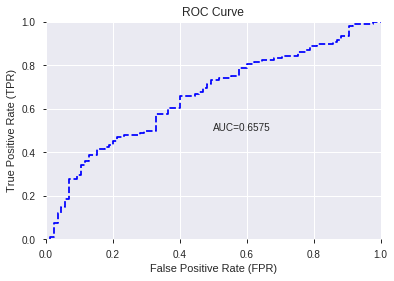

This function is available for GLM models only


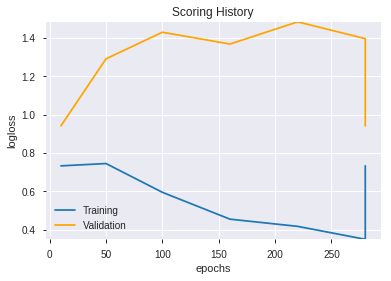

--2019-08-25 14:56:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.88.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.88.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


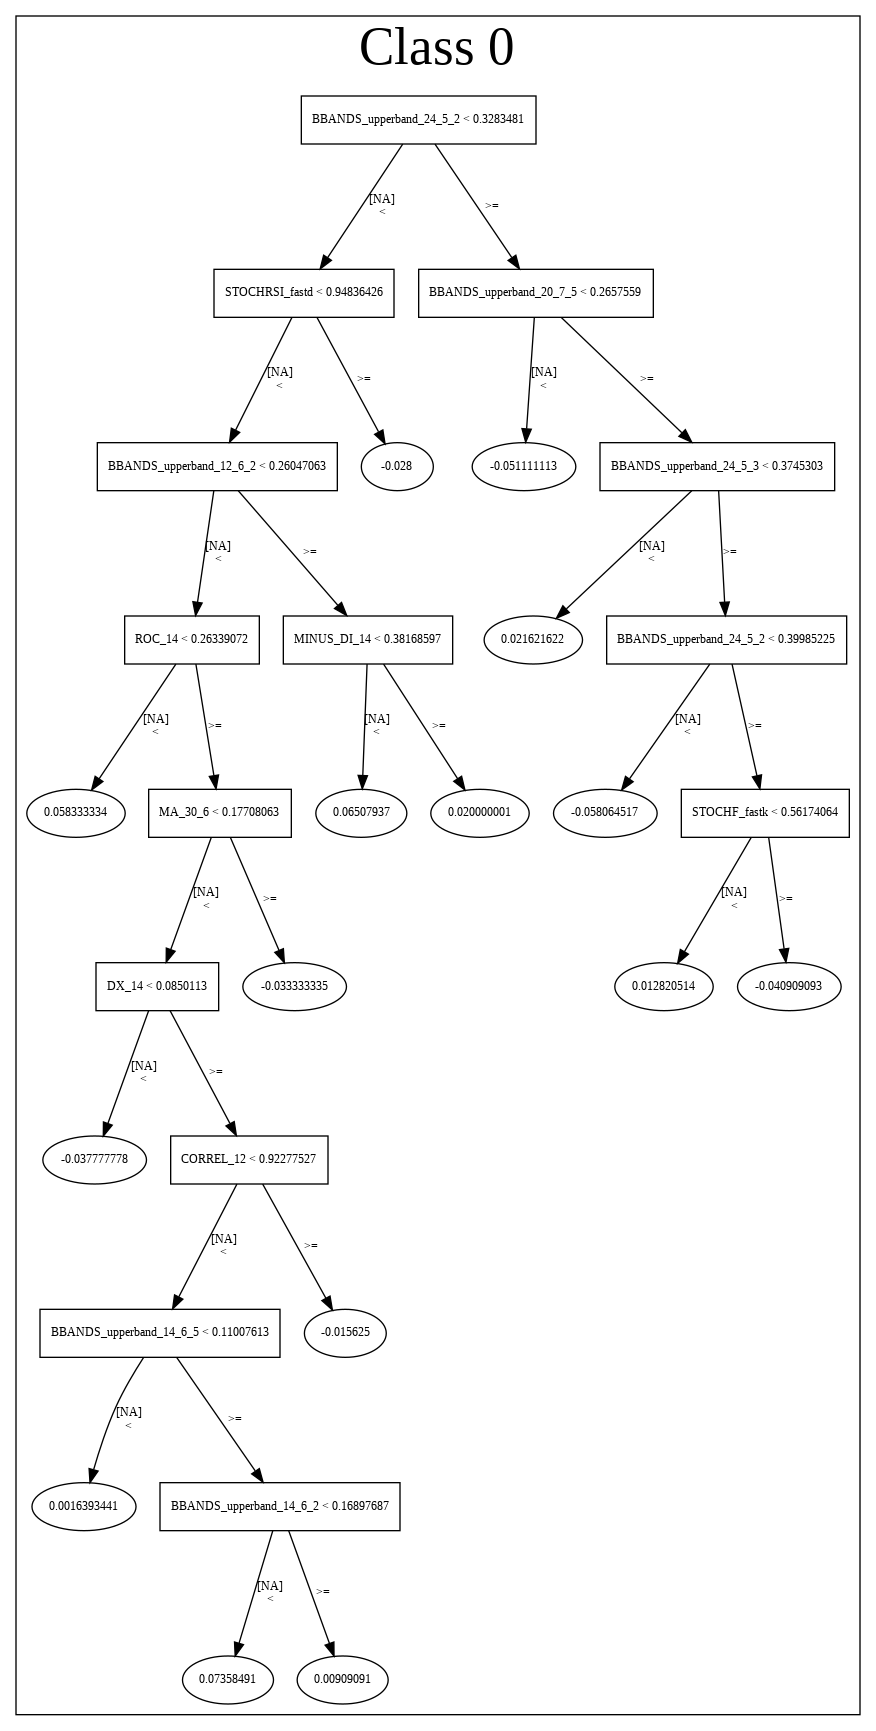

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_145103_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_145103_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_9982',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDL3LINESTRIKE',
 'CDLINNECK',
 'day',
 'CDLPIERCING',
 'CDLSTALLEDPATTERN',
 'CDLGAPSIDESIDEWHITE',
 'CDL3WHITESOLDIERS',
 'HT_TRENDMODE',
 'CDL2CROWS',
 'CDLEVENINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'CDLDARKCLOUDCOVER',
 'hour',
 'days_in_month',
 'CDLTASUKIGAP',
 'ADOSC',
 'OBV',
 'BETA_12',
 'weekday_name',
 'CDLTHRUSTING',
 'weekday',
 'BOP',
 'DX_8',
 'CDLMORNINGDOJISTAR',
 'aroondown_30',
 'aroonup_8',
 'CDLEVENINGSTAR',
 'STOCHRSI_fastk',
 'CDLONNECK',
 'CDLLONGLEGGEDDOJI',
 'aroondown_20',
 'aroonup_20',
 'STOCHF_fastk',
 'aroonup_30',
 'dayofweek',
 'SAREXT',
 'CDLSHORTLINE',
 'aroondown_8',
 'HT_DCPERIOD',
 'aroondown_24',
 'aroondown_14',
 'CEIL',
 'CORREL_12',
 'aroondown_12',
 'CORREL_8',
 'STOCHF_fastd',
 'FLOOR',
 'CDLINVERTEDHAMMER',
 'CDLBELTHOLD',
 'CDLADVANCEBLOCK']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_145658_model_1  0.54281  0.700456              0.482353  0.503652  0.253665

variable  relative_importance  scaled_importance  percentage
0                   OBV             0.052888           1.000000    0.054101
1     CDLINVERTEDHAMMER             0.050169           0.948590    0.051320
2       CDLADVANCEBLOCK             0.040047           0.757199    0.040965
3                SAREXT             0.034846           0.658869    0.035645
4        CDL3LINESTRIKE             0.034348           0.649453    0.035136
5             CDLONNECK             0.034107           0.644886    0.034889
6           CDLBELTHOLD             0.034034           0.643503    0.034814
7          HT_TRENDMODE             0.032737           0.618982    0.033487
8                 ADOSC             0.031273           0.591298    0.031990
9           CDLPIERCING             0.030901           0.584281    0.031610
10   CDLEVENINGDOJISTAR             0.030101           0.569149    0.030791
11         aroondown_20             0.029460           0.557021    0.030135
12            CDLINNECK             0.029397           0.555839    0.030071
13             CORREL_8             0.029133           0.550840    0.029801
14         CDLTASUKIGAP             0.025823           0.488264    0.026415
15          HT_DCPERIOD             0.025692           0.485777    0.026281
16    CDL3WHITESOLDIERS             0.024846           0.469786    0.025416
17    CDLSTALLEDPATTERN             0.024628           0.465664    0.025193
18                FLOOR             0.022115           0.418147    0.022622
19                 CEIL             0.022111           0.418063    0.022618
20                 DX_8             0.021779           0.411799    0.022279
21            CDL2CROWS             0.021496           0.406446    0.021989
22         aroondown_14             0.020764           0.392611    0.021241
23      CDLLADDERBOTTOM             0.019793           0.374248    0.020247
24         STOCHF_fastd             0.019252           0.364015    0.019694
25              BETA_12             0.018411           0.348104    0.018833
26           aroonup_20             0.017851           0.337520    0.018260
27            CORREL_12             0.017457           0.330084    0.017858
28         CDLSHORTLINE             0.016372           0.309564    0.016748
29         aroondown_24             0.015636           0.295641    0.015994
30       CDLEVENINGSTAR             0.014539           0.274897    0.014872
31           aroonup_30             0.014265           0.269722    0.014592
32  CDLGAPSIDESIDEWHITE             0.013898           0.262775    0.014216
33         CDLTHRUSTING             0.011938           0.225724    0.012212
34         weekday_name             0.011285           0.213378    0.011544
35       STOCHRSI_fastk             0.011252           0.212761    0.011511
36        days_in_month             0.010778           0.203788    0.011025
37                  BOP             0.010611           0.200630    0.010854
38         aroondown_12             0.010514           0.198790    0.010755
39                  day             0.009220           0.174334    0.009432
40            aroonup_8             0.006804           0.128654    0.006960
41          aroondown_8             0.005971           0.112895    0.006108
42   CDLMORNINGDOJISTAR             0.005039           0.095268    0.005154
43         aroondown_30             0.004390           0.083015    0.004491
44         STOCHF_fastk             0.004027           0.076142    0.004119
45                 hour             0.002398           0.045333    0.002453
46    CDLDARKCLOUDCOVER             0.001486           0.028100    0.001520
47    CDLLONGLEGGEDDOJI             0.001139           0.021542    0.001165
48            dayofweek             0.000281           0.005311    0.000287
49              weekday             0.000280           0.005295    0.000286

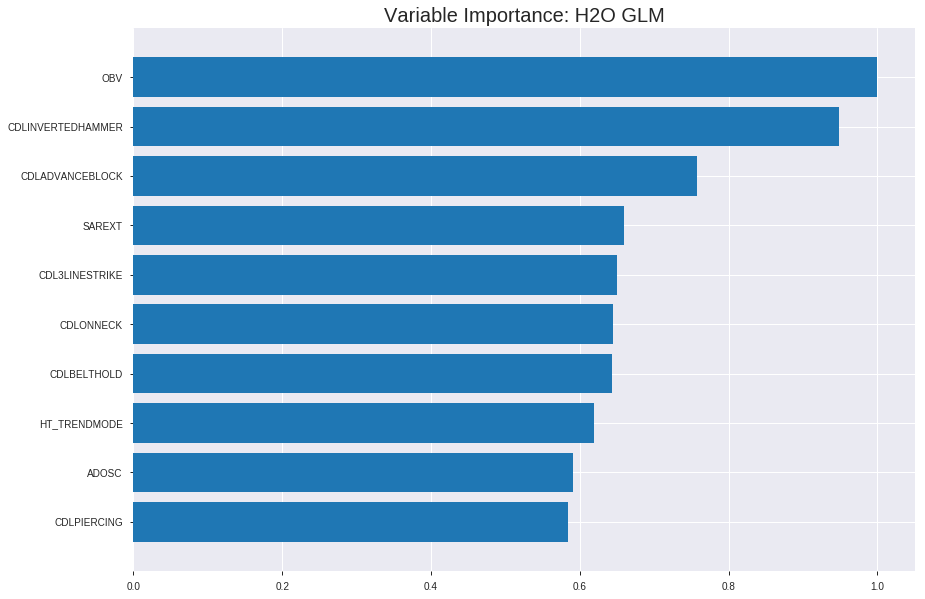

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_145658_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.243799776907225
RMSE: 0.4937608499134222
LogLoss: 0.6804325849993281
Null degrees of freedom: 1345
Residual degrees of freedom: 1295
Null deviance: 1865.9403229770678
Residual deviance: 1831.724518818191
AIC: 1933.724518818191
AUC: 0.5940795937517249
pr_auc: 0.6000139936071259
Gini: 0.18815918750344984
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4267417860315205: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      16   655   0.9762   (655.0/671.0)
1      2    673   0.003    (2.0/675.0)
Total  18   1328  0.4881   (657.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426742     0.671992  383
max f2                       0.419938     0.836431  388
max f0point5                 0.484125     0.58248   264
max accuracy                 0.497344     0.573551  222
max precision                0.760162     1         0
max recall                   0.419938     1         388
max specificity              0.760162     1         0
max absolute_mcc             0.573076     0.151166  40
max min_per_class_accuracy   0.498458     0.564829  217
max mean_per_class_accuracy  0.497344     0.573477  222

Gains/Lift Table: Avg response rate: 50.15 %, avg score: 50.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.630251           1.85164   1.85164            0.928571         0.681504  0.928571                    0.681504            0.0192593       0.0192593                  85.164    85.164
    2        0.0200594                   0.590191           1.68729   1.77251            0.846154         0.605223  0.888889                    0.644776            0.0162963       0.0355556                  68.7293   77.251
    3        0.0304606                   0.578606           1.56677   1.70226            0.785714         0.583843  0.853659                    0.62397             0.0162963       0.0518519                  56.6772   70.2258
    4        0.0401189                   0.569437           1.5339    1.66173            0.769231         0.574341  0.833333                    0.612022            0.0148148       0.0666667                  53.3903   66.1728
    5        0.0505201                   0.565454           1.13947   1.5542             0.571429         0.567135  0.779412                    0.602781            0.0118519       0.0785185                  13.9471   55.4205
    6        0.100297                    0.548831           1.10121   1.32938            0.552239         0.555751  0.666667                    0.57944             0.0548148       0.133333                   10.1205   32.9383
    7        0.150074                    0.536242           1.19049   1.28331            0.597015         0.541477  0.643564                    0.566848            0.0592593       0.192593                   19.0492   28.3315
    8        0.200594                    0.52745            0.850414  1.17429            0.426471         0.531779  0.588889                    0.558016            0.042963        0.235556                   -14.9586  17.4288
    9        0.300149                    0.515998           1.19049   1.17966            0.597015         0.521109  0.591584                    0.545775            0.118519        0.354074                   19.0492   17.9663
    10       0.400446                    0.506344           1.07828   1.15427            0.540741         0.511025  0.57885                     0.537071            0.108148        0.462222                   7.82771   15.4269
    11       0.5                         0.498402           1.04168   1.13185            0.522388         0.502058  0.567608                    0.5301              0.103704        0.565926                   4.16805   13.1852
    12       0.600297                    0.490779           1.00442   1.11056            0.503704         0.495138  0.556931                    0.524258            0.100741        0.666667                   0.44225   11.0561
    13       0.699851                    0.483248           0.967275  1.09018            0.485075         0.487191  0.546709                    0.518985            0.0962963       0.762963                   -3.27253  9.01785
    14       0.800149                    0.473364           0.856713  1.06091            0.42963          0.478649  0.532033                    0.513929            0.0859259       0.848889                   -14.3287  6.09141
    15       0.899703                    0.460363           0.803582  1.03244            0.402985         0.467713  0.517754                    0.508815            0.08            0.928889                   -19.6418  3.24397
    16       1                           0.247324           0.709004  1                  0.355556         0.435738  0.501486                    0.501486           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24767756849020447
RMSE: 0.4976721496027324
LogLoss: 0.6883092357625098
Null degrees of freedom: 383
Residual degrees of freedom: 333
Null deviance: 532.352313052814
Residual deviance: 528.6214930656075
AIC: 630.6214930656075
AUC: 0.5481376990478257
pr_auc: 0.5589797003603764
Gini: 0.09627539809565144
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4492981494561504: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    187  0.9689   (187.0/193.0)
1      2    189  0.0105   (2.0/191.0)
Total  8    376  0.4922   (189.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449298     0.666667  375
max f2                       0.282203     0.831882  383
max f0point5                 0.449298     0.557522  375
max accuracy                 0.523095     0.570312  125
max precision                0.821482     1         0
max recall                   0.282203     1         383
max specificity              0.821482     1         0
max absolute_mcc             0.523095     0.147846  125
max min_per_class_accuracy   0.512708     0.528497  191
max mean_per_class_accuracy  0.523095     0.569419  125

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 51.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.641582           1.50785   1.50785            0.75             0.725415  0.75                        0.725415            0.0157068       0.0157068                  50.7853   50.7853
    2        0.0208333                   0.598192           2.01047   1.75916            1                0.620455  0.875                       0.672935            0.0209424       0.0366492                  101.047   75.9162
    3        0.03125                     0.576864           1.00524   1.50785            0.5              0.586464  0.75                        0.644111            0.0104712       0.0471204                  0.52356   50.7853
    4        0.0416667                   0.569237           1.00524   1.3822             0.5              0.572328  0.6875                      0.626166            0.0104712       0.0575916                  0.52356   38.2199
    5        0.0520833                   0.560222           1.00524   1.30681            0.5              0.563137  0.65                        0.61356             0.0104712       0.0680628                  0.52356   30.6806
    6        0.101562                    0.546261           1.37559   1.34031            0.684211         0.553263  0.666667                    0.584185            0.0680628       0.136126                   37.5586   34.0314
    7        0.151042                    0.539969           0.7407    1.14389            0.368421         0.543006  0.568966                    0.570695            0.0366492       0.172775                   -25.93    14.3889
    8        0.200521                    0.534529           1.16396   1.14884            0.578947         0.536563  0.571429                    0.562273            0.0575916       0.230366                   16.3957   14.8841
    9        0.299479                    0.525233           1.26977   1.1888             0.631579         0.529953  0.591304                    0.551593            0.125654        0.356021                   26.9771   18.88
    10       0.401042                    0.519423           0.773258  1.08357            0.384615         0.52201   0.538961                    0.544101            0.078534        0.434555                   -22.6742  8.35656
    11       0.5                         0.512702           0.952328  1.05759            0.473684         0.515803  0.526042                    0.538501            0.0942408       0.528796                   -4.76715  5.75916
    12       0.598958                    0.506189           0.793607  1.01398            0.394737         0.509542  0.504348                    0.533716            0.078534        0.60733                    -20.6393  1.39768
    13       0.700521                    0.498886           1.18566   1.03887            0.589744         0.502788  0.516729                    0.529232            0.120419        0.727749                   18.5663   3.8868
    14       0.799479                    0.487853           0.7407    1.00196            0.368421         0.493142  0.498371                    0.524765            0.0732984       0.801047                   -25.93    0.196122
    15       0.898438                    0.474168           1.11105   1.01398            0.552632         0.48185   0.504348                    0.520038            0.109948        0.910995                   11.105    1.39768
    16       1                           0.282203           0.876359  1                  0.435897         0.441927  0.497396                    0.512105           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 14:56:58  0.000 sec   2            3.7       50            1.38121           1.38374
    2019-08-25 14:56:58  0.012 sec   4            2.3       51            1.37871           1.38247
    2019-08-25 14:56:58  0.022 sec   6            1.4       51            1.37534           1.38082
    2019-08-25 14:56:58  0.033 sec   8            0.88      51            1.3711            1.379
    2019-08-25 14:56:58  0.044 sec   10           0.55      51            1.36616           1.3774
    2019-08-25 14:56:58  0.054 sec   12           0.34      51            1.36087           1.37662
    2019-08-25 14:56:58  0.064 sec   14           0.21      51            1.35567           1.37727
    2019-08-25 14:56:58  0.075 sec   16           0.13      51            1.35098           1.37971
    2019-08-25 14:56:58  0.085 sec   18           0.082     51            1.34709           1.38392
    2019-08-25 14:56:58  0.100 sec   20           0.051     51            1.34413           1.38955
    2019-08-25 14:56:58  0.110 sec   22           0.031     51            1.34204           1.3961

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5751295336787565)

('F1', 0.7248322147651006)

('auc', 0.5428104575163398)

('logloss', 0.7004556908782082)

('mean_per_class_error', 0.4495098039215686)

('rmse', 0.5036518073129053)

('mse', 0.25366514300955584)

glm prediction progress: |████████████████████████████████████████████████| 100%


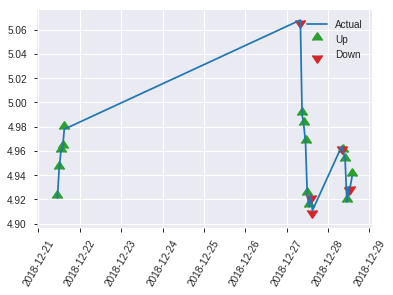


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25366514300955584
RMSE: 0.5036518073129053
LogLoss: 0.7004556908782082
Null degrees of freedom: 192
Residual degrees of freedom: 142
Null deviance: 267.41981442535183
Residual deviance: 270.3758966789884
AIC: 372.3758966789884
AUC: 0.5428104575163398
pr_auc: 0.5818229731413332
Gini: 0.08562091503267966
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.371280443766569: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      3    82   0.9647   (82.0/85.0)
1      0    108  0        (0.0/108.0)
Total  3    190  0.4249   (82.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37128      0.724832  189
max f2                       0.37128      0.868167  189
max f0point5                 0.37128      0.62212   189
max accuracy                 0.37128      0.57513   189
max precision                0.515376     0.677419  30
max recall                   0.37128      1         189
max specificity              0.629506     0.988235  0
max absolute_mcc             0.37128      0.14164   189
max min_per_class_accuracy   0.480116     0.537037  96
max mean_per_class_accuracy  0.473614     0.55049   103

Gains/Lift Table: Avg response rate: 55.96 %, avg score: 47.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.598479           0.893519  0.893519           0.5              0.622004  0.5                         0.622004            0.00925926      0.00925926                 -10.6481  -10.6481
    2        0.0207254                   0.568597           0         0.446759           0                0.588232  0.25                        0.605118            0               0.00925926                 -100      -55.3241
    3        0.0310881                   0.549115           1.78704   0.893519           1                0.559042  0.5                         0.589759            0.0185185       0.0277778                  78.7037   -10.6481
    4        0.0414508                   0.542803           0         0.670139           0                0.545904  0.375                       0.578795            0               0.0277778                  -100      -32.9861
    5        0.0518135                   0.537807           1.78704   0.893519           1                0.541308  0.5                         0.571298            0.0185185       0.0462963                  78.7037   -10.6481
    6        0.103627                    0.519731           1.25093   1.07222            0.7              0.526523  0.6                         0.548911            0.0648148       0.111111                   25.0926   7.22222
    7        0.150259                    0.515677           1.38992   1.17082            0.777778         0.517285  0.655172                    0.539096            0.0648148       0.175926                   38.9918   17.0817
    8        0.202073                    0.507651           1.25093   1.19136            0.7              0.510742  0.666667                    0.531826            0.0648148       0.240741                   25.0926   19.1358
    9        0.300518                    0.49464            0.940546  1.1092             0.526316         0.498935  0.62069                     0.521051            0.0925926       0.333333                   -5.94542  10.9195
    10       0.398964                    0.488172           0.940546  1.06758            0.526316         0.491197  0.597403                    0.513684            0.0925926       0.425926                   -5.94542  6.75806
    11       0.502591                    0.480116           1.07222   1.06854            0.6              0.483851  0.597938                    0.507533            0.111111        0.537037                   7.22222   6.85376
    12       0.601036                    0.467256           0.846491  1.03217            0.473684         0.47241   0.577586                    0.50178             0.0833333       0.62037                    -15.3509  3.21679
    13       0.699482                    0.45039            0.846491  1.00604            0.473684         0.460589  0.562963                    0.495983            0.0833333       0.703704                   -15.3509  0.603567
    14       0.797927                    0.429822           1.0346    1.00956            0.578947         0.439318  0.564935                    0.488992            0.101852        0.805556                   3.46004   0.955988
    15       0.896373                    0.410539           1.0346    1.01231            0.578947         0.420171  0.566474                    0.481433            0.101852        0.907407                   3.46004   1.231
    16       1                           0.235846           0.893519  1                  0.5              0.381185  0.559585                    0.471045    

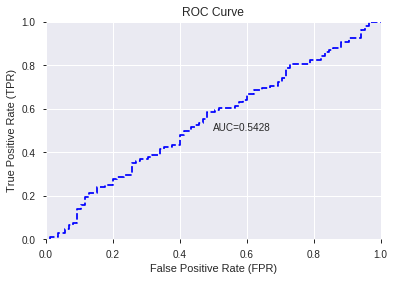

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


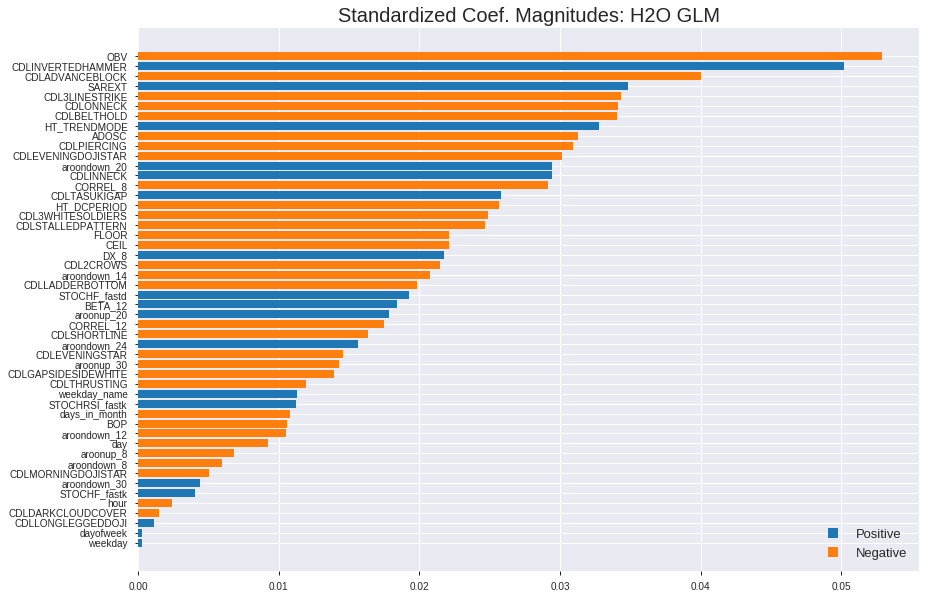

'log_likelihood'
--2019-08-25 14:57:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.201.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.201.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


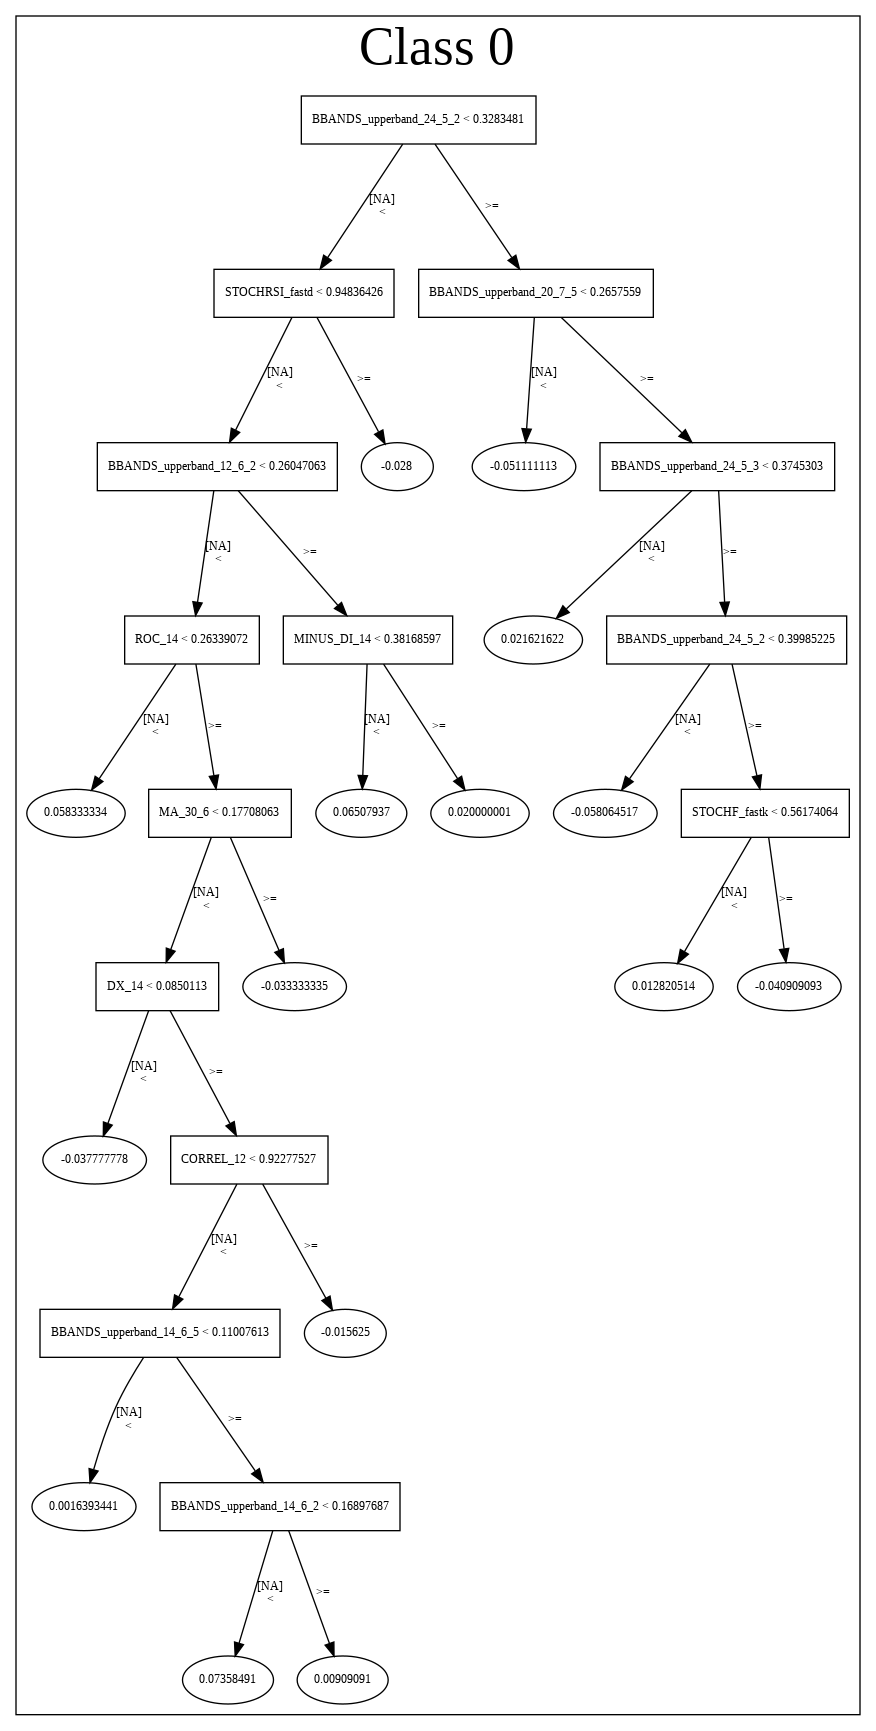

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_145658_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_145658_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_9982',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['OBV',
 'CDLINVERTEDHAMMER',
 'CDLADVANCEBLOCK',
 'SAREXT',
 'CDL3LINESTRIKE',
 'CDLONNECK',
 'CDLBELTHOLD',
 'HT_TRENDMODE',
 'ADOSC',
 'CDLPIERCING',
 'CDLEVENINGDOJISTAR',
 'aroondown_20',
 'CDLINNECK',
 'CORREL_8',
 'CDLTASUKIGAP',
 'HT_DCPERIOD',
 'CDL3WHITESOLDIERS',
 'CDLSTALLEDPATTERN',
 'FLOOR',
 'CEIL',
 'DX_8',
 'CDL2CROWS',
 'aroondown_14',
 'CDLLADDERBOTTOM',
 'STOCHF_fastd',
 'BETA_12',
 'aroonup_20',
 'CORREL_12',
 'CDLSHORTLINE',
 'aroondown_24',
 'CDLEVENINGSTAR',
 'aroonup_30',
 'CDLGAPSIDESIDEWHITE',
 'CDLTHRUSTING',
 'weekday_name',
 'STOCHRSI_fastk',
 'days_in_month',
 'BOP',
 'aroondown_12',
 'day',
 'aroonup_8',
 'aroondown_8',
 'CDLMORNINGDOJISTAR',
 'aroondown_30',
 'STOCHF_fastk',
 'hour',
 'CDLDARKCLOUDCOVER',
 'CDLLONGLEGGEDDOJI',
 'dayofweek',
 'weekday']

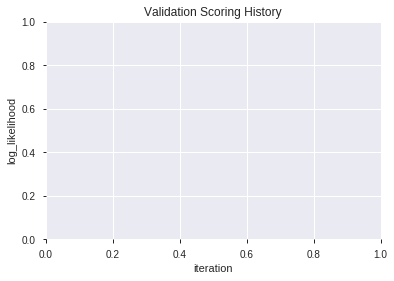

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_145714_model_1  0.611874  0.703049              0.500000  0.503808  0.253822
1  XGBoost_grid_1_AutoML_20190825_145714_model_7  0.593900  0.714786              0.494118  0.509494  0.259584
2  XGBoost_grid_1_AutoML_20190825_145714_model_4  0.585839  0.695951              0.400871  0.501432  0.251434
3  XGBoost_grid_1_AutoML_20190825_145714_model_3  0.575708  0.720404              0.500000  0.511730  0.261868
4               XGBoost_3_AutoML_20190825_145714  0.572440  0.712325              0.500000  0.508372  0.258442
5               XGBoost_2_AutoML_20190825_145714  0.564706  0.708305              0.464706  0.507295  0.257348
6  XGBoost_grid_1_AutoML_20190825_145714_model_2  0.562636  0.696195              0.465577  0.501455  0.251457
7               XGBoost_1_AutoML_20190825_145714  0.553486  0.717278              0.500000  0.510998  0.261119
8  XGBoost_grid_1_AutoML_20190825_145714_model_6  0.550763  0.721988              0.444172  0.513268  0.263444
9  XGBoost_grid_1_AutoML_20190825_145714_model_5  0.548257  0.727976              0.500000  0.515116  0.265344

variable  relative_importance  scaled_importance  percentage
0                 OBV           345.741669           1.000000    0.092751
1        STOCHF_fastd           310.178772           0.897140    0.083211
2              SAREXT           270.627930           0.782746    0.072601
3                DX_8           247.804672           0.716734    0.066478
4                 BOP           240.480850           0.695551    0.064513
5         HT_DCPERIOD           196.244766           0.567605    0.052646
6           CORREL_12           195.877625           0.566543    0.052548
7             BETA_12           192.796753           0.557632    0.051721
8               ADOSC           172.198029           0.498054    0.046195
9      STOCHRSI_fastk           166.814728           0.482484    0.044751
10       aroondown_30           166.343903           0.481122    0.044625
11         aroonup_30           153.773880           0.444765    0.041252
12           CORREL_8           130.882019           0.378554    0.035111
13       STOCHF_fastk           120.975151           0.349900    0.032454
14       aroondown_20           108.171646           0.312868    0.029019
15          aroonup_8            78.225044           0.226253    0.020985
16       aroondown_24            75.039757           0.217040    0.020131
17                day            68.121864           0.197031    0.018275
18       aroondown_14            65.332779           0.188964    0.017527
19       HT_TRENDMODE            64.302742           0.185985    0.017250
20         aroonup_20            58.524937           0.169274    0.015700
21               hour            58.009869           0.167784    0.015562
22          dayofweek            51.351627           0.148526    0.013776
23        aroondown_8            44.898014           0.129860    0.012045
24       aroondown_12            41.350723           0.119600    0.011093
25        CDLBELTHOLD            35.012695           0.101268    0.009393
26       weekday_name            23.602100           0.068265    0.006332
27      days_in_month            18.684387           0.054041    0.005012
28            weekday            14.218983           0.041126    0.003814
29       CDLSHORTLINE             8.428884           0.024379    0.002261
30  CDLLONGLEGGEDDOJI             3.609065           0.010439    0.000968

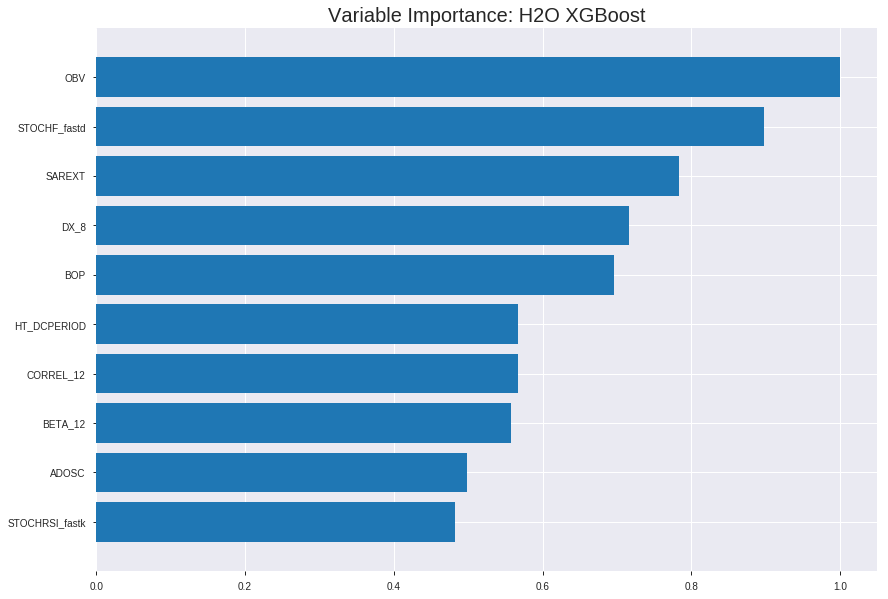

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_145714_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18454764725934278
RMSE: 0.42959009213358584
LogLoss: 0.5583970023273342
Mean Per-Class Error: 0.1425843130761164
AUC: 0.923539217309709
pr_auc: 0.9215228136656322
Gini: 0.847078434619418
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5134549617767334: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      589  82   0.1222   (82.0/671.0)
1      110  565  0.163    (110.0/675.0)
Total  699  647  0.1426   (192.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.513455     0.854766  189
max f2                       0.455373     0.902623  244
max f0point5                 0.533877     0.871512  168
max accuracy                 0.513455     0.857355  189
max precision                0.785686     1         0
max recall                   0.32734      1         355
max specificity              0.785686     1         0
max absolute_mcc             0.513455     0.715362  189
max min_per_class_accuracy   0.509409     0.851852  194
max mean_per_class_accuracy  0.513455     0.857416  189

Gains/Lift Table: Avg response rate: 50.15 %, avg score: 50.14 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.725405           1.99407    1.99407            1                0.746766  1                           0.746766            0.0207407       0.0207407                  99.4074   99.4074
    2        0.0200594                   0.705617           1.99407    1.99407            1                0.715952  1                           0.73193             0.0192593       0.04                       99.4074   99.4074
    3        0.0304606                   0.696757           1.99407    1.99407            1                0.702112  1                           0.721748            0.0207407       0.0607407                  99.4074   99.4074
    4        0.0401189                   0.682205           1.99407    1.99407            1                0.688543  1                           0.713754            0.0192593       0.08                       99.4074   99.4074
    5        0.0505201                   0.673628           1.99407    1.99407            1                0.678292  1                           0.706453            0.0207407       0.100741                   99.4074   99.4074
    6        0.100297                    0.639578           1.96431    1.9793             0.985075         0.656866  0.992593                    0.681843            0.0977778       0.198519                   96.4312   97.9303
    7        0.150074                    0.617574           1.84526    1.93484            0.925373         0.628143  0.970297                    0.664032            0.0918519       0.29037                    84.5263   93.4844
    8        0.200594                    0.596717           1.93542    1.93499            0.970588         0.607025  0.97037                     0.649675            0.0977778       0.388148                   93.5425   93.499
    9        0.300149                    0.564568           1.75598    1.87561            0.880597         0.579948  0.940594                    0.626547            0.174815        0.562963                   75.5976   87.5614
    10       0.400446                    0.539575           1.6248     1.81279            0.814815         0.551663  0.909091                    0.607792            0.162963        0.725926                   62.4801   81.2795
    11       0.5                         0.509129           1.25002    1.70074            0.626866         0.52366   0.852897                    0.59104             0.124444        0.85037                    25.0017   70.0741
    12       0.600297                    0.475869           0.709004   1.53504            0.355556         0.493853  0.769802                    0.574802            0.0711111       0.921481                   -29.0996  53.5042
    13       0.699851                    0.441905           0.476197   1.38442            0.238806         0.458482  0.694268                    0.558256            0.0474074       0.968889                   -52.3803  38.4421
    14       0.800149                    0.402383           0.206793   1.23681            0.103704         0.423287  0.620241                    0.541338            0.0207407       0.98963                    -79.3207  23.6807
    15       0.899703                    0.348402           0.0595246  1.10654            0.0298507        0.376295  0.554913                    0.523075            0.00592593      0.995556                   -94.0475  10.6538
    16       1                           0.18756            0.0443128  1                  0.0222222        0.307426  0.501486                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25349176121020944
RMSE: 0.5034796532236525
LogLoss: 0.7007982968110261
Mean Per-Class Error: 0.45443941079130834
AUC: 0.5415999782980224
pr_auc: 0.5259132563539415
Gini: 0.08319995659604484
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3399016559123993: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   180  0.9326   (180.0/193.0)
1      2    189  0.0105   (2.0/191.0)
Total  15   369  0.474    (182.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.339902     0.675     368
max f2                       0.320818     0.834798  373
max f0point5                 0.339902     0.566887  368
max accuracy                 0.6067       0.546875  94
max precision                0.669586     0.636364  21
max recall                   0.296795     1         380
max specificity              0.807673     0.994819  0
max absolute_mcc             0.339902     0.146806  368
max min_per_class_accuracy   0.543313     0.523316  191
max mean_per_class_accuracy  0.6067       0.545561  94

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 53.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.736429           1.00524   1.00524            0.5              0.769923  0.5                         0.769923            0.0104712       0.0104712                  0.52356   0.52356
    2        0.0208333                   0.710019           0.502618  0.753927           0.25             0.725265  0.375                       0.747594            0.0052356       0.0157068                  -49.7382  -24.6073
    3        0.03125                     0.69709            1.50785   1.00524            0.75             0.704034  0.5                         0.733074            0.0157068       0.0314136                  50.7853   0.52356
    4        0.0416667                   0.684908           1.50785   1.13089            0.75             0.689998  0.5625                      0.722305            0.0157068       0.0471204                  50.7853   13.089
    5        0.0520833                   0.674744           1.50785   1.20628            0.75             0.679409  0.6                         0.713726            0.0157068       0.0628272                  50.7853   20.6283
    6        0.101562                    0.64797            0.846514  1.03101            0.421053         0.659559  0.512821                    0.687337            0.0418848       0.104712                   -15.3486  3.10109
    7        0.151042                    0.629928           1.16396   1.07456            0.578947         0.637458  0.534483                    0.670997            0.0575916       0.162304                   16.3957   7.45622
    8        0.200521                    0.616234           1.37559   1.14884            0.684211         0.624437  0.571429                    0.659508            0.0680628       0.230366                   37.5586   14.8841
    9        0.299479                    0.594588           1.05814   1.11887            0.526316         0.605477  0.556522                    0.641654            0.104712        0.335079                   5.81427   11.8871
    10       0.401042                    0.566991           0.92791   1.07051            0.461538         0.580687  0.532468                    0.626215            0.0942408       0.429319                   -7.20902  7.05106
    11       0.5                         0.54311            0.952328  1.04712            0.473684         0.553868  0.520833                    0.611896            0.0942408       0.52356                    -4.76715  4.71204
    12       0.598958                    0.511752           1.11105   1.05768            0.552632         0.527225  0.526087                    0.597907            0.109948        0.633508                   11.105    5.76827
    13       0.700521                    0.489842           0.97946   1.04634            0.487179         0.500013  0.520446                    0.583714            0.0994764       0.732984                   -2.05397  4.63419
    14       0.799479                    0.447647           0.846514  1.02161            0.421053         0.470339  0.508143                    0.569681            0.0837696       0.816754                   -15.3486  2.16075
    15       0.898438                    0.405558           0.793607  0.996494           0.394737         0.431869  0.495652                    0.554501            0.078534        0.895288                   -20.6393  -0.350558
    16       1                           0.249103           1.03101   1                  0.512821         0.350829  0.497396                    0.533816       


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 14:57:17  0.015 sec   0                  0.5              0.693147            0.5             0                  1                0.498514                         0.5                0.693147              0.5               0                    1                  0.502604
    2019-08-25 14:57:17  0.117 sec   5                  0.490546         0.674369            0.714232        0.713843           1.80416          0.397474                         0.500068           0.69328               0.525432          0.535401             1.00524            0.502604
    2019-08-25 14:57:17  0.164 sec   10                 0.482336         0.65826             0.771186        0.768029           1.99407          0.311293                         0.499833           0.692797              0.539986          0.540877             1.00524            0.492188
    2019-08-25 14:57:17  0.218 sec   15                 0.475123         0.644229            0.807506        0.803717           1.99407          0.274146                         0.499126           0.691389              0.556032          0.545922             1.00524            0.489583
    2019-08-25 14:57:17  0.268 sec   20                 0.467263         0.629039            0.832434        0.827606           1.99407          0.244428                         0.498461           0.690063              0.565391          0.562914             0.502618           0.489583
    2019-08-25 14:57:17  0.320 sec   25                 0.459033         0.613324            0.863295        0.860623           1.99407          0.235513                         0.498786           0.69076               0.563478          0.555849             0.502618           0.486979
    2019-08-25 14:57:17  0.369 sec   30                 0.4531           0.602061            0.87722         0.87294            1.99407          0.203566                         0.500192           0.693663              0.553292          0.544663             0.502618           0.486979
    2019-08-25 14:57:17  0.421 sec   35                 0.44713          0.590857            0.893469        0.890872           1.99407          0.192422                         0.50035            0.694031              0.552695          0.543146             0.502618           0.476562
    2019-08-25 14:57:17  0.478 sec   40                 0.440875         0.579228            0.906417        0.903267           1.99407          0.180535                         0.501565           0.696658              0.547025          0.534596             0.502618           0.473958
    2019-08-25 14:57:17  0.536 sec   45                 0.434743         0.567793            0.913028        0.909564           1.99407          0.161218                         0.503206           0.70017               0.540569          0.52549              0.502618           0.476562
    2019-08-25 14:57:17  0.587 sec   50                 0.42959          0.558397            0.923539        0.921523           1.99407          0.142645                         0.50348            0.700798              0.5416            0.525913             1.00524            0.473958

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
OBV                345.7416687011719      1.0                   0.09275117233104135
STOCHF_fastd       310.17877197265625     0.897140264110737     0.08321081124165092
SAREXT             270.6279296875         0.7827460621224875    0.07260061489936685
DX_8               247.80467224121094     0.7167336039422865    0.06647788201469935
BOP                240.48085021972656     0.6955506726253949    0.06451314030164974
---                ---                    ---                   ---
weekday_name       23.602100372314453     0.06826513119167593   0.006331670947360281
days_in_month      18.68438720703125      0.05404146765769318   0.005012409479741098
weekday            14.218982696533203     0.04112603132260236   0.0038144876184944966
CDLSHORTLINE       8.42888355255127       0.024379137129220144  0.0022611935491543868
CDLLONGLEGGEDDOJI  3.609064817428589      0.010438616875387217  0.0009681939527067562


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6269430051813472)

('F1', 0.717607973421927)

('auc', 0.6118736383442266)

('logloss', 0.7030487838754524)

('mean_per_class_error', 0.3709150326797386)

('rmse', 0.5038078343701194)

('mse', 0.2538223339727097)

xgboost prediction progress: |████████████████████████████████████████████| 100%


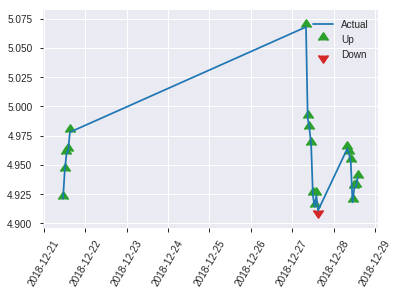


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2538223339727097
RMSE: 0.5038078343701194
LogLoss: 0.7030487838754524
Mean Per-Class Error: 0.3709150326797386
AUC: 0.6118736383442266
pr_auc: 0.6334605097435584
Gini: 0.22374727668845318
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20924228429794312: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      0    85   1        (85.0/85.0)
1      0    108  0        (0.0/108.0)
Total  0    193  0.4404   (85.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.209242     0.717608  192
max f2                       0.209242     0.864     192
max f0point5                 0.451495     0.670732  95
max accuracy                 0.451495     0.626943  95
max precision                0.732928     1         0
max recall                   0.209242     1         192
max specificity              0.732928     1         0
max absolute_mcc             0.451495     0.256334  95
max min_per_class_accuracy   0.446035     0.623529  99
max mean_per_class_accuracy  0.451495     0.629085  95

Gains/Lift Table: Avg response rate: 55.96 %, avg score: 44.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.707122           1.78704   1.78704            1                0.725533  1                           0.725533            0.0185185       0.0185185                  78.7037   78.7037
    2        0.0207254                   0.695277           0         0.893519           0                0.702918  0.5                         0.714226            0               0.0185185                  -100      -10.6481
    3        0.0310881                   0.685541           1.78704   1.19136            1                0.690969  0.666667                    0.706473            0.0185185       0.037037                   78.7037   19.1358
    4        0.0414508                   0.679091           1.78704   1.34028            1                0.684578  0.75                        0.701               0.0185185       0.0555556                  78.7037   34.0278
    5        0.0518135                   0.668385           0         1.07222            0                0.675538  0.6                         0.695907            0               0.0555556                  -100      7.22222
    6        0.103627                    0.606924           1.07222   1.07222            0.6              0.626831  0.6                         0.661369            0.0555556       0.111111                   7.22222   7.22222
    7        0.150259                    0.564374           1.38992   1.17082            0.777778         0.582573  0.655172                    0.636915            0.0648148       0.175926                   38.9918   17.0817
    8        0.202073                    0.540728           1.25093   1.19136            0.7              0.554515  0.666667                    0.615787            0.0648148       0.240741                   25.0926   19.1358
    9        0.300518                    0.498089           1.0346    1.14001            0.578947         0.516471  0.637931                    0.583252            0.101852        0.342593                   3.46004   14.0006
    10       0.398964                    0.465552           1.41082   1.20683            0.789474         0.4834    0.675325                    0.558614            0.138889        0.481481                   41.0819   20.683
    11       0.502591                    0.451247           1.25093   1.21592            0.7              0.458371  0.680412                    0.537945            0.12963         0.611111                   25.0926   21.5922
    12       0.601036                    0.42916            0.846491  1.15541            0.473684         0.438394  0.646552                    0.521639            0.0833333       0.694444                   -15.3509  15.5412
    13       0.699482                    0.377063           0.846491  1.11193            0.473684         0.400417  0.622222                    0.504578            0.0833333       0.777778                   -15.3509  11.1934
    14       0.797927                    0.341919           0.658382  1.05598            0.368421         0.359953  0.590909                    0.486735            0.0648148       0.842593                   -34.1618  5.59764
    15       0.896373                    0.294716           0.470273  0.991651           0.263158         0.322103  0.554913                    0.468654            0.0462963       0.888889                   -52.9727  -0.834939
    16       1                           0.209242           1.07222   1                  0.6              0.25503   0.559585                    0.446517       

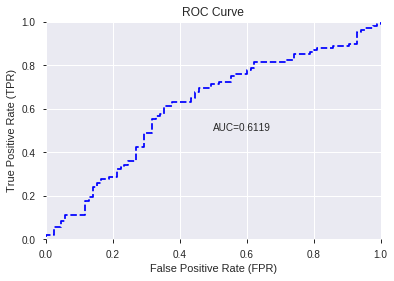

This function is available for GLM models only


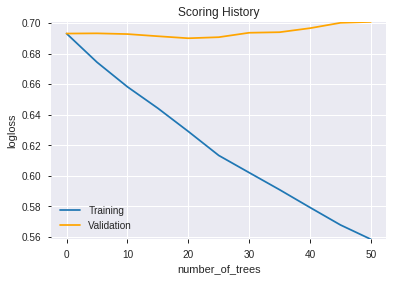

--2019-08-25 14:57:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

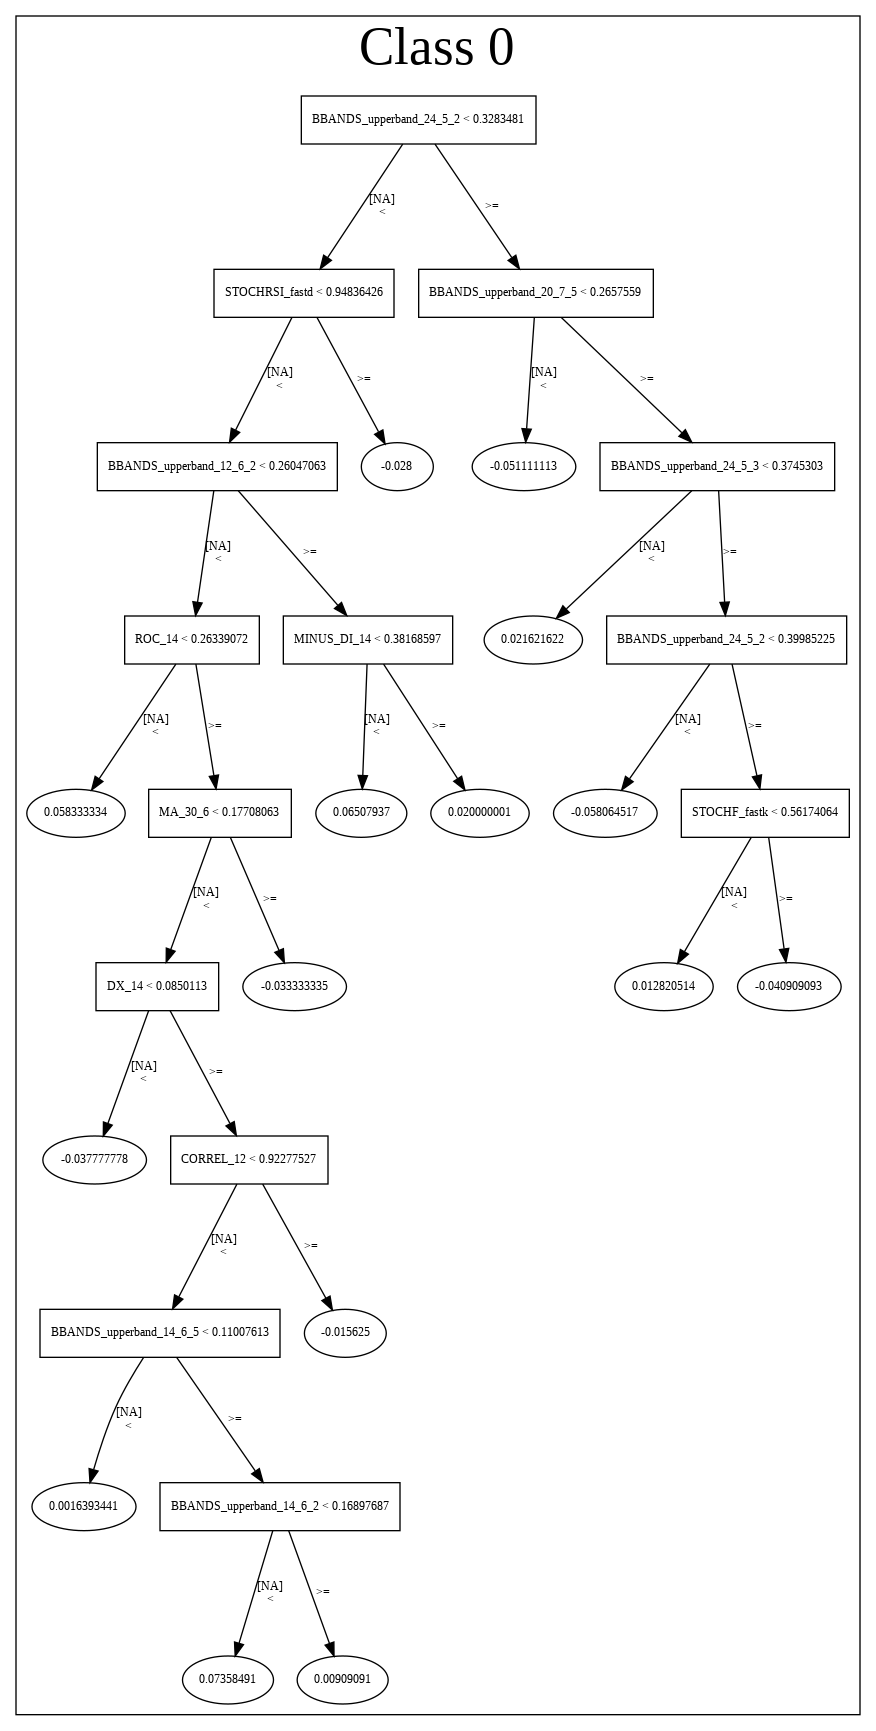

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_145714_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_145714_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_9982',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['OBV',
 'STOCHF_fastd',
 'SAREXT',
 'DX_8',
 'BOP',
 'HT_DCPERIOD',
 'CORREL_12',
 'BETA_12',
 'ADOSC',
 'STOCHRSI_fastk',
 'aroondown_30',
 'aroonup_30',
 'CORREL_8',
 'STOCHF_fastk',
 'aroondown_20',
 'aroonup_8',
 'aroondown_24',
 'day',
 'aroondown_14',
 'HT_TRENDMODE',
 'aroonup_20',
 'hour',
 'dayofweek',
 'aroondown_8',
 'aroondown_12',
 'CDLBELTHOLD',
 'weekday_name',
 'days_in_month',
 'weekday',
 'CDLSHORTLINE',
 'CDLLONGLEGGEDDOJI']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 917 930 936] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_145741_model_1  0.604031  17.402623              0.436166  0.748051  0.559581
1  DeepLearning_grid_1_AutoML_20190825_145741_model_4  0.587582   1.002693              0.429031  0.582676  0.339512
2  DeepLearning_grid_1_AutoML_20190825_145741_model_3  0.572549   0.704839              0.482353  0.505115  0.255142
3  DeepLearning_grid_1_AutoML_20190825_145741_model_9  0.555556   0.715423              0.470588  0.510940  0.261060
4  DeepLearning_grid_1_AutoML_20190825_145741_model_2  0.513725   0.846419              0.488235  0.560402  0.314050
5  DeepLearning_grid_1_AutoML_20190825_145741_model_6  0.509041   0.695780              0.500000  0.501315  0.251316
6               DeepLearning_1_AutoML_20190825_145741  0.500000   0.698293              0.500000  0.502565  0.252571
7  DeepLearning_grid_1_AutoML_20190825_145741_model_5  0.500000   0.696563              0.500000  0.501704  0.251707
8  DeepLearning_grid_1_AutoML_20190825_145741_model_8  0.500000   0.693158              0.500000  0.500005  0.250005
9  DeepLearning_grid_1_AutoML_20190825_145741_model_7  0.494118   0.699526              0.500000  0.502817  0.252825

variable  relative_importance  scaled_importance  percentage
0              CDLMORNINGSTAR             1.000000           1.000000    0.001314
1               CDLHANGINGMAN             0.981121           0.981121    0.001289
2           CDLINVERTEDHAMMER             0.959013           0.959013    0.001260
3                   CDLHAMMER             0.947833           0.947833    0.001245
4                   CDLTAKURI             0.944135           0.944135    0.001240
...                       ...                  ...                ...         ...
1033  BBANDS_middleband_8_8_5             0.666996           0.666996    0.000876
1034  BBANDS_upperband_12_5_2             0.666753           0.666753    0.000876
1035   BBANDS_lowerband_8_6_5             0.659472           0.659472    0.000866
1036            MINMAX_max_20             0.654854           0.654854    0.000860
1037                     SINH             0.644022           0.644022    0.000846

[1038 rows x 4 columns]

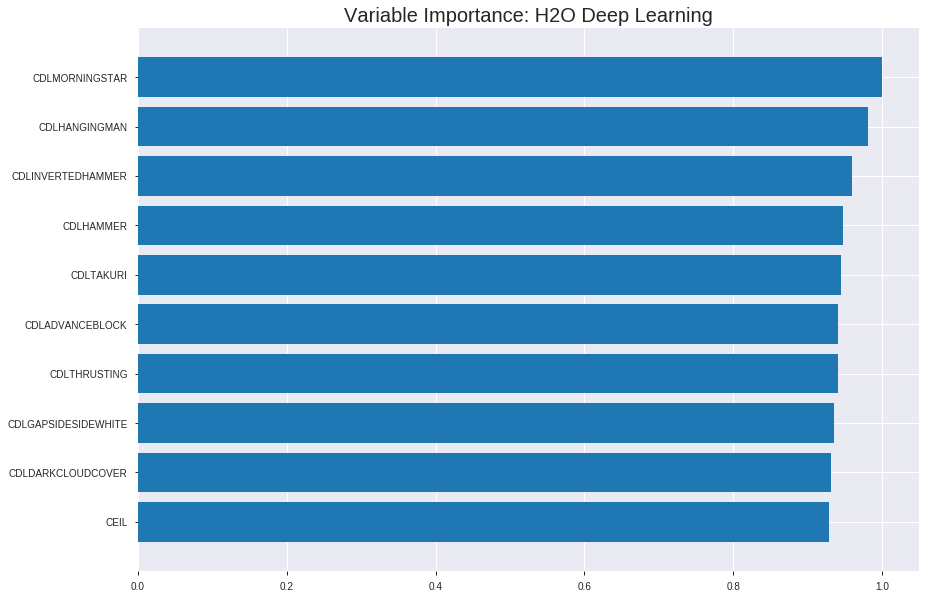

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_145741_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.27668126088920625
RMSE: 0.526005000821481
LogLoss: 1.3872846690918696
Mean Per-Class Error: 0.3154771761329138
AUC: 0.740487939504333
pr_auc: 0.694800051707405
Gini: 0.480975879008666
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.011193513700490324: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      351  320  0.4769   (320.0/671.0)
1      131  544  0.1941   (131.0/675.0)
Total  482  864  0.3351   (451.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0111935    0.706953  377
max f2                       2.38747e-05  0.834157  399
max f0point5                 0.295322     0.695652  245
max accuracy                 0.295322     0.68425   245
max precision                0.999968     0.972973  0
max recall                   2.38747e-05  1         399
max specificity              0.999968     0.99851   0
max absolute_mcc             0.295322     0.375366  245
max min_per_class_accuracy   0.0958036    0.677037  316
max mean_per_class_accuracy  0.295322     0.684523  245

Gains/Lift Table: Avg response rate: 50.15 %, avg score: 35.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.999999           1.99407   1.99407            1                1            1                           1                   0.0207407       0.0207407                  99.4074   99.4074
    2        0.0200594                   0.999963           1.99407   1.99407            1                0.999987     1                           0.999994            0.0192593       0.04                       99.4074   99.4074
    3        0.0304606                   0.999745           1.70921   1.8968             0.857143         0.999858     0.95122                     0.999947            0.0177778       0.0577778                  70.9206   89.6802
    4        0.0401189                   0.99955            1.68729   1.84636            0.846154         0.999665     0.925926                    0.999879            0.0162963       0.0740741                  68.7293   84.6365
    5        0.0505201                   0.999081           1.85164   1.84745            0.928571         0.999313     0.926471                    0.999763            0.0192593       0.0933333                  85.164    84.7451
    6        0.100297                    0.993409           1.66669   1.75774            0.835821         0.996961     0.881481                    0.998372            0.082963        0.176296                   66.6689   75.7739
    7        0.150074                    0.971201           1.51788   1.67818            0.761194         0.984058     0.841584                    0.993624            0.0755556       0.251852                   51.7877   67.8181
    8        0.200594                    0.915224           1.31961   1.58787            0.661765         0.947086     0.796296                    0.981904            0.0666667       0.318519                   31.9608   58.7874
    9        0.300149                    0.656642           1.39883   1.52517            0.701493         0.796451     0.764851                    0.920392            0.139259        0.457778                   39.8828   52.5171
    10       0.400446                    0.318525           1.21122   1.44654            0.607407         0.48233      0.725417                    0.810673            0.121481        0.579259                   21.1215   44.6536
    11       0.5                         0.0948431          0.982156  1.35407            0.492537         0.193244     0.679049                    0.687738            0.0977778       0.677037                   -1.78441  35.4074
    12       0.600297                    0.0248387          0.974881  1.29072            0.488889         0.0509354    0.647277                    0.581341            0.0977778       0.774815                   -2.51193  29.0719
    13       0.699851                    0.00431284         0.610127  1.1939             0.30597          0.0109853    0.598726                    0.500208            0.0607407       0.835556                   -38.9873  19.3904
    14       0.800149                    0.000782027        0.679462  1.12942            0.340741         0.00209542   0.566388                    0.43777             0.0681481       0.903704                   -32.0538  12.942
    15       0.899703                    5.45731e-05        0.580365  1.06867            0.291045         0.000289459  0.535921                    0.389362            0.0577778       0.961481                   -41.9635  6.86656
    16       1                           3.52447e-16        0.384044  1                  0.192593         1.260



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.45942883652071403
RMSE: 0.6778118002223877
LogLoss: 4.050944787508531
Mean Per-Class Error: 0.47190950275343846
AUC: 0.47456799500854513
pr_auc: 0.48610730446970596
Gini: -0.05086400998290974
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.7831699769119388e-14: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    184  0.9534   (184.0/193.0)
1      1    190  0.0052   (1.0/191.0)
Total  10   374  0.4818   (185.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.78317e-14  0.672566  372
max f2                       1.78317e-14  0.834798  372
max f0point5                 1.78317e-14  0.56313   372
max accuracy                 1.09649e-09  0.526042  341
max precision                0.999975     0.75      6
max recall                   5.7336e-17   1         378
max specificity              1            0.989637  0
max absolute_mcc             1.78317e-14  0.129964  372
max min_per_class_accuracy   0.0413542    0.460733  187
max mean_per_class_accuracy  1.09649e-09  0.52809   341

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 29.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.999999           1.00524   1.00524            0.5              0.999999     0.5                         0.999999            0.0104712       0.0104712                  0.52356   0.52356
    2        0.0208333                   0.999955           2.01047   1.50785            1                0.999987     0.75                        0.999993            0.0209424       0.0314136                  101.047   50.7853
    3        0.03125                     0.999793           1.00524   1.34031            0.5              0.999925     0.666667                    0.999971            0.0104712       0.0418848                  0.52356   34.0314
    4        0.0416667                   0.999396           0.502618  1.13089            0.25             0.999604     0.5625                      0.999879            0.0052356       0.0471204                  -49.7382  13.089
    5        0.0520833                   0.998159           1.00524   1.10576            0.5              0.998733     0.55                        0.99965             0.0104712       0.0575916                  0.52356   10.5759
    6        0.101562                    0.98346            0.846514  0.97946            0.421053         0.993185     0.487179                    0.9965              0.0418848       0.0994764                  -15.3486  -2.05397
    7        0.151042                    0.940984           0.952328  0.970572           0.473684         0.967395     0.482759                    0.986966            0.0471204       0.146597                   -4.76715  -2.94277
    8        0.200521                    0.828955           1.16396   1.01829            0.578947         0.883998     0.506494                    0.961558            0.0575916       0.204188                   16.3957   1.82906
    9        0.299479                    0.427568           0.7407    0.926565           0.368421         0.663862     0.46087                     0.863189            0.0732984       0.277487                   -25.93    -7.3435
    10       0.401042                    0.152986           0.97946   0.939961           0.487179         0.286196     0.467532                    0.717068            0.0994764       0.376963                   -2.05397  -6.00394
    11       0.5                         0.0389262          0.846514  0.921466           0.421053         0.0812862    0.458333                    0.591236            0.0837696       0.460733                   -15.3486  -7.8534
    12       0.598958                    0.00440292         1.00524   0.935306           0.5              0.0188938    0.465217                    0.496675            0.0994764       0.560209                   0.52356   -6.46938
    13       0.700521                    0.000524225        1.28876   0.986551           0.641026         0.00189887   0.490706                    0.424942            0.13089         0.691099                   28.8764   -1.34491
    14       0.799479                    1.19506e-05        1.00524   0.988864           0.5              0.000146958  0.491857                    0.372361            0.0994764       0.790576                   0.52356   -1.11363
    15       0.898438                    2.34129e-10        1.32268   1.02563            0.657895         1.68341e-06  0.510145                    0.331348            0.13089         0.921466                   32.2678   2.56317
    16       1                           2.9887e-26         0.773258  1                  0.384615        


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 14:57:44  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 14:57:49  6.471 sec         302 obs/sec       1.22214   1             1645       0.654711         3.60194             -0.714602      0.53809         0.522164           1.70921          0.498514                         0.663996           4.72815               -0.763609        0.502238          0.484877             1.50785            0.5
    2019-08-25 14:58:00  17.099 sec        321 obs/sec       3.70134   3             4982       0.633944         3.28704             -0.607557      0.591777        0.420271           1.42434          0.498514                         0.699233           5.87554               -0.955758        0.483629          0.442201             1.00524            0.497396
    2019-08-25 14:58:10  27.578 sec        326 obs/sec       6.16642   5             8300       0.588127         3.38808             -0.383587      0.634732        0.381597           1.53034          0.427935                         0.688278           4.82792               -0.894957        0.50704           0.439911             2.01047            0.489583
    2019-08-25 14:58:21  38.087 sec        328 obs/sec       8.62853   7             11614      0.561766         1.82059             -0.262337      0.674049        0.524805           1.85164          0.396731                         0.662983           4.32543               -0.758235        0.485704          0.479779             1.00524            0.489583
    2019-08-25 14:58:32  48.650 sec        330 obs/sec       11.1322   9             14984      0.563777         1.79254             -0.271388      0.694942        0.595121           1.85164          0.399703                         0.689113           4.7271                -0.899561        0.474595          0.484367             1.00524            0.494792
    2019-08-25 14:58:42  58.787 sec        332 obs/sec       13.578    11            18276      0.586097         2.19386             -0.374051      0.646485        0.508495           1.70921          0.409361                         0.692127           5.2713                -0.916212        0.464178          0.429378             0.879581           0.502604
    2019-08-25 14:58:52  1 min  9.212 sec  334 obs/sec       16.1077   13            21681      0.526005         1.38728             -0.106735      0.740488        0.6948             1.99407          0.335067                         0.677812           4.05094               -0.837765        0.474568          0.486107             1.00524            0.481771
    2019-08-25 14:59:02  1 min 19.370 sec  336 obs/sec       18.5973   15            25032      0.54719          1.62183             -0.197679      0.714861        0.514847           1.85164          0.368499                         0.678803           4.27053               -0.843142        0.487671          0.436543             1.00524            0.494792
    2019-08-25 14:59:03  1 m

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CDLMORNINGSTAR           1.0                    1.0                  0.0013135260996603
CDLHANGINGMAN            0.9811207056045532     0.9811207056045532   0.0012887276537287102
CDLINVERTEDHAMMER        0.9590134024620056     0.9590134024620056   0.0012596891340578716
CDLHAMMER                0.9478326439857483     0.9478326439857483   0.0012450029159853096
CDLTAKURI                0.9441352486610413     0.9441352486610413   0.001240146290725545
---                      ---                    ---                  ---
BBANDS_middleband_8_8_5  0.666996419429779      0.666996419429779    0.0008761172053009832
BBANDS_upperband_12_5_2  0.6667531728744507     0.6667531728744507   0.0008757976946019069
BBANDS_lowerband_8_6_5   0.6594718098640442     0.6594718098640442   0.0008662334342466368
MINMAX_max_20            0.6548543572425842     0.6548543572425842   0.0008601682897144043
SINH                     0.6440218091011047     0.6440218091011047   0.0008459394550047444


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6217616580310881)

('F1', 0.7349823321554771)

('auc', 0.6040305010893247)

('logloss', 17.40262275460643)

('mean_per_class_error', 0.39907407407407414)

('rmse', 0.748051479628329)

('mse', 0.5595810161741323)

deeplearning prediction progress: |███████████████████████████████████████| 100%


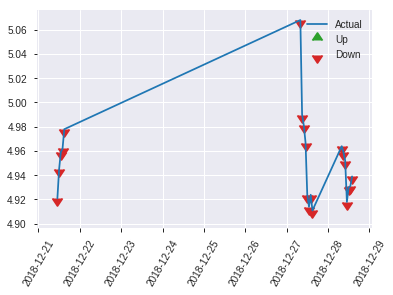


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5595810161741323
RMSE: 0.748051479628329
LogLoss: 17.40262275460643
Mean Per-Class Error: 0.39907407407407414
AUC: 0.6040305010893247
pr_auc: 0.654308221991467
Gini: 0.2080610021786493
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.569501200233592e-20: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      14   71   0.8353   (71.0/85.0)
1      4    104  0.037    (4.0/108.0)
Total  18   175  0.3886   (75.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.5695e-20   0.734982  174
max f2                       1.6208e-22   0.868167  189
max f0point5                 5.01711e-20  0.651316  162
max accuracy                 5.01711e-20  0.621762  162
max precision                0.000430656  1         0
max recall                   1.6208e-22   1         189
max specificity              0.000430656  1         0
max absolute_mcc             4.38663e-20  0.227258  164
max min_per_class_accuracy   1.5998e-17   0.6       98
max mean_per_class_accuracy  1.5998e-17   0.600926  98

Gains/Lift Table: Avg response rate: 55.96 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   3.4347e-07         1.78704   1.78704            1                0.00021575   1                           0.00021575          0.0185185       0.0185185                  78.7037   78.7037
    2        0.0207254                   5.44034e-08        1.78704   1.78704            1                2.16282e-07  1                           0.000107983         0.0185185       0.037037                   78.7037   78.7037
    3        0.0310881                   1.69494e-08        1.78704   1.78704            1                3.45096e-08  1                           7.20001e-05         0.0185185       0.0555556                  78.7037   78.7037
    4        0.0414508                   1.23132e-08        0.893519  1.56366            0.5              1.27615e-08  0.875                       5.40033e-05         0.00925926      0.0648148                  -10.6481  56.3657
    5        0.0518135                   1.88042e-09        1.78704   1.60833            1                7.20599e-09  0.9                         4.32041e-05         0.0185185       0.0833333                  78.7037   60.8333
    6        0.103627                    3.28041e-11        0.893519  1.25093            0.5              6.89179e-10  0.7                         2.16024e-05         0.0462963       0.12963                    -10.6481  25.0926
    7        0.150259                    4.6326e-12         1.19136   1.23244            0.666667         1.03924e-11  0.689655                    1.48982e-05         0.0555556       0.185185                   19.1358   23.2439
    8        0.202073                    4.34194e-13        1.25093   1.23718            0.7              1.72996e-12  0.692308                    1.10781e-05         0.0648148       0.25                       25.0926   23.7179
    9        0.300518                    7.40286e-15        0.846491  1.1092             0.473684         9.25397e-14  0.62069                     7.4491e-06          0.0833333       0.333333                   -15.3509  10.9195
    10       0.398964                    2.32073e-16        1.12865   1.114              0.631579         1.56913e-15  0.623377                    5.61101e-06         0.111111        0.444444                   12.8655   11.3997
    11       0.502591                    2.1002e-17         1.34028   1.16065            0.75             8.05386e-17  0.649485                    4.4541e-06          0.138889        0.583333                   34.0278   16.0653
    12       0.601036                    6.97793e-18        0.846491  1.1092             0.473684         1.10029e-17  0.62069                     3.72455e-06         0.0833333       0.666667                   -15.3509  10.9195
    13       0.699482                    1.50391e-18        0.846491  1.07222            0.473684         3.55159e-18  0.6                         3.20035e-06         0.0833333       0.75                       -15.3509  7.22222
    14       0.797927                    1.27283e-19        0.846491  1.04437            0.473684         4.86996e-19  0.584416                    2.8055e-06          0.0833333       0.833333                   -15.3509  4.43723
    15       0.896373                    2.20736e-20        1.12865   1.05363            0.631579         6.04637e-20  0.589595                    2.49738e-06         0.111111        0.944444                   12.8655   5.36288
    16       1                           1.83596e-23        0.536111  1                  0.3              4.56

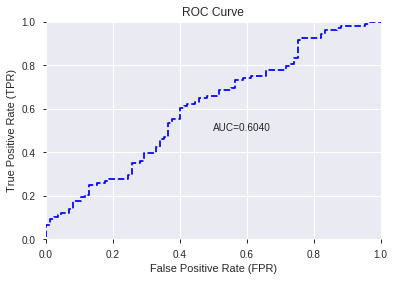

This function is available for GLM models only


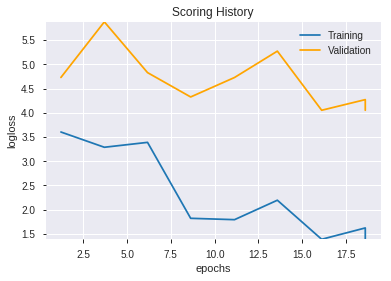

--2019-08-25 15:16:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


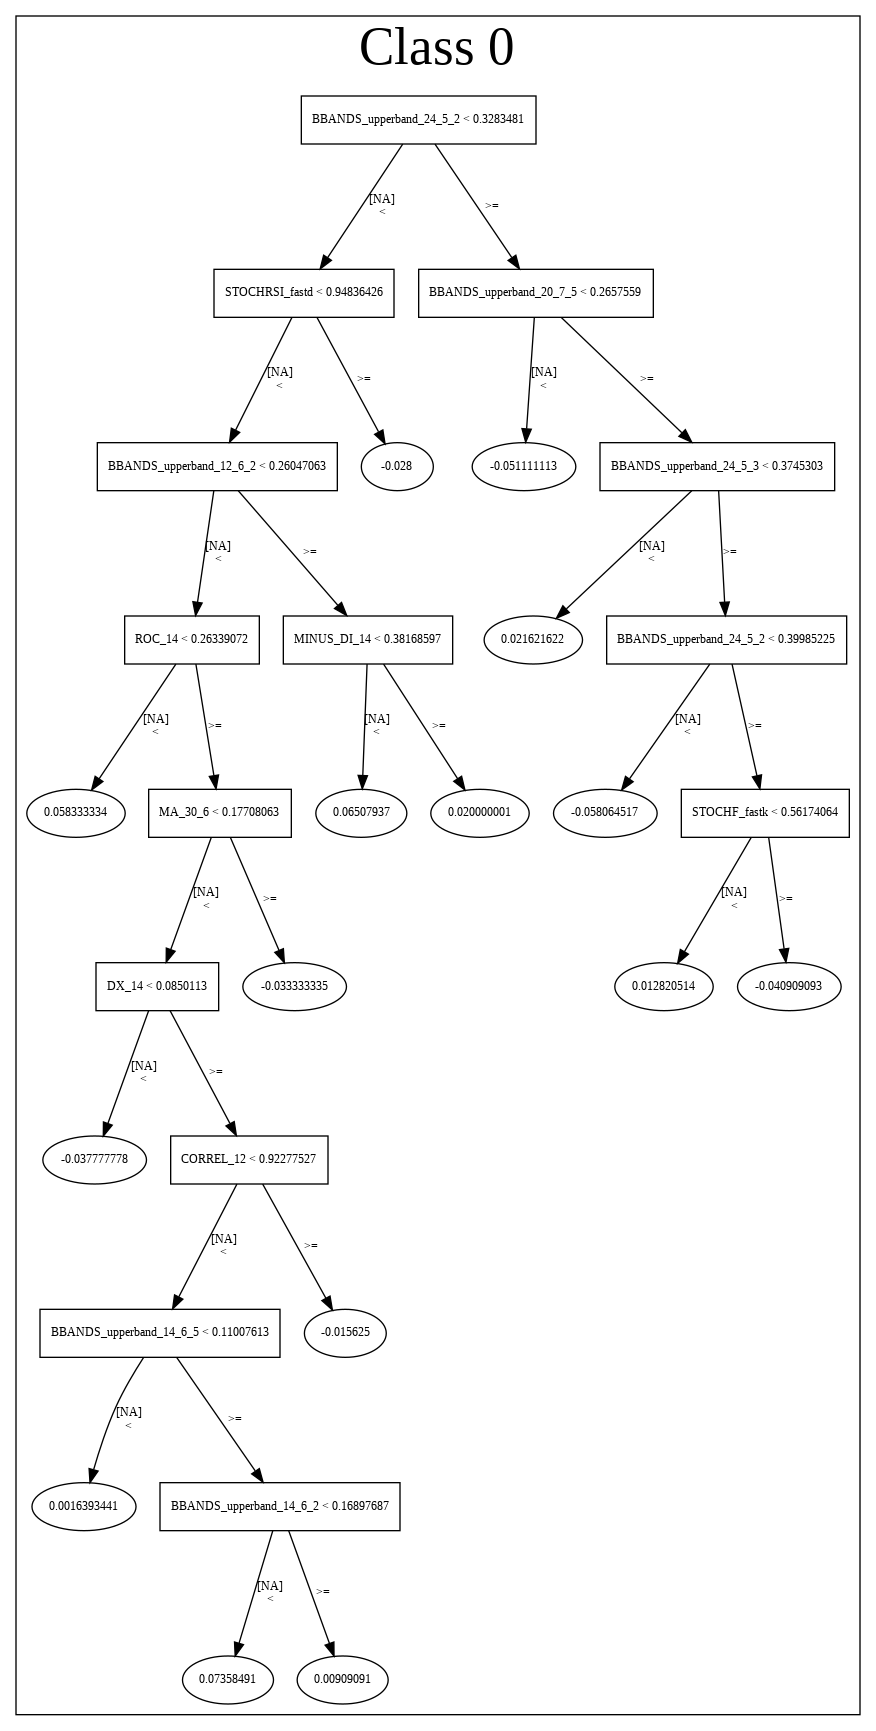

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_145741_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_145741_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_9982',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLMORNINGSTAR',
 'CDLHANGINGMAN',
 'CDLINVERTEDHAMMER',
 'CDLHAMMER',
 'CDLTAKURI',
 'CDLADVANCEBLOCK',
 'CDLTHRUSTING',
 'CDLGAPSIDESIDEWHITE',
 'CDLDARKCLOUDCOVER',
 'CEIL',
 'is_month_start',
 'FLOOR',
 'CDLMORNINGDOJISTAR',
 'CDLONNECK',
 'CDLLADDERBOTTOM',
 'CDLGRAVESTONEDOJI',
 'CDLINNECK',
 'CDL3LINESTRIKE',
 'CDL2CROWS',
 'CDLHOMINGPIGEON',
 'CDLEVENINGDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLSHOOTINGSTAR',
 'CDLPIERCING',
 'days_in_month',
 'CDLEVENINGSTAR',
 'CDLTASUKIGAP',
 'CDL3WHITESOLDIERS',
 'CDLMATCHINGLOW',
 'CDLRICKSHAWMAN',
 'OBV',
 'CDLHARAMICROSS',
 'is_month_end',
 'CORREL_8',
 'VAR_14',
 'CORREL_12',
 'CDLSEPARATINGLINES',
 'HT_TRENDMODE',
 'CDLXSIDEGAP3METHODS',
 'CORREL_14',
 'VAR_12',
 'MFI_24',
 'MFI_8',
 'aroonup_8',
 'aroondown_14',
 'CDLLONGLEGGEDDOJI',
 'CDLSTALLEDPATTERN',
 'aroondown_8',
 'BBANDS_lowerband_12_0_3',
 'aroondown_20',
 'BETA_8',
 'STDDEV_14',
 'MFI_12',
 'LINEARREG_SLOPE_8',
 'BETA_20',
 'CDL3INSIDE',
 'ROCP_20',
 'aroondown_24',
 'DX_8',
 

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse      mse
0  GLM_grid_1_AutoML_20190825_151654_model_1  0.582462  0.759596              0.472712  0.53114  0.28211

variable  relative_importance  scaled_importance    percentage
0          CDLXSIDEGAP3METHODS         8.372129e-03           1.000000  1.305836e-02
1            CDLINVERTEDHAMMER         7.370318e-03           0.880340  1.149580e-02
2                CDLHANGINGMAN         5.996997e-03           0.716305  9.353769e-03
3              CDLADVANCEBLOCK         5.907946e-03           0.705668  9.214873e-03
4                          OBV         5.457818e-03           0.651903  8.512789e-03
...                        ...                  ...                ...           ...
1033   BBANDS_middleband_8_5_2         1.174823e-06           0.000140  1.832422e-06
1034  BBANDS_middleband_20_1_4         9.340098e-07           0.000112  1.456815e-06
1035                   MA_20_6         6.660836e-07           0.000080  1.038919e-06
1036  BBANDS_middleband_20_6_3         3.133592e-07           0.000037  4.887595e-07
1037    LINEARREG_INTERCEPT_20         1.163271e-07           0.000014  1.814403e-07

[1038 rows x 4 columns]

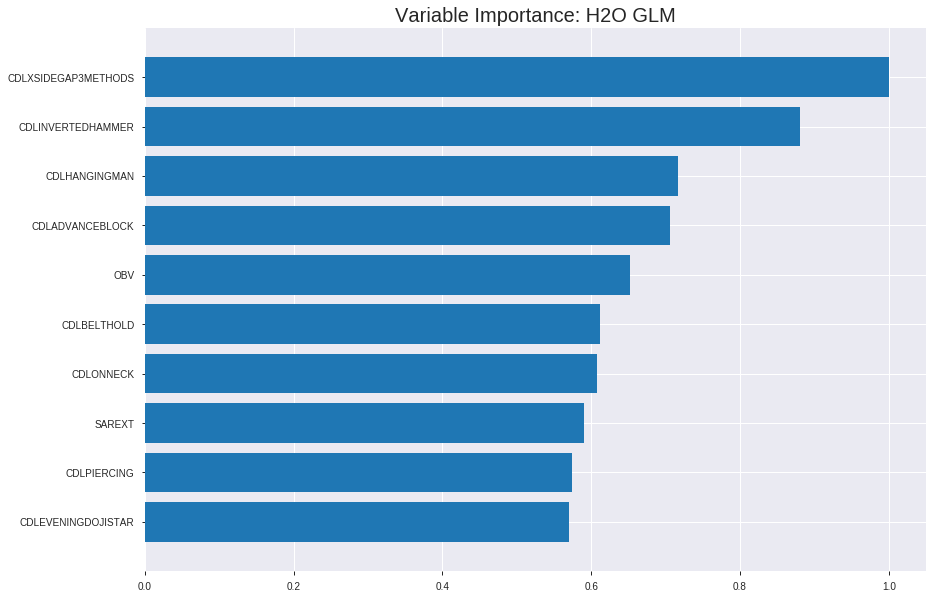

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_151654_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24661529128689116
RMSE: 0.4966037568191477
LogLoss: 0.6863508854406474
Null degrees of freedom: 1345
Residual degrees of freedom: 307
Null deviance: 1865.9403229770678
Residual deviance: 1847.6565836062227
AIC: 3925.6565836062227
AUC: 0.5755676988463874
pr_auc: 0.5723139847209038
Gini: 0.15113539769277473
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4418848324337508: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      20   651   0.9702   (651.0/671.0)
1      4    671   0.0059   (4.0/675.0)
Total  24   1322  0.4866   (655.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.441885     0.672008  382
max f2                       0.431273     0.835189  394
max f0point5                 0.470385     0.576349  303
max accuracy                 0.516916     0.554235  148
max precision                0.577288     0.875     5
max recall                   0.431273     1         394
max specificity              0.590676     0.99851   0
max absolute_mcc             0.470385     0.127724  303
max min_per_class_accuracy   0.501084     0.546945  202
max mean_per_class_accuracy  0.516916     0.554756  148

Gains/Lift Table: Avg response rate: 50.15 %, avg score: 50.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104012                   0.57118            1.56677   1.56677            0.785714         0.578622  0.785714                    0.578622            0.0162963       0.0162963                  56.6772    56.6772
    2        0.0200594                   0.566472           1.68729   1.6248             0.846154         0.569435  0.814815                    0.574198            0.0162963       0.0325926                  68.7293    62.4801
    3        0.0304606                   0.56268            0.997037  1.41044            0.5              0.564358  0.707317                    0.570838            0.0103704       0.042963                   -0.296296  41.0443
    4        0.0401189                   0.559752           1.68729   1.47709            0.846154         0.56108   0.740741                    0.568489            0.0162963       0.0592593                  68.7293    47.7092
    5        0.0505201                   0.55724            1.13947   1.40758            0.571429         0.558209  0.705882                    0.566373            0.0118519       0.0711111                  13.9471    40.7582
    6        0.100297                    0.549862           1.10121   1.25553            0.552239         0.5537    0.62963                     0.560083            0.0548148       0.125926                   10.1205    25.5528
    7        0.150074                    0.539496           0.892869  1.13524            0.447761         0.544453  0.569307                    0.554899            0.0444444       0.17037                    -10.7131   13.524
    8        0.200594                    0.529315           1.17298   1.14475            0.588235         0.534299  0.574074                    0.549711            0.0592593       0.22963                    17.2985    14.4746
    9        0.300149                    0.518624           1.16073   1.15005            0.58209          0.523796  0.576733                    0.541115            0.115556        0.345185                   16.073     15.0048
    10       0.400446                    0.509628           1.00442   1.11357            0.503704         0.514158  0.558442                    0.534363            0.100741        0.445926                   0.44225    11.3574
    11       0.5                         0.501282           1.01192   1.09333            0.507463         0.505517  0.548291                    0.52862             0.100741        0.546667                   1.19182    9.33333
    12       0.600297                    0.491389           0.989652  1.07601            0.496296         0.496642  0.539604                    0.523277            0.0992593       0.645926                   -1.03484   7.60103
    13       0.699851                    0.480571           0.982156  1.06266            0.492537         0.486081  0.532909                    0.517986            0.0977778       0.743704                   -1.78441   6.26594
    14       0.800149                    0.47057            1.01919   1.05721            0.511111         0.475228  0.530176                    0.512626            0.102222        0.845926                   1.91934    5.7211
    15       0.899703                    0.459729           0.848226  1.03409            0.425373         0.465704  0.51858                     0.507434            0.0844444       0.93037                    -15.1774   3.40863
    16       1                           0.414065           0.694233  1                  0.348148         0.448128  0.501486                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24879933577964897
RMSE: 0.49879789071291086
LogLoss: 0.6906723210615926
Null degrees of freedom: 383
Residual degrees of freedom: -655
Null deviance: 532.352313052814
Residual deviance: 530.436342575303
AIC: 2608.436342575303
AUC: 0.530369204893796
pr_auc: 0.5408829910774335
Gini: 0.06073840978759204
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40672079802778266: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    185  0.9585   (185.0/193.0)
1      1    190  0.0052   (1.0/191.0)
Total  9    375  0.4844   (186.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.406721     0.671378  374
max f2                       0.379461     0.83479   379
max f0point5                 0.418099     0.564663  363
max accuracy                 0.525414     0.544271  45
max precision                0.536874     0.791667  23
max recall                   0.379461     1         379
max specificity              0.613013     0.994819  0
max absolute_mcc             0.536874     0.151963  23
max min_per_class_accuracy   0.497265     0.507772  191
max mean_per_class_accuracy  0.525414     0.542292  45

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 48.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.55337            1.50785   1.50785            0.75             0.57101   0.75                        0.57101             0.0157068       0.0157068                  50.7853   50.7853
    2        0.0208333                   0.54921            1.00524   1.25654            0.5              0.551816  0.625                       0.561413            0.0104712       0.026178                   0.52356   25.6545
    3        0.03125                     0.545069           1.50785   1.34031            0.75             0.546612  0.666667                    0.556479            0.0157068       0.0418848                  50.7853   34.0314
    4        0.0416667                   0.542114           1.50785   1.3822             0.75             0.543513  0.6875                      0.553238            0.0157068       0.0575916                  50.7853   38.2199
    5        0.0520833                   0.540577           2.01047   1.50785            1                0.540908  0.75                        0.550772            0.0209424       0.078534                   101.047   50.7853
    6        0.101562                    0.528245           1.26977   1.39186            0.631579         0.532648  0.692308                    0.541943            0.0628272       0.141361                   26.9771   39.1865
    7        0.151042                    0.522293           0.7407    1.17855            0.368421         0.524933  0.586207                    0.536371            0.0366492       0.17801                    -25.93    17.8552
    8        0.200521                    0.518872           0.846514  1.09662            0.421053         0.520529  0.545455                    0.532462            0.0418848       0.219895                   -15.3486  9.66207
    9        0.299479                    0.510644           0.846514  1.01398            0.421053         0.514112  0.504348                    0.526398            0.0837696       0.303665                   -15.3486  1.39768
    10       0.401042                    0.504402           1.13411   1.0444             0.564103         0.507431  0.519481                    0.521595            0.115183        0.418848                   13.4112   4.44006
    11       0.5                         0.49725            0.899421  1.01571            0.447368         0.500859  0.505208                    0.517491            0.0890052       0.507853                   -10.0579  1.57068
    12       0.598958                    0.488324           1.05814   1.02272            0.526316         0.493131  0.508696                    0.513466            0.104712        0.612565                   5.81427   2.2718
    13       0.700521                    0.474626           1.03101   1.02392            0.512821         0.482557  0.509294                    0.508985            0.104712        0.717277                   3.10109   2.39203
    14       0.799479                    0.45082            1.00524   1.02161            0.5              0.465425  0.508143                    0.503593            0.0994764       0.816754                   0.52356   2.16075
    15       0.898438                    0.424327           1.05814   1.02563            0.526316         0.434456  0.510145                    0.495978            0.104712        0.921466                   5.81427   2.56317
    16       1                           0.309612           0.773258  1                  0.384615         0.407961  0.497396                    0.487039          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 15:16:57  0.000 sec   2            3.7       1039          1.3727            1.38134
    2019-08-25 15:16:58  1.334 sec   4            2.7       1039          1.36977           1.38141
    2019-08-25 15:16:59  2.657 sec   6            2         1039          1.36616           1.38204
    2019-08-25 15:17:01  4.011 sec   8            1.4       1039          1.36179           1.38371
    2019-08-25 15:17:02  5.339 sec   10           1         1039          1.35662           1.38694
    2019-08-25 15:17:03  6.739 sec   12           0.75      1039          1.35066           1.39245

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5854922279792746)

('F1', 0.7216494845360824)

('auc', 0.5824618736383442)

('logloss', 0.7595958798420537)

('mean_per_class_error', 0.418082788671024)

('rmse', 0.5311404655042601)

('mse', 0.28211019409608207)

glm prediction progress: |████████████████████████████████████████████████| 100%


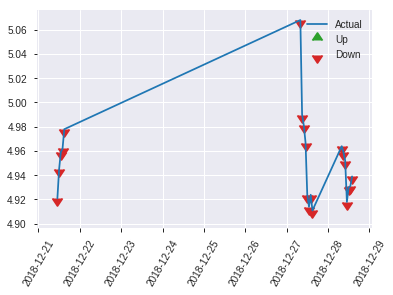


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.28211019409608207
RMSE: 0.5311404655042601
LogLoss: 0.7595958798420537
Null degrees of freedom: 192
Residual degrees of freedom: -846
Null deviance: 267.41981442535183
Residual deviance: 293.20400961903266
AIC: 2371.2040096190326
AUC: 0.5824618736383442
pr_auc: 0.6346571751262792
Gini: 0.16492374727668846
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31962022993843014: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      7    78   0.9176   (78.0/85.0)
1      3    105  0.0278   (3.0/108.0)
Total  10   183  0.4197   (81.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.31962      0.721649  182
max f2                       0.311849     0.865385  191
max f0point5                 0.358309     0.629371  115
max accuracy                 0.358309     0.585492  115
max precision                0.424754     1         0
max recall                   0.311849     1         191
max specificity              0.424754     1         0
max absolute_mcc             0.373723     0.168432  64
max min_per_class_accuracy   0.364135     0.564815  96
max mean_per_class_accuracy  0.370593     0.581917  78

Gains/Lift Table: Avg response rate: 55.96 %, avg score: 36.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.421472           1.78704   1.78704            1                0.423161  1                           0.423161            0.0185185       0.0185185                  78.7037   78.7037
    2        0.0207254                   0.418227           0.893519  1.34028            0.5              0.420615  0.75                        0.421888            0.00925926      0.0277778                  -10.6481  34.0278
    3        0.0310881                   0.415119           0.893519  1.19136            0.5              0.416809  0.666667                    0.420195            0.00925926      0.037037                   -10.6481  19.1358
    4        0.0414508                   0.4132             1.78704   1.34028            1                0.414843  0.75                        0.418857            0.0185185       0.0555556                  78.7037   34.0278
    5        0.0518135                   0.411247           0.893519  1.25093            0.5              0.412318  0.7                         0.417549            0.00925926      0.0648148                  -10.6481  25.0926
    6        0.103627                    0.393134           1.25093   1.25093            0.7              0.402546  0.7                         0.410048            0.0648148       0.12963                    25.0926   25.0926
    7        0.150259                    0.38627            1.38992   1.29406            0.777778         0.389679  0.724138                    0.403726            0.0648148       0.194444                   38.9918   29.4061
    8        0.202073                    0.381965           0.714815  1.14554            0.4              0.383443  0.641026                    0.398525            0.037037        0.231481                   -28.5185  14.5537
    9        0.300518                    0.374885           1.22271   1.17082            0.684211         0.378341  0.655172                    0.391913            0.12037         0.351852                   22.271    17.0817
    10       0.398964                    0.370743           1.12865   1.16041            0.631579         0.372915  0.649351                    0.387226            0.111111        0.462963                   12.8655   16.0414
    11       0.502591                    0.364135           0.98287   1.12381            0.55             0.367502  0.628866                    0.383159            0.101852        0.564815                   -1.71296  12.3807
    12       0.601036                    0.35819            1.0346    1.1092             0.578947         0.360816  0.62069                     0.379499            0.101852        0.666667                   3.46004   10.9195
    13       0.699482                    0.352476           0.564327  1.03251            0.315789         0.354805  0.577778                    0.376024            0.0555556       0.722222                   -43.5673  3.25103
    14       0.797927                    0.344966           1.0346    1.03277            0.578947         0.349207  0.577922                    0.372715            0.101852        0.824074                   3.46004   3.27682
    15       0.896373                    0.323377           0.752437  1.00198            0.421053         0.33464   0.560694                    0.368534            0.0740741       0.898148                   -24.7563  0.19803
    16       1                           0.308928           0.98287   1                  0.55             0.318319  0.559585                    0.36333          

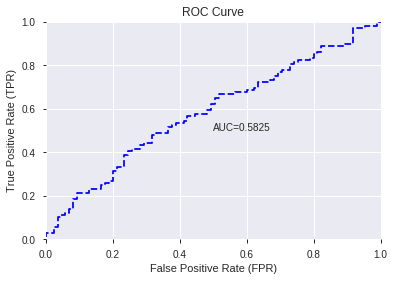

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


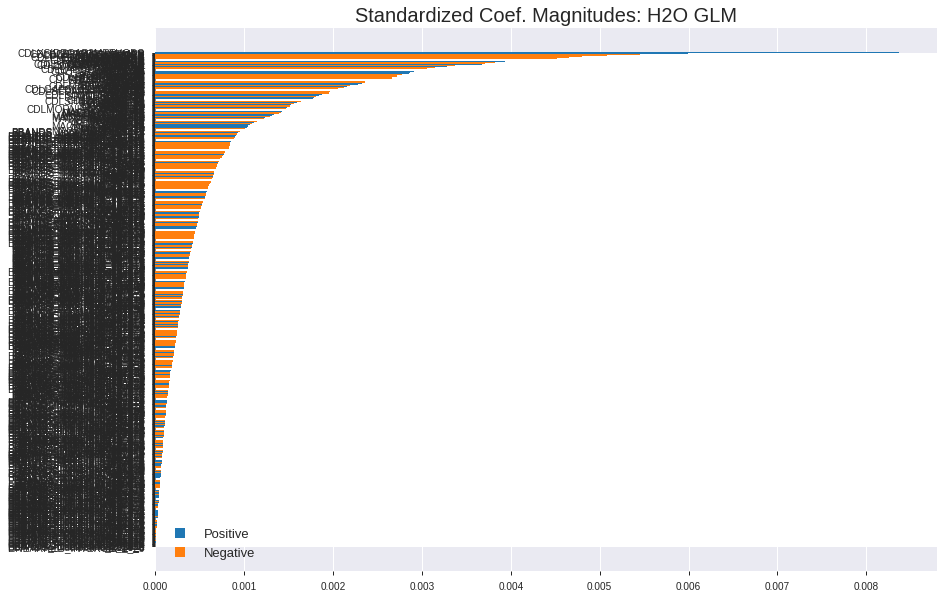

'log_likelihood'
--2019-08-25 15:17:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.84.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.84.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


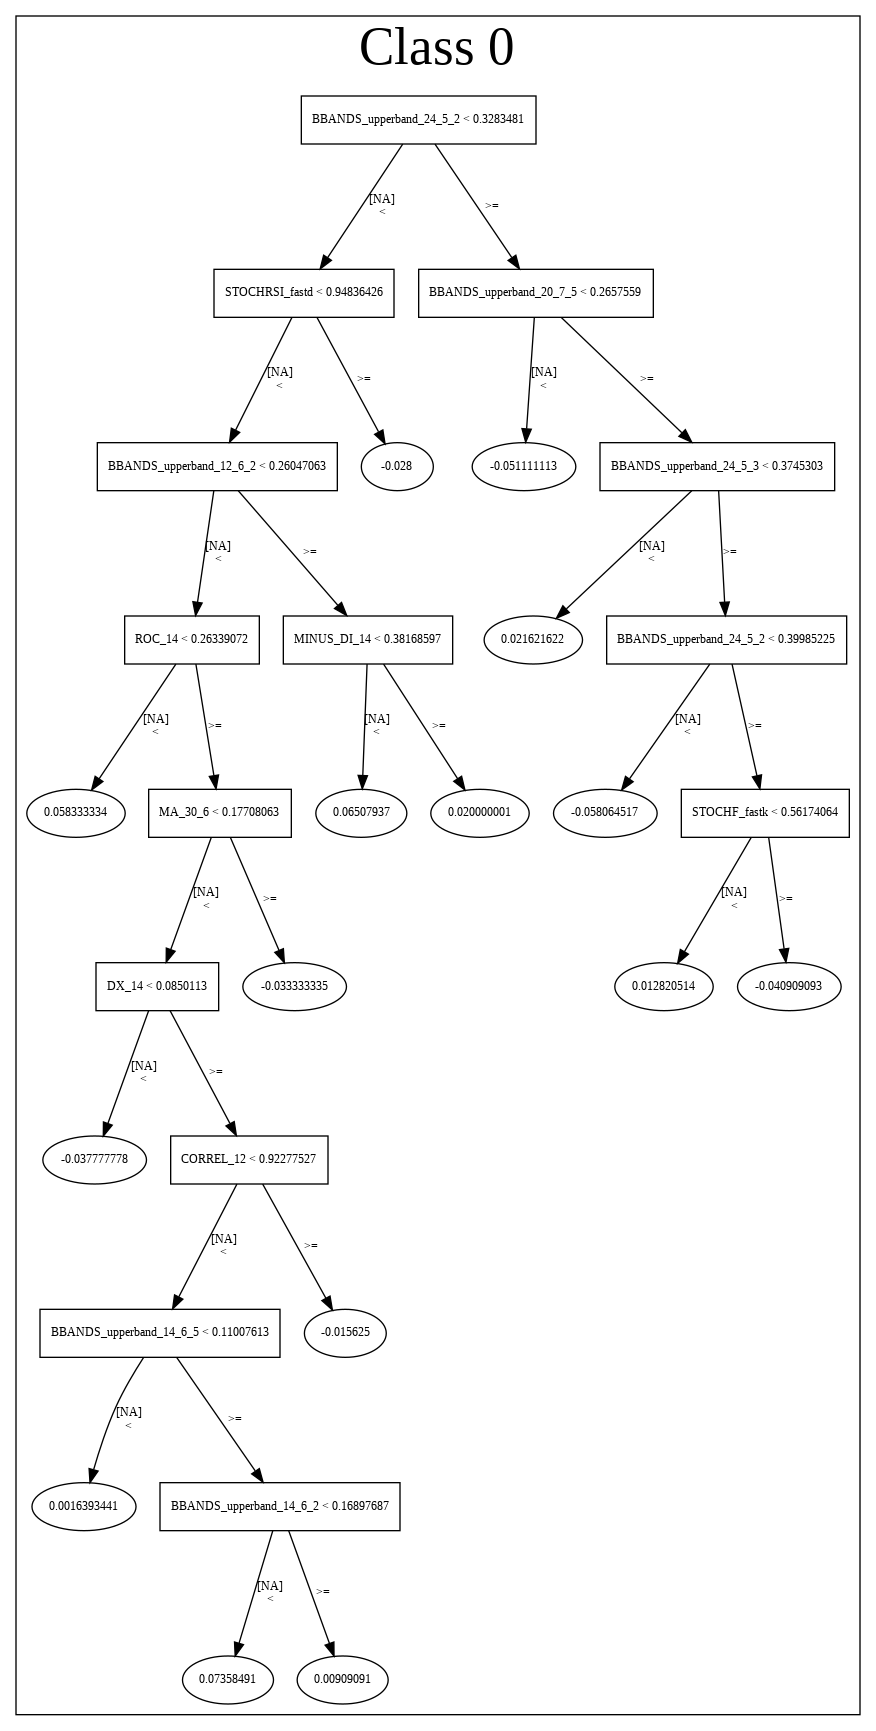

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_151654_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_151654_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_9982',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLXSIDEGAP3METHODS',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'CDLADVANCEBLOCK',
 'OBV',
 'CDLBELTHOLD',
 'CDLONNECK',
 'SAREXT',
 'CDLPIERCING',
 'CDLEVENINGDOJISTAR',
 'CDL3LINESTRIKE',
 'CDLHIKKAKE',
 'CDL3OUTSIDE',
 'CDLINNECK',
 'CDLMORNINGSTAR',
 'HT_TRENDMODE',
 'CDLDOJISTAR',
 'DX_8',
 'CDLHIGHWAVE',
 'MFI_12',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLENGULFING',
 'CDLSTALLEDPATTERN',
 'CDLTASUKIGAP',
 'MFI_8',
 'CDL3WHITESOLDIERS',
 'CORREL_8',
 'CDLEVENINGSTAR',
 'WILLR_14',
 'CDL2CROWS',
 'ADOSC',
 'MFI_14',
 'CDLLADDERBOTTOM',
 'dayofyear',
 'weekofyear',
 'week',
 'CDLHARAMICROSS',
 'BETA_14',
 'TRANGE',
 'NATR_30',
 'aroonup_20',
 'aroondown_20',
 'WILLR_12',
 'STOCH_slowd',
 'month',
 'aroondown_14',
 'aroonup_24',
 'BOP',
 'ATR_30',
 'HT_DCPERIOD',
 'CDLSPINNINGTOP',
 'AROONOSC_24',
 'CDLHAMMER',
 'AD',
 'CDLRICKSHAWMAN',
 'CDLSHORTLINE',
 'NATR_24',
 'quarter',
 'ADX_24',
 'ROCR100_8',
 'ROCR_8',
 'ROCP_8',
 'ROC_8',
 'is_month_start',
 'STOCHF_fastd',
 'STOCH_slowk',
 

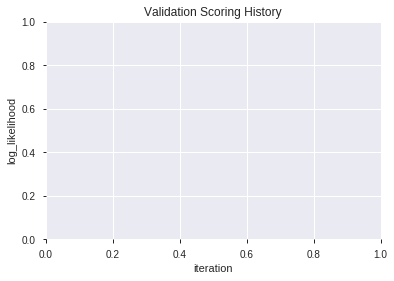

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190825_151735  0.619172  0.737771              0.458824  0.521023  0.271465
1  XGBoost_grid_1_AutoML_20190825_151735_model_2  0.594227  0.713476              0.451688  0.509952  0.260051
2               XGBoost_1_AutoML_20190825_151735  0.584858  0.780111              0.488235  0.538844  0.290353
3  XGBoost_grid_1_AutoML_20190825_151735_model_6  0.569281  0.806567              0.481100  0.549717  0.302189
4               XGBoost_3_AutoML_20190825_151735  0.567102  0.730599              0.488235  0.517393  0.267696
5  XGBoost_grid_1_AutoML_20190825_151735_model_4  0.563834  0.742618              0.494118  0.523478  0.274029
6  XGBoost_grid_1_AutoML_20190825_151735_model_1  0.545643  0.749716              0.500000  0.524934  0.275556
7  XGBoost_grid_1_AutoML_20190825_151735_model_7  0.542484  0.802007              0.500000  0.547412  0.299660
8  XGBoost_grid_1_AutoML_20190825_151735_model_3  0.501416  0.821058              0.494118  0.554495  0.307465
9  XGBoost_grid_1_AutoML_20190825_151735_model_5  0.457190  0.763062              0.475218  0.532554  0.283613

variable  relative_importance  scaled_importance  percentage
0             STOCHRSI_fastd           148.529785           1.000000    0.030161
1                        OBV           140.101013           0.943252    0.028449
2                        BOP           126.425560           0.851180    0.025672
3                      ADX_8            87.304451           0.587791    0.017728
4                      MFI_8            68.931259           0.464090    0.013997
..                       ...                  ...                ...         ...
306                   SMA_30             2.883541           0.019414    0.000586
307                 WILLR_30             2.825700           0.019024    0.000574
308  BBANDS_upperband_30_7_5             2.686815           0.018089    0.000546
309  BBANDS_upperband_14_3_5             1.922774           0.012945    0.000390
310  BBANDS_upperband_12_7_2             0.814415           0.005483    0.000165

[311 rows x 4 columns]

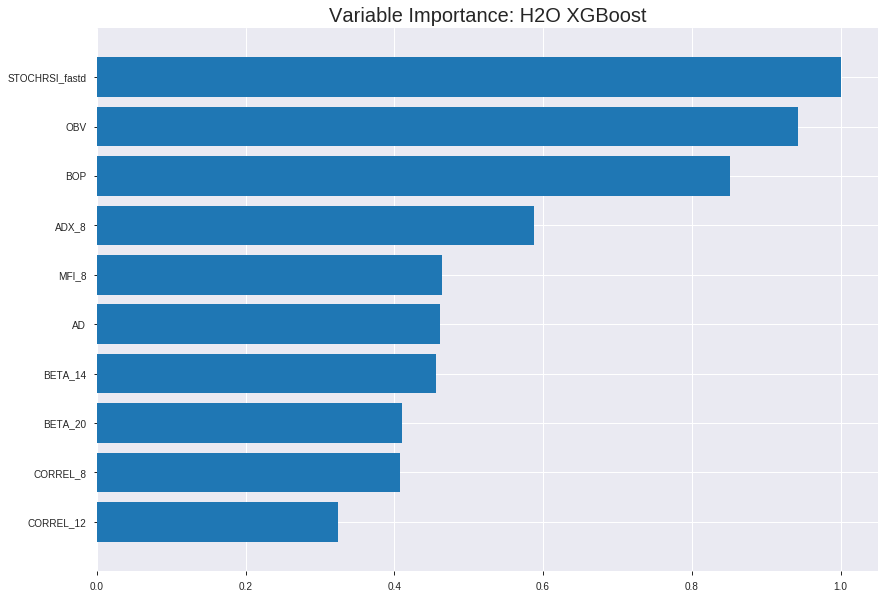

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190825_151735


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16947820859762056
RMSE: 0.41167731124950346
LogLoss: 0.5260980846880687
Mean Per-Class Error: 0.13435226582767568
AUC: 0.9374267262791853
pr_auc: 0.9363252583686728
Gini: 0.8748534525583707
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4899964431921641: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      565  106  0.158    (106.0/671.0)
1      80   595  0.1185   (80.0/675.0)
Total  645  701  0.1382   (186.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489996     0.864826  210
max f2                       0.43775      0.913019  255
max f0point5                 0.51691      0.882726  190
max accuracy                 0.51691      0.865527  190
max precision                0.79762      1         0
max recall                   0.315423     1         353
max specificity              0.79762      1         0
max absolute_mcc             0.51691      0.733571  190
max min_per_class_accuracy   0.500592     0.862222  202
max mean_per_class_accuracy  0.51691      0.865648  190

Gains/Lift Table: Avg response rate: 50.15 %, avg score: 50.33 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.749425           1.99407    1.99407            1                0.767012  1                           0.767012            0.0207407       0.0207407                  99.4074   99.4074
    2        0.0200594                   0.73876            1.99407    1.99407            1                0.745302  1                           0.756559            0.0192593       0.04                       99.4074   99.4074
    3        0.0304606                   0.728717           1.99407    1.99407            1                0.732954  1                           0.748499            0.0207407       0.0607407                  99.4074   99.4074
    4        0.0401189                   0.71998            1.99407    1.99407            1                0.723992  1                           0.742599            0.0192593       0.08                       99.4074   99.4074
    5        0.0505201                   0.710148           1.99407    1.99407            1                0.715548  1                           0.73703             0.0207407       0.100741                   99.4074   99.4074
    6        0.100297                    0.678057           1.99407    1.99407            1                0.69501   1                           0.716176            0.0992593       0.2                        99.4074   99.4074
    7        0.150074                    0.653903           1.96431    1.9842             0.985075         0.666928  0.99505                     0.699841            0.0977778       0.297778                   96.4312   98.4202
    8        0.200594                    0.628236           1.87678    1.95715            0.941176         0.641637  0.981481                    0.685182            0.0948148       0.392593                   87.6776   95.7147
    9        0.300149                    0.591377           1.77086    1.89536            0.88806          0.609326  0.950495                    0.660022            0.176296        0.568889                   77.0857   89.5358
    10       0.400446                    0.545247           1.66911    1.83869            0.837037         0.568904  0.922078                    0.6372              0.167407        0.736296                   66.9114   83.8692
    11       0.5                         0.499649           1.2649     1.72444            0.634328         0.521994  0.864785                    0.614262            0.125926        0.862222                   26.4898   72.4444
    12       0.600297                    0.459039           0.723775   1.55725            0.362963         0.478275  0.780941                    0.591541            0.0725926       0.934815                   -27.6225  55.7253
    13       0.699851                    0.418214           0.446434   1.39924            0.223881         0.43882   0.701699                    0.569817            0.0444444       0.979259                   -55.3566  39.9239
    14       0.800149                    0.375995           0.147709   1.24236            0.0740741        0.398068  0.623027                    0.548288            0.0148148       0.994074                   -85.2291  24.2362
    15       0.899703                    0.331456           0.0446434  1.10983            0.0223881        0.355749  0.556565                    0.526983            0.00444444      0.998519                   -95.5357  10.9831
    16       1                           0.19955            0.0147709  1                  0.00740741       0.290419  0.501486                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26126193025036165
RMSE: 0.5111378779256744
LogLoss: 0.7167630892098117
Mean Per-Class Error: 0.4744459213845862
AUC: 0.49030192876325857
pr_auc: 0.48883809372910175
Gini: -0.01939614247348287
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2890899181365967: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    192  0.9948   (192.0/193.0)
1      0    191  0        (0.0/191.0)
Total  1    383  0.5      (192.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.28909      0.665505   382
max f2                       0.28909      0.832607   382
max f0point5                 0.373771     0.562224   347
max accuracy                 0.380619     0.523438   341
max precision                0.723319     0.6        4
max recall                   0.28909      1          382
max specificity              0.789927     0.994819   0
max absolute_mcc             0.373771     0.0876687  347
max min_per_class_accuracy   0.513003     0.486911   191
max mean_per_class_accuracy  0.373771     0.525554   347

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 51.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.724284           1.00524   1.00524            0.5              0.762362  0.5                         0.762362            0.0104712       0.0104712                  0.52356   0.52356
    2        0.0208333                   0.697246           1.00524   1.00524            0.5              0.712151  0.5                         0.737256            0.0104712       0.0209424                  0.52356   0.52356
    3        0.03125                     0.691387           1.50785   1.17277            0.75             0.6952    0.583333                    0.723237            0.0157068       0.0366492                  50.7853   17.2775
    4        0.0416667                   0.678413           0.502618  1.00524            0.25             0.684861  0.5                         0.713643            0.0052356       0.0418848                  -49.7382  0.52356
    5        0.0520833                   0.66978            1.00524   1.00524            0.5              0.673769  0.5                         0.705669            0.0104712       0.052356                   0.52356   0.52356
    6        0.101562                    0.640372           0.846514  0.92791            0.421053         0.657694  0.461538                    0.682296            0.0418848       0.0942408                  -15.3486  -7.20902
    7        0.151042                    0.621811           1.05814   0.970572           0.526316         0.631078  0.482759                    0.665518            0.052356        0.146597                   5.81427   -2.94277
    8        0.200521                    0.604611           0.846514  0.939961           0.421053         0.614177  0.467532                    0.652849            0.0418848       0.188482                   -15.3486  -6.00394
    9        0.299479                    0.56857            1.05814   0.979012           0.526316         0.58484   0.486957                    0.630377            0.104712        0.293194                   5.81427   -2.09879
    10       0.401042                    0.539982           0.97946   0.979126           0.487179         0.553956  0.487013                    0.611024            0.0994764       0.39267                    -2.05397  -2.08744
    11       0.5                         0.512891           0.952328  0.973822           0.473684         0.524676  0.484375                    0.593934            0.0942408       0.486911                   -4.76715  -2.6178
    12       0.598958                    0.485307           0.899421  0.96153            0.447368         0.500895  0.478261                    0.578562            0.0890052       0.575916                   -10.0579  -3.84703
    13       0.700521                    0.456572           1.18566   0.994025           0.589744         0.471609  0.494424                    0.563056            0.120419        0.696335                   18.5663   -0.59752
    14       0.799479                    0.416164           1.05814   1.00196            0.526316         0.437347  0.498371                    0.547496            0.104712        0.801047                   5.81427   0.196122
    15       0.898438                    0.375433           1.21686   1.02563            0.605263         0.397005  0.510145                    0.53092             0.120419        0.921466                   21.6864   2.56317
    16       1                           0.272541           0.773258  1                  0.384615         0.342984  0.497396                    0.511833 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:17:40  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.498514                         0.5                0.693147              0.5               0                    1                  0.502604
    2019-08-25 15:17:40  0.513 sec   5                  0.48704          0.667498            0.776381        0.775733           1.90738          0.284547                         0.500676           0.694502              0.496704          0.484672             0.502618           0.494792
    2019-08-25 15:17:40  0.896 sec   10                 0.477175         0.648284            0.81876         0.819827           1.99407          0.260773                         0.50224            0.697672              0.491156          0.479731             0                  0.484375
    2019-08-25 15:17:41  1.287 sec   15                 0.466961         0.62862             0.848081        0.850737           1.99407          0.238484                         0.504166           0.701621              0.485066          0.489826             1.50785            0.502604
    2019-08-25 15:17:41  1.676 sec   20                 0.457988         0.611551            0.868899        0.870471           1.99407          0.216196                         0.505596           0.704611              0.48565           0.495606             2.01047            0.502604
    2019-08-25 15:17:42  2.051 sec   25                 0.449855         0.596177            0.880603        0.881692           1.99407          0.213224                         0.506859           0.70724               0.485934          0.49732              1.50785            0.502604
    2019-08-25 15:17:42  2.412 sec   30                 0.441729         0.580904            0.894           0.89619            1.99407          0.190193                         0.506994           0.707515              0.48702           0.491228             1.00524            0.497396
    2019-08-25 15:17:42  2.799 sec   35                 0.43367          0.565999            0.906245        0.907294           1.99407          0.175334                         0.507518           0.708759              0.496161          0.492669             1.00524            0.492188
    2019-08-25 15:17:43  3.189 sec   40                 0.425671         0.551308            0.917315        0.917898           1.99407          0.167905                         0.508885           0.711722              0.491902          0.489276             1.00524            0.479167
    2019-08-25 15:17:43  3.590 sec   45                 0.418126         0.537683            0.928249        0.927268           1.99407          0.142645                         0.50913            0.712383              0.496758          0.492331             1.00524            0.484375
    2019-08-25 15:17:43  3.952 sec   50                 0.411677         0.526098            0.937427        0.936325           1.99407          0.138187                         0.511138           0.716763              0.490302          0.488838             1.00524            0.5

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
STOCHRSI_fastd           148.52978515625        1.0                   0.030160769202576435
OBV                      140.10101318359375     0.9432519749234851    0.02844920511554165
BOP                      126.4255599975586      0.8511798483015494    0.025672238954507053
ADX_8                    87.30445098876953      0.5877908656295922    0.017728224637636746
MFI_8                    68.93125915527344      0.464090479110027     0.013997325829550645
---                      ---                    ---                   ---
SMA_30                   2.8835408687591553     0.0194138897173098    0.0005855378470880527
WILLR_30                 2.825699806213379      0.01902446572073612   0.0005737925198054492
BBANDS_upperband_30_7_5  2.6868152618408203     0.01808940381226803   0.0005455903333940224
BBANDS_upperband_14_3_5  1.922774314880371      0.012945378685208868  0.000390442578764537
BBANDS_upperband_12_7_2  0.8144149780273438     0.005483176166791041  0.00016537681086365236


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6113989637305699)

('F1', 0.7346938775510204)

('auc', 0.6191721132897603)

('logloss', 0.7377712035595405)

('mean_per_class_error', 0.40168845315904134)

('rmse', 0.5210234134219789)

('mse', 0.27146539733389036)

xgboost prediction progress: |████████████████████████████████████████████| 100%


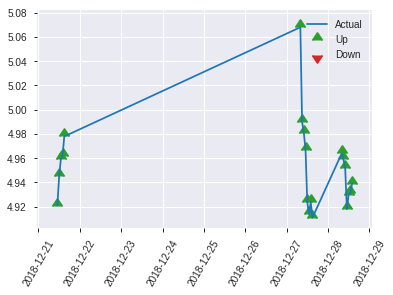


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.27146539733389036
RMSE: 0.5210234134219789
LogLoss: 0.7377712035595405
Mean Per-Class Error: 0.40168845315904134
AUC: 0.6191721132897603
pr_auc: 0.6634358230732175
Gini: 0.2383442265795206
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2749679982662201: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      7    78   0.9176   (78.0/85.0)
1      0    108  0        (0.0/108.0)
Total  7    186  0.4041   (78.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.274968     0.734694  185
max f2                       0.274968     0.873786  185
max f0point5                 0.346236     0.648734  130
max accuracy                 0.346236     0.611399  130
max precision                0.54111      1         0
max recall                   0.274968     1         185
max specificity              0.54111      1         0
max absolute_mcc             0.274968     0.218673  185
max min_per_class_accuracy   0.369452     0.588235  98
max mean_per_class_accuracy  0.392106     0.598312  77

Gains/Lift Table: Avg response rate: 55.96 %, avg score: 37.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.514604           1.78704   1.78704            1                0.534558  1                           0.534558            0.0185185       0.0185185                  78.7037   78.7037
    2        0.0207254                   0.511659           1.78704   1.78704            1                0.513268  1                           0.523913            0.0185185       0.037037                   78.7037   78.7037
    3        0.0310881                   0.499738           0.893519  1.4892             0.5              0.507061  0.833333                    0.518295            0.00925926      0.0462963                  -10.6481  48.9198
    4        0.0414508                   0.487326           0.893519  1.34028            0.5              0.49707   0.75                        0.512989            0.00925926      0.0555556                  -10.6481  34.0278
    5        0.0518135                   0.476587           0.893519  1.25093            0.5              0.48287   0.7                         0.506965            0.00925926      0.0648148                  -10.6481  25.0926
    6        0.103627                    0.448081           1.42963   1.34028            0.8              0.45942   0.75                        0.483193            0.0740741       0.138889                   42.963    34.0278
    7        0.150259                    0.436916           1.38992   1.35568            0.777778         0.441087  0.758621                    0.470125            0.0648148       0.203704                   38.9918   35.5683
    8        0.202073                    0.423983           1.07222   1.283              0.6              0.430732  0.717949                    0.460025            0.0555556       0.259259                   7.22222   28.3001
    9        0.300518                    0.409332           1.0346    1.20163            0.578947         0.416301  0.672414                    0.445701            0.101852        0.361111                   3.46004   20.1628
    10       0.398964                    0.392141           1.22271   1.20683            0.684211         0.401127  0.675325                    0.434702            0.12037         0.481481                   22.271    20.683
    11       0.502591                    0.371049           0.893519  1.14223            0.5              0.381681  0.639175                    0.42377             0.0925926       0.574074                   -10.6481  14.223
    12       0.601036                    0.358974           1.0346    1.1246             0.578947         0.364221  0.62931                     0.414016            0.101852        0.675926                   3.46004   12.4601
    13       0.699482                    0.342725           0.846491  1.08546            0.473684         0.349922  0.607407                    0.404996            0.0833333       0.759259                   -15.3509  8.54595
    14       0.797927                    0.324323           0.846491  1.05598            0.473684         0.333777  0.590909                    0.396209            0.0833333       0.842593                   -15.3509  5.59764
    15       0.896373                    0.296976           0.846491  1.03297            0.473684         0.310524  0.578035                    0.386798            0.0833333       0.925926                   -15.3509  3.29694
    16       1                           0.258035           0.714815  1                  0.4              0.280731  0.559585                    0.375807           

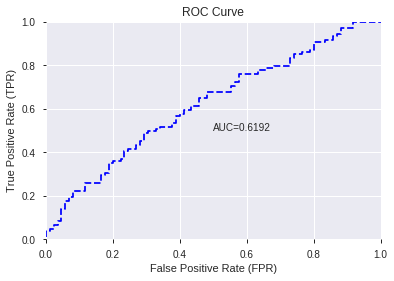

This function is available for GLM models only


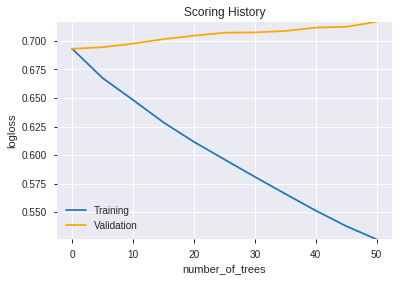

--2019-08-25 15:18:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.93.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.93.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


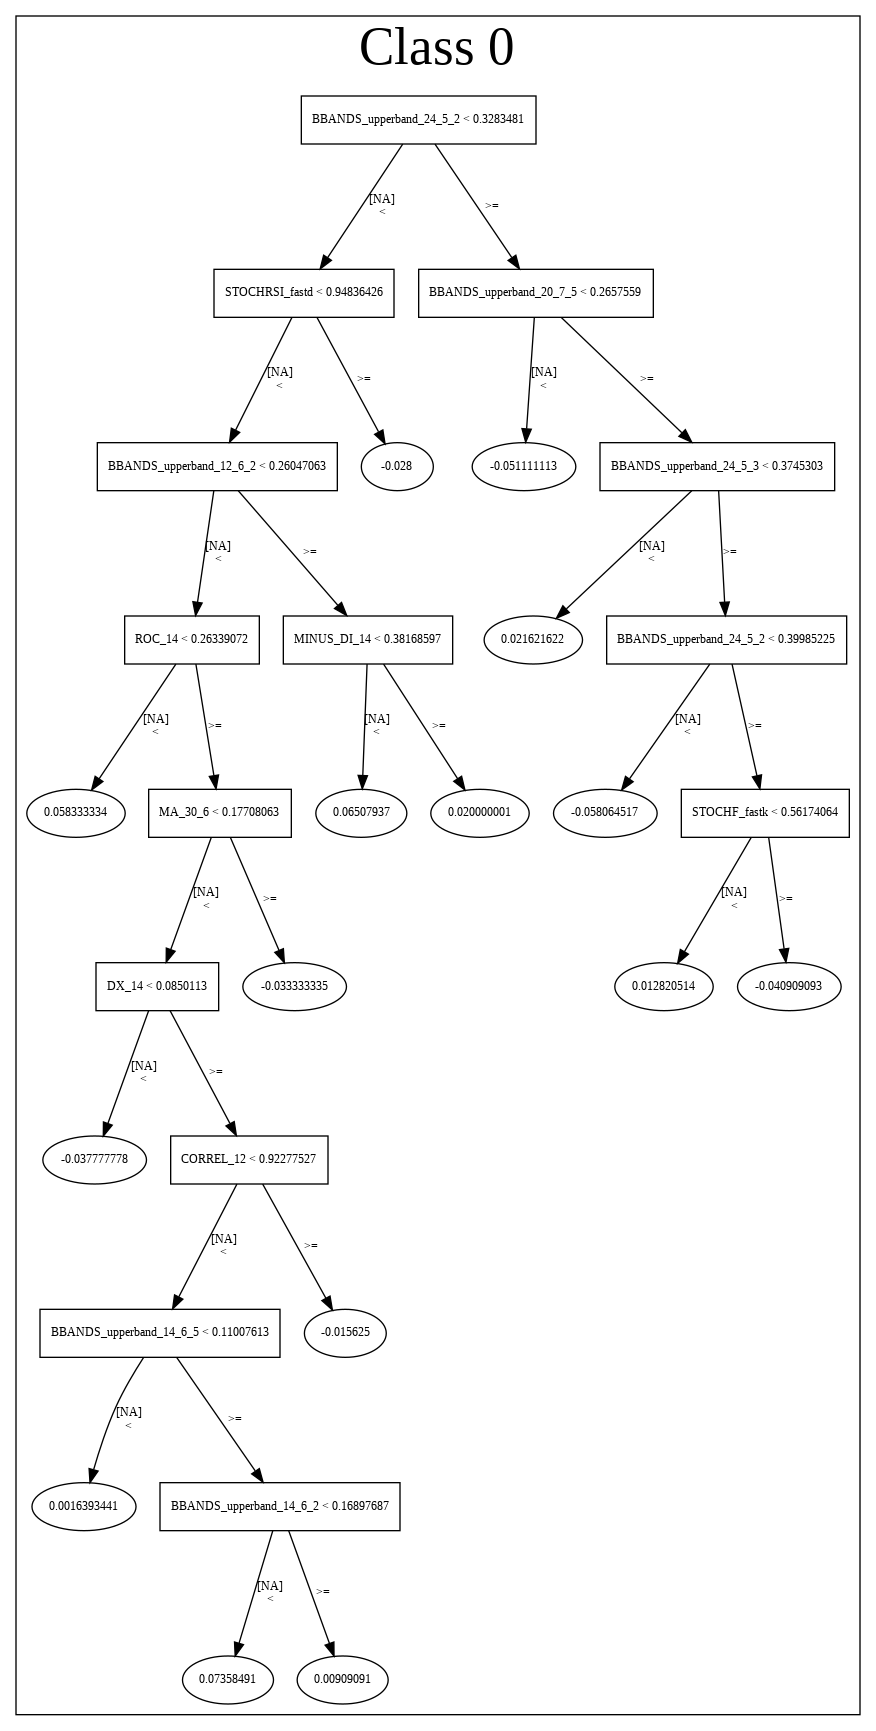

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190825_151735',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190825_151735',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_9982',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_9982',
   'type

['STOCHRSI_fastd',
 'OBV',
 'BOP',
 'ADX_8',
 'MFI_8',
 'AD',
 'BETA_14',
 'BETA_20',
 'CORREL_8',
 'CORREL_12',
 'Volume',
 'NATR_30',
 'LINEARREG_ANGLE_8',
 'CCI_8',
 'ULTOSC',
 'MFI_12',
 'CORREL_20',
 'WILLR_14',
 'MACDFIX_signal_24',
 'STOCHRSI_fastk',
 'STDDEV_12',
 'ADXR_14',
 'BBANDS_lowerband_30_6_2',
 'ADX_24',
 'ADXR_8',
 'BBANDS_lowerband_20_0_5',
 'BBANDS_upperband_24_5_2',
 'STOCHF_fastk',
 'HT_PHASOR_quadrature',
 'NATR_8',
 'STDDEV_8',
 'MFI_30',
 'DX_24',
 'BBANDS_lowerband_20_6_4',
 'MINUS_DI_14',
 'DX_8',
 'DX_12',
 'ATR_12',
 'BBANDS_lowerband_30_5_4',
 'ADOSC',
 'BBANDS_lowerband_24_7_5',
 'SAREXT',
 'STDDEV_24',
 'PLUS_DI_12',
 'BBANDS_lowerband_20_1_2',
 'BBANDS_lowerband_12_0_4',
 'MINUS_DI_8',
 'ADXR_12',
 'DX_20',
 'STOCH_slowk',
 'STDDEV_20',
 'BETA_12',
 'PLUS_DI_8',
 'NATR_12',
 'BBANDS_lowerband_24_2_4',
 'CCI_20',
 'MACDFIX_hist_14',
 'ADX_20',
 'MFI_24',
 'BETA_8',
 'BBANDS_upperband_20_6_4',
 'MACDEXT_hist',
 'HT_PHASOR_inphase',
 'SUB',
 'BBANDS_upperb

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

497

['BBANDS_upperband_12_6_2',
 'BBANDS_middleband_12_6_2',
 'BBANDS_lowerband_12_6_2',
 'BBANDS_upperband_12_6_3',
 'BBANDS_middleband_12_6_3',
 'BBANDS_lowerband_12_6_3',
 'BBANDS_upperband_12_6_4',
 'BBANDS_middleband_12_6_4',
 'BBANDS_lowerband_12_6_4',
 'BBANDS_upperband_12_6_5',
 'BBANDS_middleband_12_6_5',
 'BBANDS_lowerband_12_6_5',
 'MA_12_7',
 'MAVP_12_7',
 'BBANDS_upperband_12_7_2',
 'BBANDS_middleband_12_7_2',
 'BBANDS_lowerband_12_7_2',
 'BBANDS_upperband_12_7_3',
 'BBANDS_middleband_12_7_3',
 'BBANDS_lowerband_12_7_3',
 'BBANDS_upperband_12_7_4',
 'BBANDS_middleband_12_7_4',
 'BBANDS_lowerband_12_7_4',
 'BBANDS_upperband_12_7_5',
 'BBANDS_middleband_12_7_5',
 'BBANDS_lowerband_12_7_5',
 'DEMA_14',
 'EMA_14',
 'KAMA_14',
 'MIDPOINT_14',
 'MIDPRICE_14',
 'SAR_0.14',
 'SMA_14',
 'TEMA_14',
 'TRIMA_14',
 'WMA_14',
 'MA_14_0',
 'MAVP_14_0',
 'BBANDS_upperband_14_0_2',
 'BBANDS_middleband_14_0_2',
 'BBANDS_lowerband_14_0_2',
 'BBANDS_upperband_14_0_3',
 'BBANDS_middleband_14_0_3',

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_151909_model_7  0.585948  1.133550              0.439924  0.642602  0.412937
1  DeepLearning_grid_1_AutoML_20190825_151909_model_4  0.578649  1.941859              0.469336  0.688212  0.473636
2  DeepLearning_grid_1_AutoML_20190825_151909_model_2  0.573420  0.723055              0.476471  0.510155  0.260258
3  DeepLearning_grid_1_AutoML_20190825_151909_model_3  0.572876  1.358584              0.488235  0.641745  0.411837
4  DeepLearning_grid_1_AutoML_20190825_151909_model_1  0.558606  7.800657              0.468083  0.740300  0.548044
5  DeepLearning_grid_1_AutoML_20190825_151909_model_6  0.545425  0.712864              0.492865  0.509663  0.259756
6  DeepLearning_grid_1_AutoML_20190825_151909_model_5  0.516122  0.693104              0.500000  0.499978  0.249978
7  DeepLearning_grid_1_AutoML_20190825_151909_model_8  0.500000  0.693486              0.500000  0.500169  0.250169
8  DeepLearning_grid_1_AutoML_20190825_151909_model_9  0.493355  0.697073              0.494118  0.501959  0.251962
9               DeepLearning_1_AutoML_20190825_151909  0.485675  0.784390              0.500000  0.541808  0.293555

variable  relative_importance  scaled_importance  percentage
0     BBANDS_upperband_14_4_2             1.000000           1.000000    0.002201
1                       MFI_8             0.998421           0.998421    0.002197
2                STOCHF_fastd             0.995985           0.995985    0.002192
3                 CDLHIGHWAVE             0.993846           0.993846    0.002187
4    BBANDS_middleband_20_5_3             0.987666           0.987666    0.002174
..                        ...                  ...                ...         ...
489                  WILLR_12             0.857753           0.857753    0.001888
490   BBANDS_lowerband_12_6_2             0.855516           0.855516    0.001883
491                   ROCP_14             0.853252           0.853252    0.001878
492                   NATR_30             0.851022           0.851022    0.001873
493   BBANDS_upperband_14_4_5             0.847292           0.847292    0.001865

[494 rows x 4 columns]

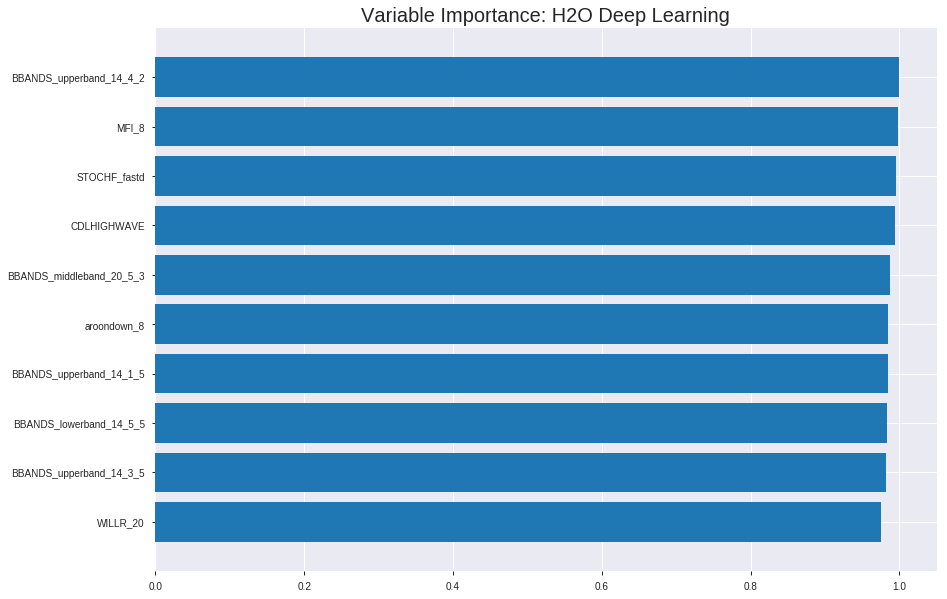

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_151909_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2614984914391154
RMSE: 0.5113692320027823
LogLoss: 0.71654522887269
Mean Per-Class Error: 0.3594149141690125
AUC: 0.7035833747309157
pr_auc: 0.6987341292786342
Gini: 0.4071667494618314
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20727452980530936: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      166  505   0.7526   (505.0/671.0)
1      32   643   0.0474   (32.0/675.0)
Total  198  1148  0.399    (537.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.207275     0.705431  307
max f2                       0.157033     0.844123  339
max f0point5                 0.299074     0.64316   203
max accuracy                 0.299074     0.640416  203
max precision                0.996812     1         0
max recall                   0.0545148    1         382
max specificity              0.996812     1         0
max absolute_mcc             0.249369     0.301479  263
max min_per_class_accuracy   0.289142     0.634074  216
max mean_per_class_accuracy  0.299074     0.640585  203

Gains/Lift Table: Avg response rate: 50.15 %, avg score: 30.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.904624           1.99407   1.99407            1                0.952166  1                           0.952166            0.0207407       0.0207407                  99.4074   99.4074
    2        0.0200594                   0.779545           1.68729   1.84636            0.846154         0.843316  0.925926                    0.899757            0.0162963       0.037037                   68.7293   84.6365
    3        0.0304606                   0.710032           1.99407   1.8968             1                0.759236  0.95122                     0.851774            0.0207407       0.0577778                  99.4074   89.6802
    4        0.0401189                   0.618428           1.68729   1.84636            0.846154         0.677382  0.925926                    0.809791            0.0162963       0.0740741                  68.7293   84.6365
    5        0.0505201                   0.570786           1.42434   1.75948            0.714286         0.591071  0.882353                    0.76476             0.0148148       0.0888889                  42.4339   75.9477
    6        0.100297                    0.444688           1.42859   1.59526            0.716418         0.497328  0.8                         0.632034            0.0711111       0.16                       42.859    59.5259
    7        0.150074                    0.390789           1.36907   1.52023            0.686567         0.416472  0.762376                    0.560536            0.0681481       0.228148                   36.9066   52.0235
    8        0.200594                    0.35327            1.34893   1.47709            0.676471         0.369863  0.740741                    0.512514            0.0681481       0.296296                   34.8932   47.7092
    9        0.300149                    0.31129            1.2649    1.40671            0.634328         0.325938  0.705446                    0.45063             0.125926        0.422222                   26.4898   40.6711
    10       0.422734                    0.30162            1.11185   1.32121            0.557576         0.303596  0.662566                    0.407993            0.136296        0.558519                   11.1847   32.1205
    11       0.5                         0.28811            0.977863  1.26815            0.490385         0.295323  0.635958                    0.390582            0.0755556       0.634074                   -2.21368  26.8148
    12       0.600297                    0.269195           0.989652  1.22162            0.496296         0.278837  0.612624                    0.371912            0.0992593       0.733333                   -1.03484  22.1617
    13       0.699851                    0.250182           1.04168   1.19602            0.522388         0.259274  0.599788                    0.355889            0.103704        0.837037                   4.16805   19.6021
    14       0.800149                    0.22103            0.694233  1.13312            0.348148         0.236709  0.568245                    0.34095             0.0696296       0.906667                   -30.5767  13.3123
    15       0.899703                    0.179556           0.699414  1.08513            0.350746         0.205474  0.544178                    0.325959            0.0696296       0.976296                   -30.0586  8.5132
    16       1                           0.000686941        0.236335  1                  0.118519         0.100629  0.501486                    0.303359          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3022334606931854
RMSE: 0.549757638139922
LogLoss: 0.8572606238090458
Mean Per-Class Error: 0.4467894636898788
AUC: 0.5302064400618507
pr_auc: 0.5114576405695823
Gini: 0.060412880123701385
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0016854424583648405: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    193  1        (193.0/193.0)
1      0    191  0        (0.0/191.0)
Total  0    384  0.5026   (193.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00168544   0.664348  381
max f2                       0.00168544   0.831882  381
max f0point5                 0.236843     0.569326  272
max accuracy                 0.236843     0.552083  272
max precision                0.45139      0.578947  56
max recall                   0.00168544   1         381
max specificity              0.927944     0.994819  0
max absolute_mcc             0.236843     0.118017  272
max min_per_class_accuracy   0.295164     0.507772  189
max mean_per_class_accuracy  0.236843     0.553211  272

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 31.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.845323           1.00524   1.00524            0.5              0.901066  0.5                         0.901066            0.0104712       0.0104712                  0.52356   0.52356
    2        0.0208333                   0.767819           0.502618  0.753927           0.25             0.810683  0.375                       0.855874            0.0052356       0.0157068                  -49.7382  -24.6073
    3        0.03125                     0.743909           0.502618  0.670157           0.25             0.755332  0.333333                    0.82236             0.0052356       0.0209424                  -49.7382  -32.9843
    4        0.0416667                   0.725663           1.00524   0.753927           0.5              0.737892  0.375                       0.801243            0.0104712       0.0314136                  0.52356   -24.6073
    5        0.0520833                   0.666495           2.01047   1.00524            1                0.699176  0.5                         0.78083             0.0209424       0.052356                   101.047   0.52356
    6        0.101562                    0.522739           1.16396   1.08256            0.578947         0.590415  0.538462                    0.688063            0.0575916       0.109948                   16.3957   8.25614
    7        0.151042                    0.445871           1.26977   1.14389            0.631579         0.476363  0.568966                    0.618713            0.0628272       0.172775                   26.9771   14.3889
    8        0.200521                    0.394062           1.05814   1.12273            0.526316         0.417535  0.558442                    0.569072            0.052356        0.225131                   5.81427   12.2731
    9        0.299479                    0.335897           0.846514  1.03146            0.421053         0.364719  0.513043                    0.501546            0.0837696       0.308901                   -15.3486  3.14591
    10       0.401042                    0.305887           1.03101   1.03135            0.512821         0.315182  0.512987                    0.45435             0.104712        0.413613                   3.10109   3.13456
    11       0.5                         0.295087           0.952328  1.01571            0.473684         0.300861  0.505208                    0.423972            0.0942408       0.507853                   -4.76715  1.57068
    12       0.598958                    0.27756            1.21686   1.04894            0.605263         0.287416  0.521739                    0.401411            0.120419        0.628272                   21.6864   4.89415
    13       0.700521                    0.244941           1.13411   1.06129            0.564103         0.26361   0.527881                    0.381432            0.115183        0.743455                   13.4112   6.12896
    14       0.799479                    0.183354           0.899421  1.04125            0.447368         0.212503  0.517915                    0.360522            0.0890052       0.832461                   -10.0579  4.12538
    15       0.898438                    0.160099           0.634886  0.996494           0.315789         0.1677    0.495652                    0.339284            0.0628272       0.895288                   -36.5114  -0.350558
    16       1                           0.00168544         1.03101   1                  0.512821         0.108893  0.497396                    0.315885    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:25:48  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 15:25:52  5.079 sec         216 obs/sec       0.619614  1             834        0.621943         1.56657             -0.547265      0.561095        0.528214           1.42434          0.483655                         0.630508           1.8513                -0.590206        0.497925          0.499277             1.50785            0.5
    2019-08-25 15:26:03  16.150 sec        304 obs/sec       3.12184   5             4202       0.598463         1.01432             -0.432646      0.602339        0.623907           1.99407          0.479198                         0.609394           1.09736               -0.485487        0.494534          0.499729             1.50785            0.497396
    2019-08-25 15:26:16  29.074 sec        358 obs/sec       6.83507   11            9200       0.511369         0.716545            -0.0460032     0.703583        0.698734           1.99407          0.39896                          0.549758           0.857261              -0.208967        0.530206          0.511458             1.00524            0.502604
    2019-08-25 15:26:29  41.573 sec        384 obs/sec       10.5825   17            14244      0.455247         0.591619            0.170994       0.729279        0.729888           1.99407          0.381129                         0.540029           0.89292               -0.166559        0.512167          0.523212             0.502618           0.5
    2019-08-25 15:26:42  54.452 sec        396 obs/sec       14.364    23            19334      0.439164         0.552792            0.228533       0.815071        0.81402            1.99407          0.307578                         0.5654             1.03116               -0.278744        0.523085          0.516068             1.50785            0.502604
    2019-08-25 15:26:54  1 min  7.165 sec  403 obs/sec       18.136    29            24411      0.438712         0.551649            0.230121       0.801968        0.791103           1.99407          0.301634                         0.587265           1.24575               -0.379556        0.489217          0.493588             1.00524            0.5
    2019-08-25 15:27:07  1 min 19.452 sec  410 obs/sec       21.8588   35            29422      0.389705         0.450318            0.392514       0.86101         0.827822           1.99407          0.251114                         0.608717           1.44076               -0.482187        0.495809          0.513298             2.01047            0.5
    2019-08-25 15:27:08  1 min 20.610 sec  410 obs/sec       21.8588   35            29422      0.511369         0.716545            -0.0460032     0.703583        0.698734           1.99407          0.39896                          0.549758           0.857261              -0.208967        0.530206          0.511458             1.00524            0.502604

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BBANDS_upperband_14_4_2   1.0                    1.0                  0.0022008282721648984
MFI_8                     0.9984213709831238     0.9984213709831238   0.0021973539807932973
STOCHF_fastd              0.9959854483604431     0.9959854483604431   0.0021919929334164954
CDLHIGHWAVE               0.9938459992408752     0.9938459992408752   0.002187284373307292
BBANDS_middleband_20_5_3  0.9876655340194702     0.9876655340194702   0.002173682230712892
---                       ---                    ---                  ---
WILLR_12                  0.8577525615692139     0.8577525615692139   0.0018877660880233884
BBANDS_lowerband_12_6_2   0.8555160760879517     0.8555160760879517   0.0018828439675459402
ROCP_14                   0.8532520532608032     0.8532520532608032   0.0018778612420991252
NATR_30                   0.8510217666625977     0.8510217666625977   0.001872952764298764
BBANDS_upperband_14_4_5   0.8472923040390015     0.8472923040390015   0.0018647448575167711


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6113989637305699)

('F1', 0.7404844290657439)

('auc', 0.5859477124183007)

('logloss', 1.1335499234044848)

('mean_per_class_error', 0.4073529411764706)

('rmse', 0.6426017919625506)

('mse', 0.4129370630334812)

deeplearning prediction progress: |███████████████████████████████████████| 100%


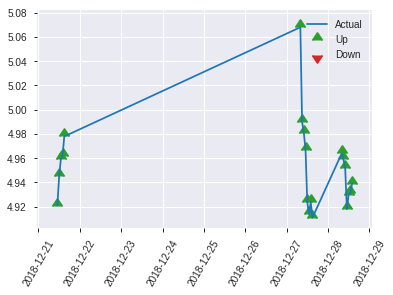


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4129370630334812
RMSE: 0.6426017919625506
LogLoss: 1.1335499234044848
Mean Per-Class Error: 0.4073529411764706
AUC: 0.5859477124183007
pr_auc: 0.608862705986474
Gini: 0.17189542483660136
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11652380540940423: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      11   74   0.8706   (74.0/85.0)
1      1    107  0.0093   (1.0/108.0)
Total  12   181  0.3886   (75.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.116524     0.740484  180
max f2                       0.116524     0.872757  180
max f0point5                 0.133235     0.649038  128
max accuracy                 0.133235     0.611399  128
max precision                0.197876     0.764706  16
max recall                   0.109728     1         191
max specificity              0.209923     0.988235  0
max absolute_mcc             0.116524     0.247016  180
max min_per_class_accuracy   0.14328      0.546296  95
max mean_per_class_accuracy  0.133235     0.592647  128

Gains/Lift Table: Avg response rate: 55.96 %, avg score: 14.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103627                   0.208426           0.893519  0.893519           0.5              0.209178  0.5                         0.209178            0.00925926      0.00925926                 -10.6481   -10.6481
    2        0.0207254                   0.20604            0.893519  0.893519           0.5              0.207582  0.5                         0.20838             0.00925926      0.0185185                  -10.6481   -10.6481
    3        0.0310881                   0.205391           0.893519  0.893519           0.5              0.205878  0.5                         0.207546            0.00925926      0.0277778                  -10.6481   -10.6481
    4        0.0414508                   0.203486           0.893519  0.893519           0.5              0.204407  0.5                         0.206761            0.00925926      0.037037                   -10.6481   -10.6481
    5        0.0518135                   0.202926           1.78704   1.07222            1                0.203425  0.6                         0.206094            0.0185185       0.0555556                  78.7037    7.22222
    6        0.103627                    0.194171           1.60833   1.34028            0.9              0.198691  0.75                        0.202393            0.0833333       0.138889                   60.8333    34.0278
    7        0.150259                    0.185314           0.992798  1.23244            0.555556         0.189019  0.689655                    0.198242            0.0462963       0.185185                   -0.720165  23.2439
    8        0.202073                    0.172302           0.714815  1.09972            0.4              0.178319  0.615385                    0.193134            0.037037        0.222222                   -28.5185   9.97151
    9        0.300518                    0.151596           0.940546  1.04757            0.526316         0.161373  0.586207                    0.182729            0.0925926       0.314815                   -5.94542   4.75734
    10       0.398964                    0.145463           1.0346    1.04437            0.578947         0.147362  0.584416                    0.174002            0.101852        0.416667                   3.46004    4.43723
    11       0.502591                    0.143171           1.25093   1.08696            0.7              0.144372  0.608247                    0.167893            0.12963         0.546296                   25.0926    8.69607
    12       0.601036                    0.137499           1.12865   1.09379            0.631579         0.140251  0.612069                    0.163366            0.111111        0.657407                   12.8655    9.37899
    13       0.699482                    0.131056           1.22271   1.11193            0.684211         0.134463  0.622222                    0.159298            0.12037         0.777778                   22.271     11.1934
    14       0.797927                    0.126728           0.658382  1.05598            0.368421         0.128812  0.590909                    0.155537            0.0648148       0.842593                   -34.1618   5.59764
    15       0.896373                    0.119618           1.0346    1.05363            0.578947         0.124274  0.589595                    0.152103            0.101852        0.944444                   3.46004    5.36288
    16       1                           0.109491           0.536111  1                  0.3              0.114586  0.559585                

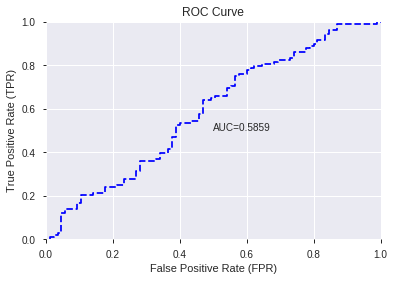

This function is available for GLM models only


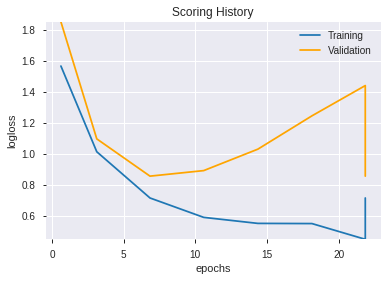

--2019-08-25 15:29:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.4
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.4|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


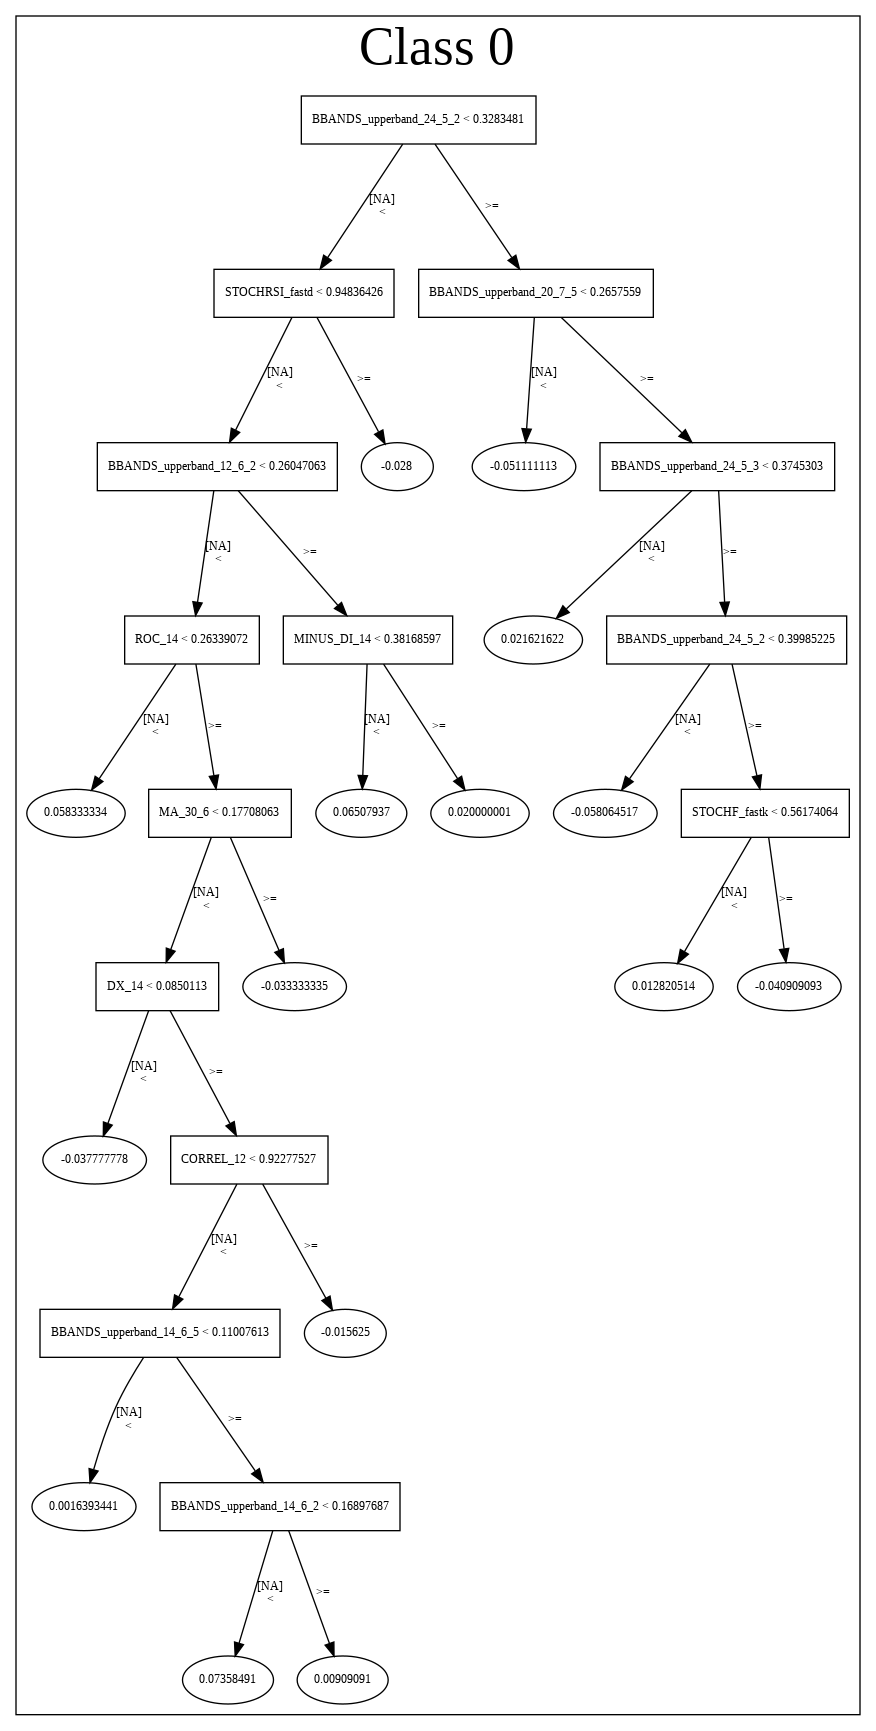

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_151909_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_151909_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_9982',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BBANDS_upperband_14_4_2',
 'MFI_8',
 'STOCHF_fastd',
 'CDLHIGHWAVE',
 'BBANDS_middleband_20_5_3',
 'aroondown_8',
 'BBANDS_upperband_14_1_5',
 'BBANDS_lowerband_14_5_5',
 'BBANDS_upperband_14_3_5',
 'WILLR_20',
 'HT_TRENDMODE',
 'CDLMORNINGSTAR',
 'ROCR100_20',
 'AROONOSC_14',
 'RSI_12',
 'BBANDS_middleband_14_6_2',
 'aroondown_14',
 'MAVP_20_0',
 'MINUS_DI_24',
 'SAR_0.14',
 'MOM_30',
 'PLUS_DM_14',
 'CDLHANGINGMAN',
 'BETA_12',
 'BBANDS_lowerband_14_1_5',
 'ROCP_12',
 'CDLINVERTEDHAMMER',
 'CDLLADDERBOTTOM',
 'BBANDS_middleband_12_7_5',
 'ADX_14',
 'MA_12_7',
 'BBANDS_upperband_24_3_4',
 'BBANDS_lowerband_20_7_4',
 'MOM_20',
 'CDLTHRUSTING',
 'CDLLONGLEGGEDDOJI',
 'CDLSHOOTINGSTAR',
 'CDLSEPARATINGLINES',
 'BBANDS_upperband_12_7_5',
 'TSF_14',
 'BBANDS_upperband_14_5_3',
 'BBANDS_lowerband_14_2_2',
 'CDLDOJI',
 'ADXR_8',
 'CDLGAPSIDESIDEWHITE',
 'CDLSPINNINGTOP',
 'CDLSTALLEDPATTERN',
 'BBANDS_lowerband_24_7_2',
 'CMO_24',
 'ADXR_12',
 'BBANDS_lowerband_20_6_3',
 'BBANDS_upperband_

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_152953_model_1  0.574401  0.744431              0.479847  0.524381  0.274976

variable  relative_importance  scaled_importance  percentage
0        CDLXSIDEGAP3METHODS             0.014885           1.000000    0.020725
1          CDLINVERTEDHAMMER             0.013191           0.886160    0.018366
2              CDLHANGINGMAN             0.010723           0.720365    0.014930
3            CDLADVANCEBLOCK             0.010575           0.710435    0.014724
4                        OBV             0.010250           0.688601    0.014271
..                       ...                  ...                ...         ...
489       LINEARREG_ANGLE_20             0.000017           0.001132    0.000023
490              MINUS_DI_30             0.000011           0.000721    0.000015
491                 TRIMA_20             0.000005           0.000353    0.000007
492               aroonup_12             0.000002           0.000112    0.000002
493  BBANDS_lowerband_14_6_2             0.000001           0.000075    0.000002

[494 rows x 4 columns]

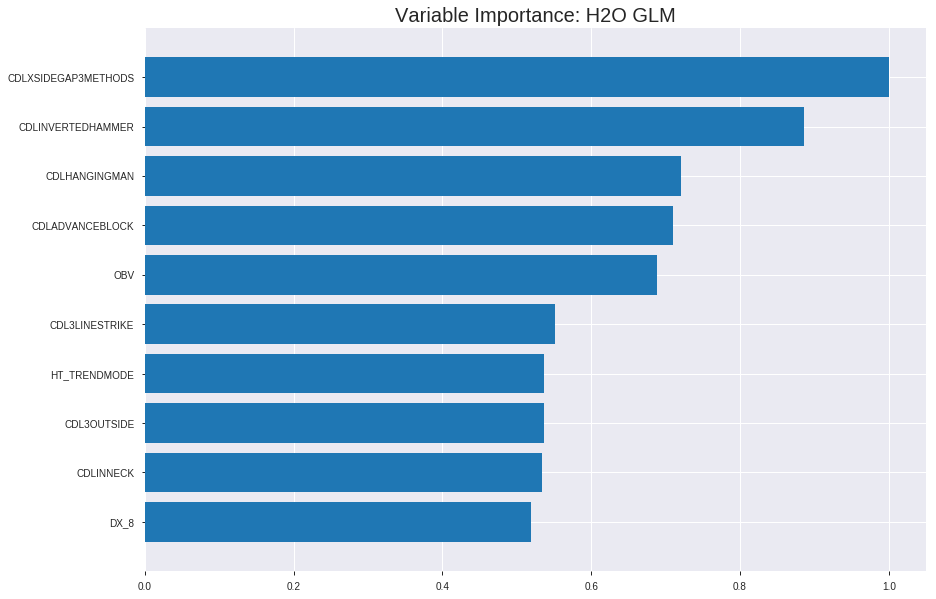

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_152953_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24593370043385868
RMSE: 0.4959170297881075
LogLoss: 0.684976648758312
Null degrees of freedom: 1345
Residual degrees of freedom: 851
Null deviance: 1865.9403229770678
Residual deviance: 1843.9571384573755
AIC: 2833.9571384573755
AUC: 0.5840359882982834
pr_auc: 0.5802852520614953
Gini: 0.1680719765965668
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44510214339720194: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      27   644   0.9598   (644.0/671.0)
1      7    668   0.0104   (7.0/675.0)
Total  34   1312  0.4837   (651.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.445102     0.67237   376
max f2                       0.42839      0.83581   392
max f0point5                 0.488937     0.579836  243
max accuracy                 0.488937     0.569837  243
max precision                0.580211     0.916667  8
max recall                   0.42839      1         392
max specificity              0.606026     0.99851   0
max absolute_mcc             0.488937     0.143319  243
max min_per_class_accuracy   0.500567     0.548435  205
max mean_per_class_accuracy  0.488937     0.569473  243

Gains/Lift Table: Avg response rate: 50.15 %, avg score: 50.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104012                   0.577458           1.70921   1.70921            0.857143         0.58503   0.857143                    0.58503             0.0177778       0.0177778                  70.9206    70.9206
    2        0.0200594                   0.568376           1.22712   1.47709            0.615385         0.572607  0.740741                    0.579049            0.0118519       0.0296296                  22.7123    47.7092
    3        0.0304606                   0.564671           1.42434   1.45908            0.714286         0.566588  0.731707                    0.574794            0.0148148       0.0444444                  42.4339    45.9079
    4        0.0401189                   0.560231           1.38051   1.44016            0.692308         0.562478  0.722222                    0.571829            0.0133333       0.0577778                  38.0513    44.0165
    5        0.0505201                   0.557024           1.2819    1.40758            0.642857         0.558691  0.705882                    0.569124            0.0133333       0.0711111                  28.1905    40.7582
    6        0.100297                    0.548298           1.13097   1.2703             0.567164         0.552732  0.637037                    0.560989            0.0562963       0.127407                   13.0967    27.0299
    7        0.150074                    0.538905           0.982156  1.17473            0.492537         0.543076  0.589109                    0.555047            0.0488889       0.176296                   -1.78441   17.4727
    8        0.200594                    0.531125           1.17298   1.17429            0.588235         0.534375  0.588889                    0.549841            0.0592593       0.235556                   17.2985    17.4288
    9        0.300149                    0.519082           1.16073   1.16979            0.58209          0.524791  0.586634                    0.541532            0.115556        0.351111                   16.073     16.9791
    10       0.400446                    0.509281           0.989652  1.12467            0.496296         0.513924  0.564007                    0.534617            0.0992593       0.45037                    -1.03484   12.4673
    11       0.5                         0.500477           0.997037  1.09926            0.5              0.504785  0.551263                    0.528677            0.0992593       0.54963                    -0.296296  9.92593
    12       0.600297                    0.491207           1.13736   1.10563            0.57037          0.495903  0.554455                    0.523202            0.114074        0.663704                   13.7361    10.5625
    13       0.699851                    0.481761           0.863107  1.07113            0.432836         0.486147  0.537155                    0.51793             0.0859259       0.74963                    -13.6893   7.11268
    14       0.800149                    0.470745           0.871484  1.0461             0.437037         0.476068  0.524605                    0.512683            0.0874074       0.837037                   -12.8516   4.6102
    15       0.899703                    0.459872           0.937512  1.03409            0.470149         0.465717  0.51858                     0.507486            0.0933333       0.93037                    -6.24876   3.40863
    16       1                           0.380058           0.694233  1                  0.348148         0.447661  0.501486                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24878581691828228
RMSE: 0.49878433908682646
LogLoss: 0.6906939861607846
Null degrees of freedom: 383
Residual degrees of freedom: -111
Null deviance: 532.352313052814
Residual deviance: 530.4529813714826
AIC: 1520.4529813714826
AUC: 0.5283888994384613
pr_auc: 0.5465716681421097
Gini: 0.05677779887692269
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4007751541601927: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    191  0.9896   (191.0/193.0)
1      0    191  0        (0.0/191.0)
Total  2    382  0.4974   (191.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.400775     0.666667  381
max f2                       0.400775     0.833333  381
max f0point5                 0.434448     0.563161  353
max accuracy                 0.549708     0.533854  19
max precision                0.573383     1         0
max recall                   0.400775     1         381
max specificity              0.573383     1         0
max absolute_mcc             0.549708     0.141865  19
max min_per_class_accuracy   0.503894     0.497382  188
max mean_per_class_accuracy  0.477091     0.534967  273

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 49.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.564954           2.01047   2.01047            1                0.567766  1                           0.567766            0.0209424       0.0209424                  101.047   101.047
    2        0.0208333                   0.559359           1.50785   1.75916            0.75             0.562617  0.875                       0.565192            0.0157068       0.0366492                  50.7853   75.9162
    3        0.03125                     0.555646           1.50785   1.67539            0.75             0.556808  0.833333                    0.562397            0.0157068       0.052356                   50.7853   67.5393
    4        0.0416667                   0.553893           1.00524   1.50785            0.5              0.554506  0.75                        0.560424            0.0104712       0.0628272                  0.52356   50.7853
    5        0.0520833                   0.549582           2.01047   1.60838            1                0.551965  0.8                         0.558733            0.0209424       0.0837696                  101.047   60.8377
    6        0.101562                    0.537496           0.846514  1.23721            0.421053         0.54282   0.615385                    0.55098             0.0418848       0.125654                   -15.3486  23.7213
    7        0.151042                    0.530929           1.05814   1.17855            0.526316         0.533972  0.586207                    0.545409            0.052356        0.17801                    5.81427   17.8552
    8        0.200521                    0.526515           0.7407    1.07051            0.368421         0.528648  0.532468                    0.541273            0.0366492       0.21466                    -25.93    7.05106
    9        0.299479                    0.518295           1.00524   1.04894            0.5              0.522731  0.521739                    0.535146            0.0994764       0.314136                   0.52356   4.89415
    10       0.401042                    0.50868            0.97946   1.03135            0.487179         0.51397   0.512987                    0.529783            0.0994764       0.413613                   -2.05397  3.13456
    11       0.5                         0.503305           0.846514  0.994764           0.421053         0.505778  0.494792                    0.525032            0.0837696       0.497382                   -15.3486  -0.52356
    12       0.598958                    0.49439            1.16396   1.02272            0.578947         0.499021  0.508696                    0.520735            0.115183        0.612565                   16.3957   2.2718
    13       0.700521                    0.479732           1.13411   1.03887            0.564103         0.488811  0.516729                    0.516106            0.115183        0.727749                   13.4112   3.8868
    14       0.799479                    0.455372           0.899421  1.02161            0.447368         0.469502  0.508143                    0.510338            0.0890052       0.816754                   -10.0579  2.16075
    15       0.898438                    0.439495           0.952328  1.01398            0.473684         0.446846  0.504348                    0.503344            0.0942408       0.910995                   -4.76715  1.39768
    16       1                           0.389437           0.876359  1                  0.435897         0.421993  0.497396                    0.495082          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 15:29:54  0.000 sec   2            3.7       495           1.37511           1.38204
    2019-08-25 15:29:54  0.327 sec   4            2.7       495           1.37281           1.38157
    2019-08-25 15:29:54  0.651 sec   6            2         495           1.36995           1.38139
    2019-08-25 15:29:55  0.985 sec   8            1.4       495           1.36649           1.38143
    2019-08-25 15:29:55  1.306 sec   10           1         495           1.36238           1.38183
    2019-08-25 15:29:55  1.642 sec   12           0.75      495           1.35764           1.38274
    2019-08-25 15:29:56  1.978 sec   14           0.55      495           1.35232           1.38442
    2019-08-25 15:29:56  2.302 sec   16           0.4       495           1.34653           1.38709

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5803108808290155)

('F1', 0.7210884353741497)

('auc', 0.574400871459695)

('logloss', 0.7444310288461847)

('mean_per_class_error', 0.4205882352941177)

('rmse', 0.5243812647313005)

('mse', 0.2749757108011983)

glm prediction progress: |████████████████████████████████████████████████| 100%


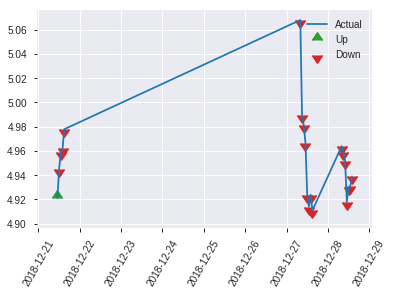


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2749757108011983
RMSE: 0.5243812647313005
LogLoss: 0.7444310288461847
Null degrees of freedom: 192
Residual degrees of freedom: -302
Null deviance: 267.41981442535183
Residual deviance: 287.3503771346273
AIC: 1277.3503771346273
AUC: 0.574400871459695
pr_auc: 0.6201817472221873
Gini: 0.14880174291938997
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33108583404634784: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      5    80   0.9412   (80.0/85.0)
1      2    106  0.0185   (2.0/108.0)
Total  7    186  0.4249   (82.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.331086     0.721088  185
max f2                       0.316032     0.865385  191
max f0point5                 0.381728     0.625     100
max accuracy                 0.381728     0.580311  100
max precision                0.454006     1         0
max recall                   0.316032     1         191
max specificity              0.454006     1         0
max absolute_mcc             0.386879     0.159258  82
max min_per_class_accuracy   0.383884     0.564815  95
max mean_per_class_accuracy  0.386879     0.579412  82

Gains/Lift Table: Avg response rate: 55.96 %, avg score: 38.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.448395           1.78704   1.78704            1                0.452997  1                           0.452997            0.0185185       0.0185185                  78.7037   78.7037
    2        0.0207254                   0.444141           0         0.893519           0                0.447698  0.5                         0.450348            0               0.0185185                  -100      -10.6481
    3        0.0310881                   0.441712           0.893519  0.893519           0.5              0.442843  0.5                         0.447846            0.00925926      0.0277778                  -10.6481  -10.6481
    4        0.0414508                   0.441002           1.78704   1.1169             1                0.441369  0.625                       0.446227            0.0185185       0.0462963                  78.7037   11.6898
    5        0.0518135                   0.438174           1.78704   1.25093            1                0.440554  0.7                         0.445092            0.0185185       0.0648148                  78.7037   25.0926
    6        0.103627                    0.420275           1.25093   1.25093            0.7              0.428553  0.7                         0.436823            0.0648148       0.12963                    25.0926   25.0926
    7        0.150259                    0.409486           1.19136   1.23244            0.666667         0.413908  0.689655                    0.429711            0.0555556       0.185185                   19.1358   23.2439
    8        0.202073                    0.404069           0.893519  1.14554            0.5              0.40708   0.641026                    0.423908            0.0462963       0.231481                   -10.6481  14.5537
    9        0.300518                    0.394061           1.22271   1.17082            0.684211         0.398627  0.655172                    0.415626            0.12037         0.351852                   22.271    17.0817
    10       0.398964                    0.388399           0.940546  1.114              0.526316         0.390962  0.623377                    0.40954             0.0925926       0.444444                   -5.94542  11.3997
    11       0.502591                    0.383182           1.16157   1.12381            0.65             0.385865  0.628866                    0.404659            0.12037         0.564815                   16.1574   12.3807
    12       0.601036                    0.377111           0.752437  1.06298            0.421053         0.379853  0.594828                    0.400596            0.0740741       0.638889                   -24.7563  6.29789
    13       0.699482                    0.3708             0.752437  1.01927            0.421053         0.37428   0.57037                     0.396892            0.0740741       0.712963                   -24.7563  1.9273
    14       0.797927                    0.362918           1.12865   1.03277            0.631579         0.367017  0.577922                    0.393206            0.111111        0.824074                   12.8655   3.27682
    15       0.896373                    0.34054            0.752437  1.00198            0.421053         0.354471  0.560694                    0.388952            0.0740741       0.898148                   -24.7563  0.19803
    16       1                           0.314448           0.98287   1                  0.55             0.331373  0.559585                    0.382985        

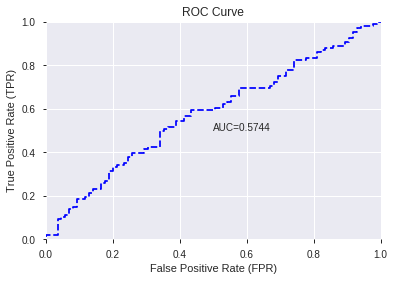

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


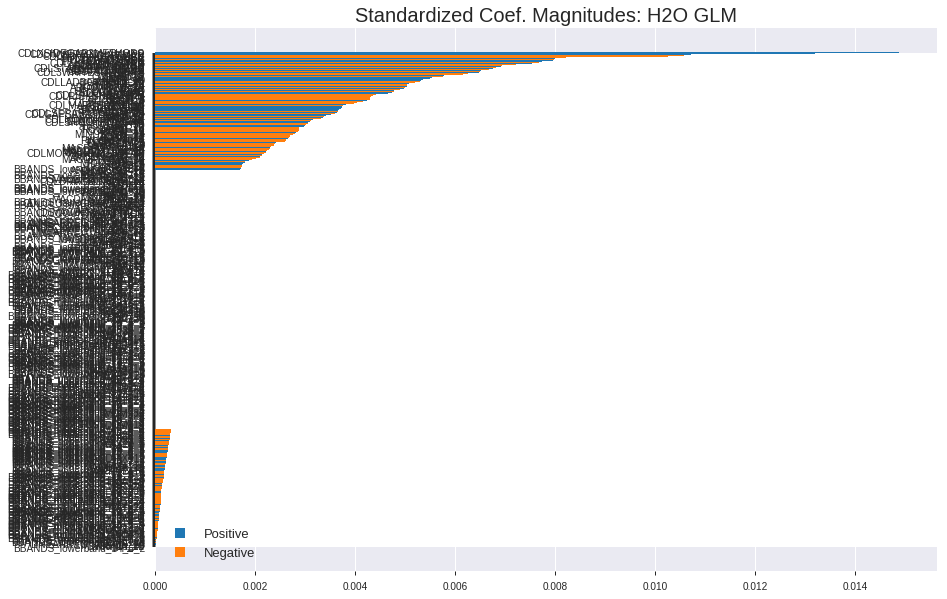

'log_likelihood'
--2019-08-25 15:30:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.17.232
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.17.232|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


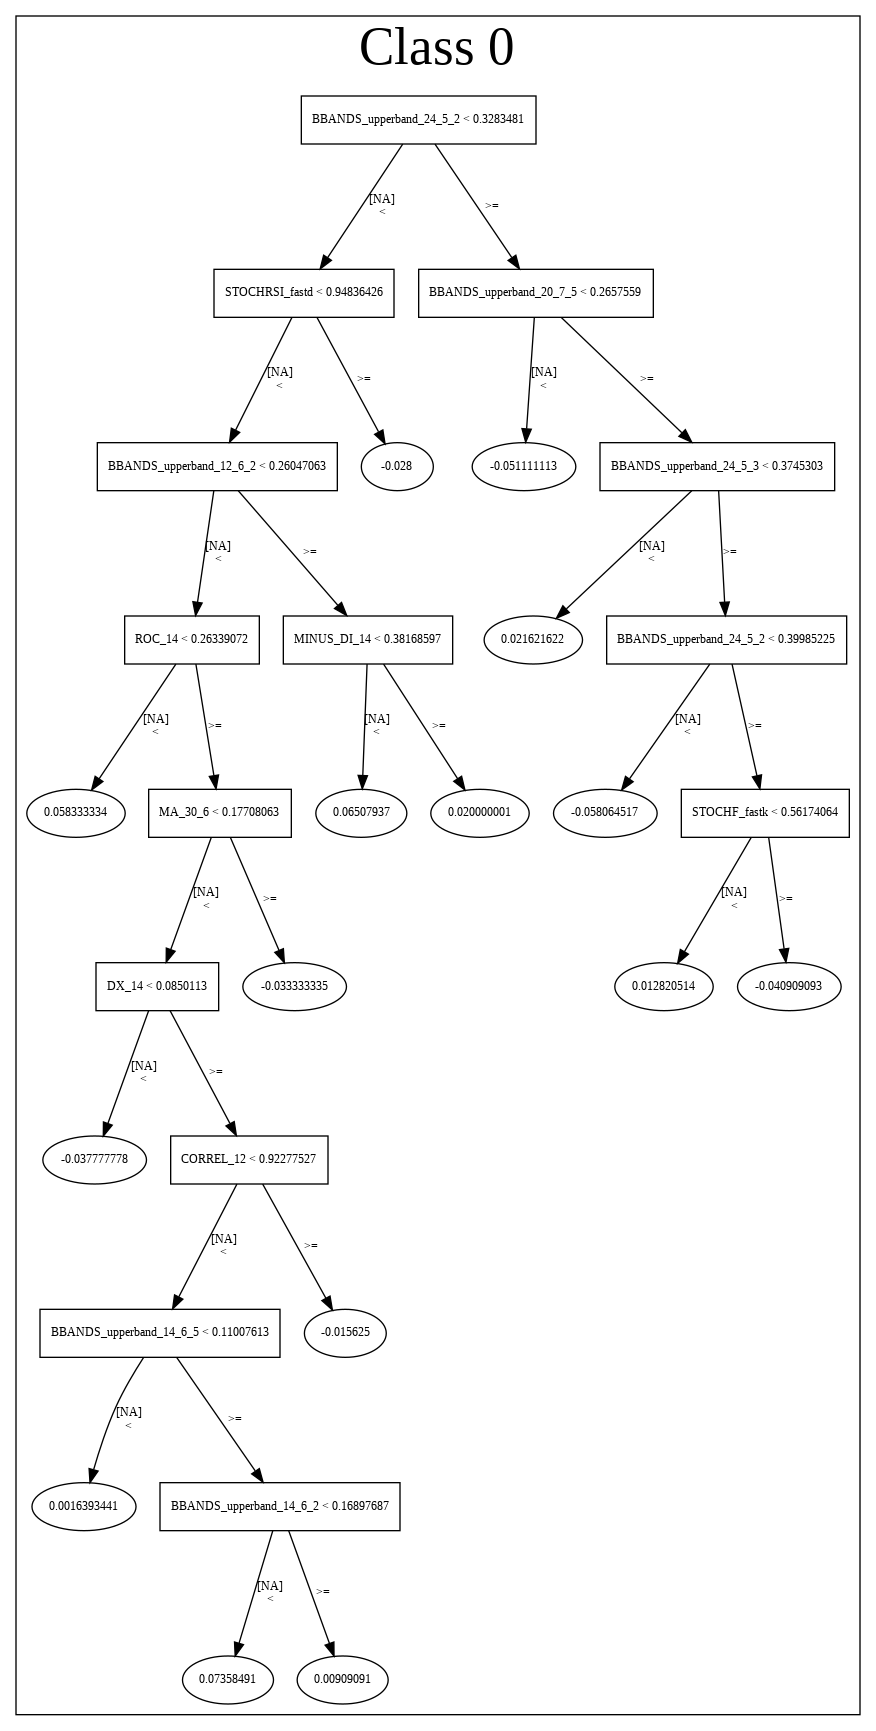

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_152953_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_152953_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_9982',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLXSIDEGAP3METHODS',
 'CDLINVERTEDHAMMER',
 'CDLHANGINGMAN',
 'CDLADVANCEBLOCK',
 'OBV',
 'CDL3LINESTRIKE',
 'HT_TRENDMODE',
 'CDL3OUTSIDE',
 'CDLINNECK',
 'DX_8',
 'CDLMORNINGSTAR',
 'CDLDOJISTAR',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'MFI_12',
 'CDLSTALLEDPATTERN',
 'CDLENGULFING',
 'CDLHIGHWAVE',
 'CDLTASUKIGAP',
 'CDL3WHITESOLDIERS',
 'MFI_8',
 'ADOSC',
 'CORREL_8',
 'WILLR_14',
 'TRANGE',
 'MFI_14',
 'NATR_30',
 'aroondown_20',
 'aroonup_20',
 'CDLLADDERBOTTOM',
 'aroonup_24',
 'BETA_14',
 'aroondown_14',
 'AROONOSC_24',
 'ATR_30',
 'BOP',
 'WILLR_12',
 'HT_DCPERIOD',
 'STOCH_slowd',
 'AD',
 'CDLHAMMER',
 'NATR_24',
 'CDLSPINNINGTOP',
 'CDLRICKSHAWMAN',
 'ROCR_8',
 'ROCP_8',
 'ROCR100_8',
 'ROC_8',
 'ATR_24',
 'CDLSHORTLINE',
 'MOM_8',
 'ROCR100_24',
 'CDLMATCHINGLOW',
 'ADX_20',
 'CDL3INSIDE',
 'STOCHF_fastd',
 'STOCH_slowk',
 'WILLR_20',
 'PLUS_DM_30',
 'MOM_24',
 'CDLSEPARATINGLINES',
 'CDLGAPSIDESIDEWHITE',
 'BETA_12',
 'ATR_20',
 'VAR_12',
 'aroondown_24',
 'CDLHOMINGPIGEON',


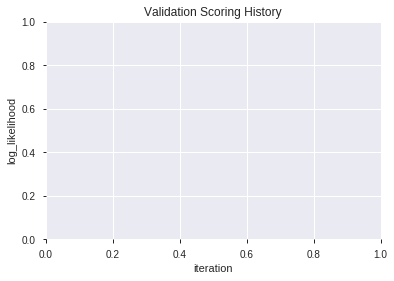

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_153018_model_7  0.625926  0.734540              0.492865  0.518372  0.268709
1               XGBoost_2_AutoML_20190825_153018  0.624619  0.702206              0.476471  0.504307  0.254326
2  XGBoost_grid_1_AutoML_20190825_153018_model_4  0.602179  0.723661              0.488235  0.514769  0.264987
3               XGBoost_3_AutoML_20190825_153018  0.599020  0.721942              0.395861  0.513948  0.264143
4  XGBoost_grid_1_AutoML_20190825_153018_model_2  0.584858  0.712503              0.500000  0.509387  0.259475
5  XGBoost_grid_1_AutoML_20190825_153018_model_6  0.582353  0.740484              0.494118  0.521872  0.272351
6  XGBoost_grid_1_AutoML_20190825_153018_model_1  0.567593  0.749849              0.494118  0.525454  0.276102
7  XGBoost_grid_1_AutoML_20190825_153018_model_3  0.565904  0.727501              0.466830  0.516071  0.266329
8  XGBoost_grid_1_AutoML_20190825_153018_model_5  0.556645  0.831715              0.492865  0.556047  0.309189
9               XGBoost_1_AutoML_20190825_153018  0.514706  0.767657              0.494118  0.533318  0.284428

variable  relative_importance  scaled_importance  percentage
0             STOCHRSI_fastd           214.022369           1.000000    0.027654
1                      MFI_8           196.918350           0.920083    0.025444
2                        OBV           129.110474           0.603257    0.016682
3                     TRANGE           128.968002           0.602591    0.016664
4                     ADX_12           115.648415           0.540357    0.014943
..                       ...                  ...                ...         ...
307              AROONOSC_30             2.473183           0.011556    0.000320
308                  MA_20_3             2.108997           0.009854    0.000273
309                   RSI_30             2.087218           0.009752    0.000270
310                     MACD             1.242805           0.005807    0.000161
311  BBANDS_lowerband_14_2_4             0.727190           0.003398    0.000094

[312 rows x 4 columns]

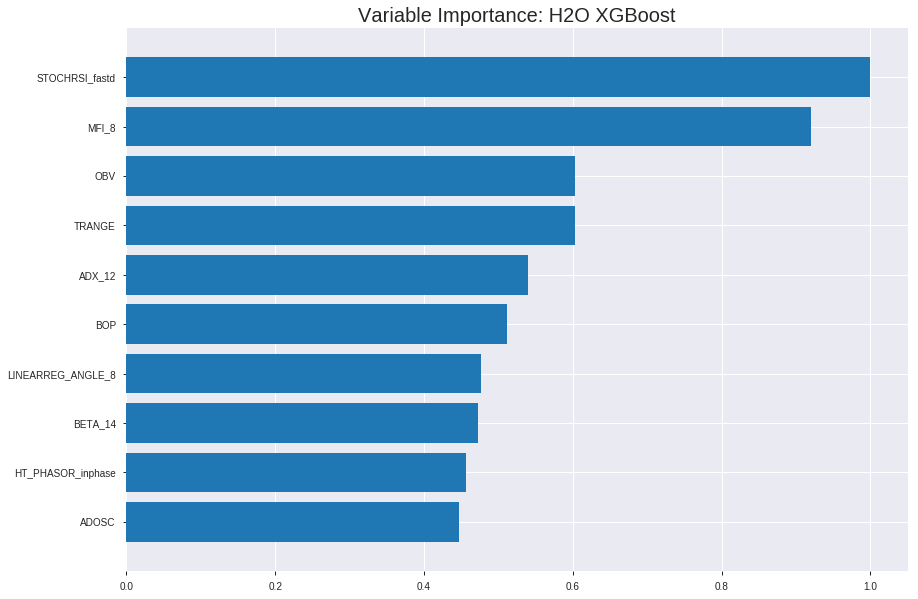

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_153018_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12994883965807597
RMSE: 0.3604841739356611
LogLoss: 0.43905175144851427
Mean Per-Class Error: 0.06614229728983823
AUC: 0.9836672738312082
pr_auc: 0.9825577389474668
Gini: 0.9673345476624164
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49688485264778137: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      622  49   0.073    (49.0/671.0)
1      40   635  0.0593   (40.0/675.0)
Total  662  684  0.0661   (89.0/1346.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496885     0.934511  199
max f2                       0.454636     0.954585  223
max f0point5                 0.532675     0.949668  181
max accuracy                 0.496885     0.933878  199
max precision                0.866527     1         0
max recall                   0.344135     1         295
max specificity              0.866527     1         0
max absolute_mcc             0.496885     0.867828  199
max min_per_class_accuracy   0.500378     0.932936  197
max mean_per_class_accuracy  0.496885     0.933858  199

Gains/Lift Table: Avg response rate: 50.15 %, avg score: 50.17 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104012                   0.814777           1.99407    1.99407            1                0.833     1                           0.833               0.0207407       0.0207407                  99.4074   99.4074
    2        0.0200594                   0.794313           1.99407    1.99407            1                0.802505  1                           0.818317            0.0192593       0.04                       99.4074   99.4074
    3        0.0304606                   0.784766           1.99407    1.99407            1                0.789961  1                           0.808634            0.0207407       0.0607407                  99.4074   99.4074
    4        0.0401189                   0.776263           1.99407    1.99407            1                0.781208  1                           0.802032            0.0192593       0.08                       99.4074   99.4074
    5        0.0505201                   0.769113           1.99407    1.99407            1                0.773018  1                           0.796058            0.0207407       0.100741                   99.4074   99.4074
    6        0.100297                    0.737279           1.99407    1.99407            1                0.752831  1                           0.774605            0.0992593       0.2                        99.4074   99.4074
    7        0.150074                    0.708209           1.99407    1.99407            1                0.722592  1                           0.757353            0.0992593       0.299259                   99.4074   99.4074
    8        0.200594                    0.684162           1.99407    1.99407            1                0.696168  1                           0.741943            0.100741        0.4                        99.4074   99.4074
    9        0.300149                    0.638738           1.97919    1.98914            0.992537         0.663254  0.997525                    0.715843            0.197037        0.597037                   97.9193   98.9138
    10       0.400446                    0.577077           1.83159    1.94968            0.918519         0.610725  0.977737                    0.689515            0.183704        0.780741                   83.1594   94.9679
    11       0.5                         0.500126           1.51788    1.8637             0.761194         0.539906  0.934621                    0.659727            0.151111        0.931852                   51.7877   86.3704
    12       0.600297                    0.419381           0.531753   1.64116            0.266667         0.461292  0.82302                     0.626572            0.0533333       0.985185                   -46.8247  64.1162
    13       0.699851                    0.36648            0.119049   1.42464            0.0597015        0.389998  0.714437                    0.592919            0.0118519       0.997037                   -88.0951  42.4641
    14       0.800149                    0.320894           0.0295418  1.24977            0.0148148        0.343632  0.626741                    0.561672            0.00296296      1                          -97.0458  24.9768
    15       0.899703                    0.268296           0          1.11148            0                0.293633  0.557391                    0.532013            0               1                          -100      11.1478
    16       1                           0.130052           0          1                  0                0.229581  0.501486                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2606530309459741
RMSE: 0.5105418993050169
LogLoss: 0.7175149581665287
Mean Per-Class Error: 0.43762037815695964
AUC: 0.5334617367007569
pr_auc: 0.5071956523690545
Gini: 0.06692347340151383
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2269793450832367: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    192  0.9948   (192.0/193.0)
1      0    191  0        (0.0/191.0)
Total  1    383  0.5      (192.0/384.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.226979     0.665505  382
max f2                       0.226979     0.832607  382
max f0point5                 0.489328     0.558325  202
max accuracy                 0.505282     0.5625    182
max precision                0.80144      0.666667  2
max recall                   0.226979     1         382
max specificity              0.802113     0.994819  0
max absolute_mcc             0.505282     0.124895  182
max min_per_class_accuracy   0.502166     0.554404  191
max mean_per_class_accuracy  0.505282     0.56238   182

Gains/Lift Table: Avg response rate: 49.74 %, avg score: 49.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104167                   0.791768           1.00524   1.00524            0.5              0.800375  0.5                         0.800375            0.0104712       0.0104712                  0.52356   0.52356
    2        0.0208333                   0.768794           1.00524   1.00524            0.5              0.780634  0.5                         0.790504            0.0104712       0.0209424                  0.52356   0.52356
    3        0.03125                     0.736462           0.502618  0.837696           0.25             0.756156  0.416667                    0.779055            0.0052356       0.026178                   -49.7382  -16.2304
    4        0.0416667                   0.723387           0.502618  0.753927           0.25             0.725533  0.375                       0.765674            0.0052356       0.0314136                  -49.7382  -24.6073
    5        0.0520833                   0.712288           1.50785   0.904712           0.75             0.716861  0.45                        0.755912            0.0157068       0.0471204                  50.7853   -9.5288
    6        0.101562                    0.668861           0.7407    0.824809           0.368421         0.686701  0.410256                    0.722194            0.0366492       0.0837696                  -25.93    -17.5191
    7        0.151042                    0.644363           0.952328  0.866582           0.473684         0.657296  0.431034                    0.700934            0.0471204       0.13089                    -4.76715  -13.3418
    8        0.200521                    0.614132           1.16396   0.939961           0.578947         0.628677  0.467532                    0.683105            0.0575916       0.188482                   16.3957   -6.00394
    9        0.299479                    0.569866           1.37559   1.08391            0.684211         0.589319  0.53913                     0.652115            0.136126        0.324607                   37.5586   8.39062
    10       0.401042                    0.536762           1.13411   1.09662            0.564103         0.551557  0.545455                    0.626649            0.115183        0.439791                   13.4112   9.66207
    11       0.5                         0.50142            1.16396   1.10995            0.578947         0.515519  0.552083                    0.604654            0.115183        0.554974                   16.3957   10.9948
    12       0.598958                    0.461792           0.846514  1.06642            0.421053         0.481563  0.530435                    0.584317            0.0837696       0.638743                   -15.3486  6.64239
    13       0.700521                    0.422028           0.773258  1.02392            0.384615         0.44264   0.509294                    0.563777            0.078534        0.717277                   -22.6742  2.39203
    14       0.799479                    0.382438           0.952328  1.01506            0.473684         0.405113  0.504886                    0.544138            0.0942408       0.811518                   -4.76715  1.50588
    15       0.898438                    0.324139           1.00524   1.01398            0.5              0.354405  0.504348                    0.52324             0.0994764       0.910995                   0.52356   1.39768
    16       1                           0.225337           0.876359  1                  0.435897         0.283522  0.497396                    0.498893    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 15:30:37  12.435 sec  0                  0.5              0.693147            0.5             0                  1                0.498514                         0.5                0.693147              0.5               0                    1                  0.502604
    2019-08-25 15:30:37  12.881 sec  5                  0.480379         0.654532            0.82488         0.823096           1.99407          0.286776                         0.499372           0.691892              0.530627          0.520344             0.804188           0.481771
    2019-08-25 15:30:37  12.994 sec  10                 0.462164         0.619702            0.892915        0.889042           1.99407          0.190193                         0.501596           0.696423              0.515978          0.497485             1.00524            0.489583
    2019-08-25 15:30:37  13.115 sec  15                 0.445477         0.588442            0.918217        0.91611            1.99407          0.153789                         0.502355           0.69807               0.524401          0.50357              0.502618           0.502604
    2019-08-25 15:30:37  13.244 sec  20                 0.430061         0.560216            0.93994         0.939103           1.99407          0.135958                         0.505326           0.704471              0.516995          0.494789             0.502618           0.489583
    2019-08-25 15:30:38  13.363 sec  25                 0.416133         0.535187            0.954898        0.954002           1.99407          0.114413                         0.507085           0.708251              0.514038          0.489136             0.502618           0.497396
    2019-08-25 15:30:38  13.473 sec  30                 0.404325         0.514147            0.962031        0.961849           1.99407          0.101783                         0.506335           0.707007              0.525215          0.498768             0.502618           0.486979
    2019-08-25 15:30:38  13.586 sec  35                 0.391762         0.492138            0.969004        0.967839           1.99407          0.089153                         0.50718            0.709115              0.531075          0.50154              0.502618           0.479167
    2019-08-25 15:30:38  13.701 sec  40                 0.380831         0.473356            0.974609        0.973156           1.99407          0.076523                         0.505996           0.707058              0.543038          0.508405             0.502618           0.479167
    2019-08-25 15:30:38  13.815 sec  45                 0.370054         0.455058            0.980299        0.979443           1.99407          0.0705795                        0.508706           0.713357              0.539077          0.510705             0.502618           0.497396
    2019-08-25 15:30:38  13.926 sec  50                 0.360484         0.439052            0.983667        0.982558           1.99407          0.0661218                        0.510542           0.717515              0.533462          0.507196             1.00524            0.5

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
STOCHRSI_fastd           214.02236938476562     1.0                   0.027653888452194925
MFI_8                    196.91835021972656     0.9200830305065459    0.025443873492385482
OBV                      129.1104736328125      0.6032569119011105    0.016682399349728892
TRANGE                   128.96800231933594     0.6025912276836799    0.016663990592635677
ADX_12                   115.6484146118164      0.5403566689980229    0.014942963048870944
---                      ---                    ---                   ---
AROONOSC_30              2.4731826782226562     0.011555720485349886  0.00031956060528660955
MA_20_3                  2.108997344970703      0.00985409773302334   0.0002725041195060544
RSI_30                   2.0872182846069336     0.009752337059938672  0.00026969004120375064
MACD                     1.2428054809570312     0.005806895253657984  0.00016058323359823803
BBANDS_lowerband_14_2_4  0.7271895408630371     0.003397726802826431  9.396035799639502e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6217616580310881)

('F1', 0.7181208053691275)

('auc', 0.6259259259259259)

('logloss', 0.7345399104344004)

('mean_per_class_error', 0.37265795206971675)

('rmse', 0.5183715341667106)

('mse', 0.26870904743434915)

xgboost prediction progress: |████████████████████████████████████████████| 100%


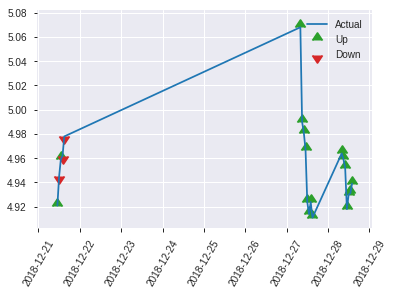


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.26870904743434915
RMSE: 0.5183715341667106
LogLoss: 0.7345399104344004
Mean Per-Class Error: 0.37265795206971675
AUC: 0.6259259259259259
pr_auc: 0.656307609073636
Gini: 0.25185185185185177
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21214231848716736: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      2    83   0.9765   (83.0/85.0)
1      1    107  0.0093   (1.0/108.0)
Total  3    190  0.4352   (84.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.212142     0.718121  189
max f2                       0.181692     0.864     192
max f0point5                 0.376731     0.665323  96
max accuracy                 0.376731     0.621762  96
max precision                0.47703      0.806452  30
max recall                   0.181692     1         192
max specificity              0.676448     0.988235  0
max absolute_mcc             0.422778     0.266356  60
max min_per_class_accuracy   0.376731     0.611111  96
max mean_per_class_accuracy  0.391081     0.627342  81

Gains/Lift Table: Avg response rate: 55.96 %, avg score: 38.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.635147           0.893519  0.893519           0.5              0.666987  0.5                         0.666987            0.00925926      0.00925926                 -10.6481  -10.6481
    2        0.0207254                   0.588659           0.893519  0.893519           0.5              0.612959  0.5                         0.639973            0.00925926      0.0185185                  -10.6481  -10.6481
    3        0.0310881                   0.574533           0         0.595679           0                0.584555  0.333333                    0.6215              0               0.0185185                  -100      -40.4321
    4        0.0414508                   0.569244           1.78704   0.893519           1                0.570998  0.5                         0.608875            0.0185185       0.037037                   78.7037   -10.6481
    5        0.0518135                   0.558457           1.78704   1.07222            1                0.564386  0.6                         0.599977            0.0185185       0.0555556                  78.7037   7.22222
    6        0.103627                    0.504889           1.42963   1.25093            0.8              0.527323  0.7                         0.56365             0.0740741       0.12963                    42.963    25.0926
    7        0.150259                    0.477473           1.78704   1.41731            1                0.486332  0.793103                    0.539654            0.0833333       0.212963                   78.7037   41.7305
    8        0.202073                    0.460214           1.25093   1.37464            0.7              0.469579  0.769231                    0.521686            0.0648148       0.277778                   25.0926   37.4644
    9        0.300518                    0.425219           1.31676   1.35568            0.736842         0.441766  0.758621                    0.495506            0.12963         0.407407                   31.6764   35.5683
    10       0.398964                    0.394312           0.940546  1.25325            0.526316         0.41115   0.701299                    0.474691            0.0925926       0.5                        -5.94542  25.3247
    11       0.502591                    0.376731           1.07222   1.21592            0.6              0.38664   0.680412                    0.456536            0.111111        0.611111                   7.22222   21.5922
    12       0.601036                    0.345072           0.658382  1.1246             0.368421         0.362143  0.62931                     0.441075            0.0648148       0.675926                   -34.1618  12.4601
    13       0.699482                    0.326069           0.658382  1.05898            0.368421         0.336127  0.592593                    0.426304            0.0648148       0.740741                   -34.1618  5.89849
    14       0.797927                    0.302777           0.846491  1.03277            0.473684         0.314778  0.577922                    0.412545            0.0833333       0.824074                   -15.3509  3.27682
    15       0.896373                    0.268937           0.846491  1.01231            0.473684         0.288864  0.566474                    0.398961            0.0833333       0.907407                   -15.3509  1.231
    16       1                           0.181692           0.893519  1                  0.5              0.243304  0.559585                    0.382831       

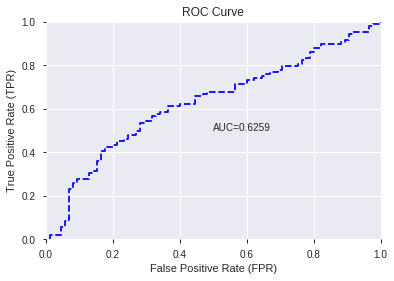

This function is available for GLM models only


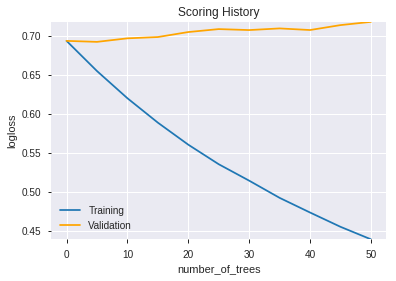

--2019-08-25 15:30:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

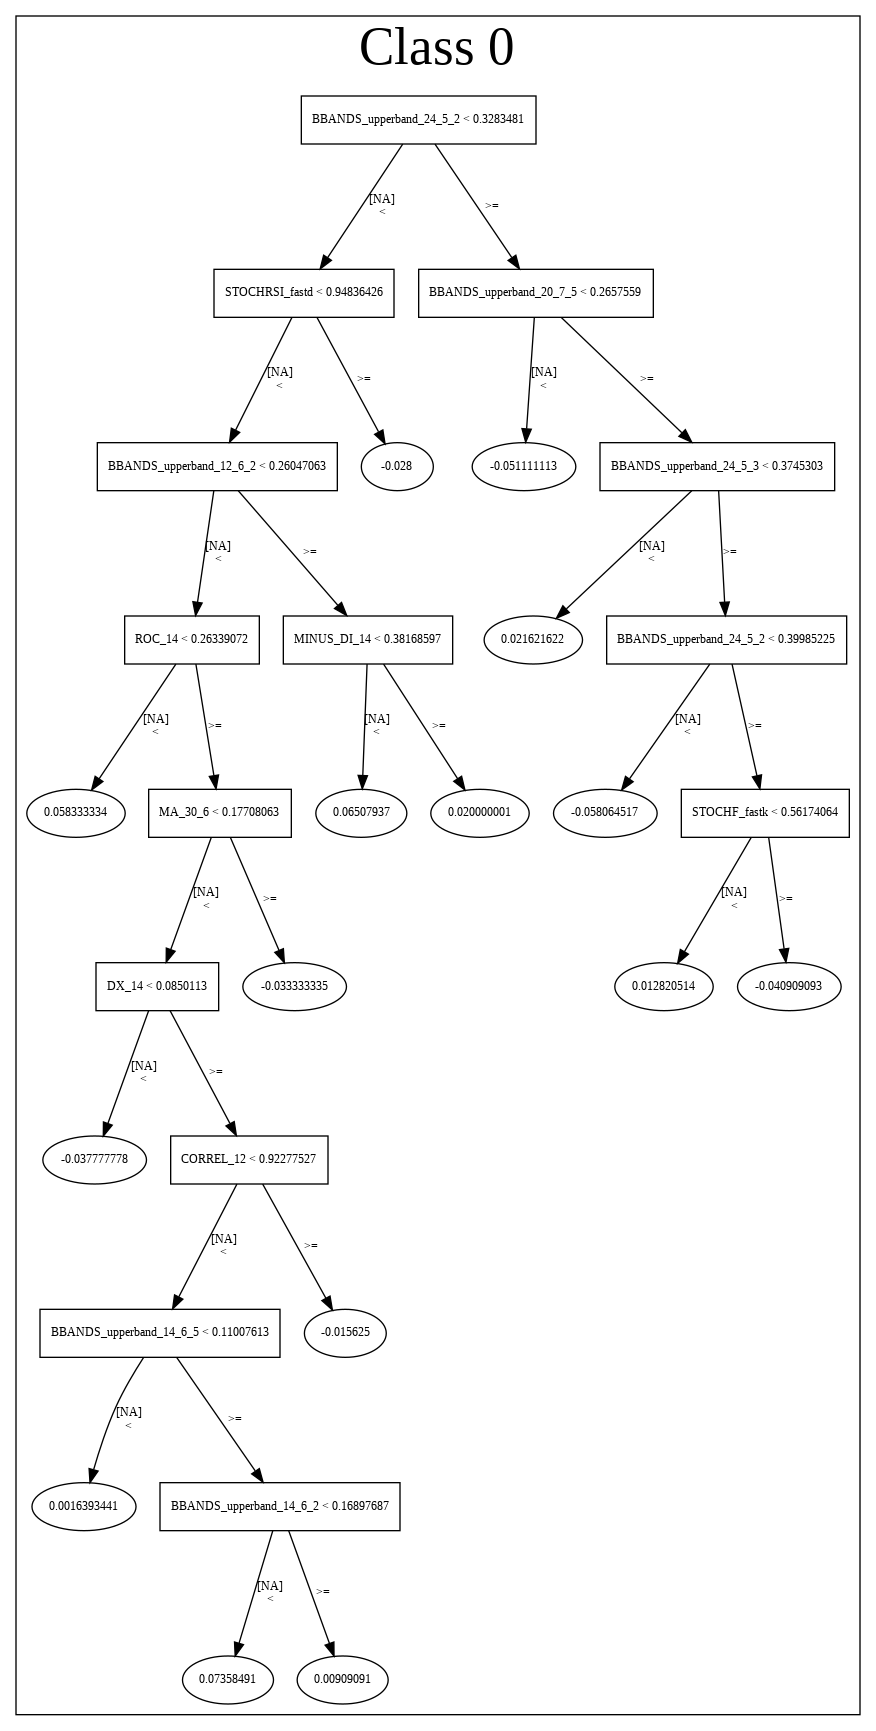

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_153018_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_153018_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_9982',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['STOCHRSI_fastd',
 'MFI_8',
 'OBV',
 'TRANGE',
 'ADX_12',
 'BOP',
 'LINEARREG_ANGLE_8',
 'BETA_14',
 'HT_PHASOR_inphase',
 'ADOSC',
 'ULTOSC',
 'HT_DCPERIOD',
 'ADX_14',
 'STOCHF_fastk',
 'MFI_12',
 'CORREL_12',
 'STOCH_slowk',
 'STOCHRSI_fastk',
 'DX_30',
 'AD',
 'WILLR_8',
 'ADXR_8',
 'HT_PHASOR_quadrature',
 'CORREL_8',
 'CORREL_14',
 'MOM_24',
 'PLUS_DM_30',
 'LINEARREG_ANGLE_12',
 'MFI_24',
 'STOCH_slowd',
 'ATR_30',
 'MOM_30',
 'SAR_0.24',
 'BETA_12',
 'WILLR_12',
 'LINEARREG_ANGLE_20',
 'aroonup_8',
 'CCI_12',
 'PLUS_DM_14',
 'NATR_30',
 'VAR_20',
 'DX_14',
 'BETA_24',
 'NATR_12',
 'MFI_20',
 'MINUS_DM_8',
 'MOM_14',
 'BBANDS_lowerband_24_3_3',
 'MFI_14',
 'MACDFIX_signal_20',
 'AROONOSC_14',
 'CORREL_20',
 'CCI_8',
 'aroondown_30',
 'NATR_24',
 'aroonup_24',
 'LINEARREG_INTERCEPT_8',
 'MINUS_DM_12',
 'BBANDS_lowerband_14_6_4',
 'ATR_20',
 'MINUS_DI_8',
 'STDDEV_8',
 'PLUS_DM_8',
 'MINUS_DM_20',
 'CORREL_24',
 'PLUS_DI_30',
 'BBANDS_upperband_30_6_5',
 'STDDEV_12',
 'MOM_20',
 

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.663
GLM             0.585
XGBoost         0.627
dtype: float64

DeepLearning    GLM  XGBoost
All          0.611  0.585    0.611
DLF          0.663  0.575    0.627
Fwe          0.622  0.585    0.611
RFE          0.611  0.580    0.622
XGBF         0.632  0.575    0.627





F1


DeepLearning    0.740
GLM             0.725
XGBoost         0.735
dtype: float64

DeepLearning    GLM  XGBoost
All          0.727  0.722    0.735
DLF          0.727  0.725    0.718
Fwe          0.735  0.722    0.735
RFE          0.740  0.721    0.718
XGBF         0.730  0.725    0.718





auc


DeepLearning    0.665
GLM             0.582
XGBoost         0.626
dtype: float64

DeepLearning    GLM  XGBoost
All          0.592  0.582    0.619
DLF          0.665  0.543    0.612
Fwe          0.604  0.582    0.619
RFE          0.586  0.574    0.626
XGBF         0.658  0.543    0.612





logloss


DeepLearning    17.403
GLM              0.760
XGBoost          0.738
dtype: float64

DeepLearning    GLM  XGBoost
All          1.250  0.760    0.738
DLF          0.841  0.700    0.703
Fwe         17.403  0.760    0.738
RFE          1.134  0.744    0.735
XGBF         0.852  0.700    0.703





mean_per_class_error


DeepLearning    0.416
GLM             0.450
XGBoost         0.402
dtype: float64

DeepLearning    GLM  XGBoost
All          0.416  0.418    0.402
DLF          0.333  0.450    0.371
Fwe          0.399  0.418    0.402
RFE          0.407  0.421    0.373
XGBF         0.368  0.450    0.371





rmse


DeepLearning    0.748
GLM             0.531
XGBoost         0.521
dtype: float64

DeepLearning    GLM  XGBoost
All          0.654  0.531    0.521
DLF          0.533  0.504    0.504
Fwe          0.748  0.531    0.521
RFE          0.643  0.524    0.518
XGBF         0.541  0.504    0.504





mse


DeepLearning    0.560
GLM             0.282
XGBoost         0.271
dtype: float64

DeepLearning    GLM  XGBoost
All          0.428  0.282    0.271
DLF          0.284  0.254    0.254
Fwe          0.560  0.282    0.271
RFE          0.413  0.275    0.269
XGBF         0.293  0.254    0.254

{'F1':       DeepLearning    GLM  XGBoost
 All          0.727    NaN      NaN
 DLF          0.727    NaN      NaN
 DLF            NaN  0.725      NaN
 DLF            NaN    NaN    0.718
 All            NaN  0.722      NaN
 All            NaN    NaN    0.735
 XGBF         0.730    NaN      NaN
 XGBF           NaN  0.725      NaN
 XGBF           NaN    NaN    0.718
 Fwe          0.735    NaN      NaN
 Fwe            NaN  0.722      NaN
 Fwe            NaN    NaN    0.735
 RFE          0.740    NaN      NaN
 RFE            NaN  0.721      NaN
 RFE            NaN    NaN    0.718,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.611    NaN      NaN
 DLF          0.663    NaN      NaN
 DLF            NaN  0.575      NaN
 DLF            NaN    NaN    0.627
 All            NaN  0.585      NaN
 All            NaN    NaN    0.611
 XGBF         0.632    NaN      NaN
 XGBF           NaN  0.575      NaN
 XGBF           NaN    NaN    0.627
 Fwe          0.622    NaN      NaN
 Fwe     